In [572]:
# Packages import
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import pyDOE as doe
import sklearn.gaussian_process.kernels as skl
import pymc3 as pm
import theano.tensor as tt
import theano
import time
import seaborn as sns
from tqdm import tqdm
import sys
from joblib import Parallel, delayed
import multiprocessing
import psutil
import os
import shutil
import copy
from matplotlib import gridspec
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d
import pickle

import pickle as pkl
import tensorflow as tf
import tensorflow_probability as tfp
from scipy.optimize import minimize
from scipy.optimize import fmin
from scipy.optimize import brute
import scipy.optimize as so
from scipy.optimize import Bounds
from matplotlib.lines import Line2D
from sklearn.model_selection import KFold

from scipy.sparse.csgraph import shortest_path
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

# Utilities

In [2]:
#def transform(phi_new):
#    phi = copy.deepcopy(phi_new)
#    if np.any(phi>50):
#        phi[np.invert(phi > 50)] = np.log(np.exp(phi[np.invert(phi > 50)]) + 1)
#        return phi
#    else:
#        return np.log(np.exp(phi) + 1)
    
#def inv_transform(phi_new):
#    phi = copy.deepcopy(phi_new)
#    if np.any(phi>50):
#        phi[np.invert(phi > 50)] = np.log(np.exp(phi[np.invert(phi > 50)]) - 1)
#        return phi
#    else:
#        return np.log(np.exp(phi) - 1)
    
def transform(phi):
    if np.any(phi>50):
        phi[np.invert(phi > 50)] = np.log(np.exp(phi[np.invert(phi > 50)]) + 1)
        return phi
    else:
        return np.log(np.exp(phi) + 1)
    
def inv_transform(phi):
    if np.any(phi>50):
        phi[np.invert(phi > 50)] = np.log(np.exp(phi[np.invert(phi > 50)]) - 1)
        return phi
    else:
        return np.log(np.exp(phi) - 1)

#### Sigma estimation utilites
def sigma_estimate(obs, indices):
    obs_ordered = obs[indices]
    squares = 0
    for i in range(len(indices) - 1):
        squares = squares + (obs_ordered[i + 1] - obs_ordered[i])**2
        
    return np.sqrt(squares / (2 *(len(indices) - 1)))

def path_algorithm_sigma(input_obs, input_y):
    
    min_index = np.argmin(np.sum(np.abs(input_obs), axis = 1))
    min_value = input_y[min_index]
    min_input = input_obs[min_index,:]
    
    # Flip y
    input_y[min_index] = input_y[0]
    input_y[0] = min_value
    
    # Flip input
    input_obs[min_index,:] = input_obs[0,:]
    input_obs[0,:] = min_input
    
    distance_matrix = sp.spatial.distance_matrix(input_obs, input_obs, p = 1)
    
    visited_array = [0]
    for i in range(len(input_obs) - 1):
        visiting_row = distance_matrix[visited_array[i],:]
        visiting_row[visited_array] = np.ones(len(visited_array)) * np.infty
        new_node = np.argmin(visiting_row)
        visited_array = visited_array + [int(new_node)]
    return visited_array, input_y[visited_array]

########

# Simple pendulum example
class pendulum:
    def __init__(self, init = None):
        self.init = init
    
    def evalate_point(self, x, theta_0, g, l):
        angle = theta_0 * np.cos(np.sqrt(g / l) * x)
        return angle
    
    def evaluate_grid(self, x_grid, theta_0_grid, g_grid, l_grid):
        f_m = []
        for i in range(len(x_grid)):
            f_m = f_m + [self.evalate_point(x_grid[i], theta_0_grid[i], g_grid[i], l_grid[i])]
        f_m = np.array(f_m)
        
        return f_m
    
    def evaluate_grid_observations(self, x_grid, theta_0_grid, g_grid, l_grid, beta, noise):
        y_obs = []
        for i in range(len(x_grid)):
            y_obs = y_obs + [self.evalate_point(x_grid[i], theta_0_grid[i], g_grid[i], l_grid[i]) + beta]
        y_obs = np.array(y_obs) + np.random.normal(0,1,len(x_grid)) * noise
        
        return y_obs
    
#Mean classes defintion
class model_mean:
    def __init__(self, hyperparametrs):
        """General class representing the mean function of computer model GP
        
        Args:
            param: A dictionary of hyperparameters for the mean
        """
        self.hyperparameters = hyperparametrs
        
    def zero(self, x, theta):
        """Zero mean: m(x,theta) = 0
        
        Args:
            x: 1-dim Ndarray of model imputs (or scalar)
            theta: 1-dim Ndarray (or scalar) of calibration parameters  
        Returns: 0
        """
        return 0
    
    def constant(self, x, theta):
        """Constant mean: m(x,theta) = \Beta
        
        Args:
            x: 1-dim Ndarray of model imputs (or scalar)
            theta: 1-dim Ndarray (or scalar) of calibration parameters
            self.hyperparameters: A scalar with dictionary key "Beta"
        Returns: self.hyperparameters["Beta"]
        """
        return self.hyperparameters["Beta"]
    
    def dot_product(self, x, theta):
        """Dot product mean: m(x,theta) = \Beta * x * theta^T
        
        Args:
            x: 1-dim Ndarray of model imputs (or scalar)
            theta: 1-dim Ndarray (or scalar) of calibration parameter
            self.hyperparameters: A scalar with dictionary key "Beta"
        Returns: self.hyperparameters["Beta"] * np.dot(x, theta)
        """
        
        return self.hyperparameters["Beta"] * np.dot(x, theta)
    
    def linear(self, x, theta):
        """Linear mean: m(x,theta) = Intercept + \Beta * (x, theta)^T
        
        Args:
            x: 1-dim Ndarray of model imputs (or scalar)
            theta: 1-dim Ndarray (or scalar) of calibration parameter
            self.hyperparameters: A scalar with dictionary key "Intercept" and a vector of parameters
                                  with dictionary key "Beta" of the same length as lengt(x) + length(theta)
        Returns:
            mean: Intercept + \Beta * (x, theta)^T
        """
        mean = self.hyperparameters["Intercept"] + np.dot(self.hyperparameters["Beta"], np.concatenate(x, theta))
        return mean
    
    def LDM(self, x, theta):
        """Liquid drop model mean, see https://arxiv.org/abs/2002.04151 for details
        
        Args:
            x[0] - Proton number Z
            x[1] - Neutron number n
        
        """
        A = x[0] + x[1]
        predictors = np.array([A, -A ** (2/3), -((x[1] - x[0]) ** 2) / A, -x[0]*(x[0] -1) / (A ** (1/3))])
        
        return np.dot(predictors, theta)
    
    def harmonic(self, x, theta):
        """ as defined in the 
           simulation setup in Kejzlar and Maiti (2020): 
           
           m(x,theta) = \Beta * (\theta_1 * cos(x_1) + \theta_2 * cos(x_2))
        
        Args:
            x: 1-dim Ndarray of model imputs (or scalar)
            theta: 1-dim Ndarray (or scalar) of calibration parameter
            self.hyperparameters: A scalar with dictionary key "Beta"
        Returns: self.hyperparameters["Beta"] * np.dot(x, theta)
        """
        if x.ndim == 1:
            return self.hyperparameters["Beta"] * np.dot(np.array([np.cos(x[0]), np.sin(x[1])]), theta)
        else:
            return self.hyperparameters["Beta"] * np.dot(np.array([np.cos(x[:,0]), np.sin(x[:,1])]), theta)
            
        
class delta_mean:
    def __init__(self, hyperparametrs):
        """General class representing the mean function of model discrepancy GP
        
        Args:
            param: A dictionary of hyperparameters for the mean
        """
        self.hyperparameters = hyperparametrs
        
    def zero(self, x):
        """Zero mean: m(x) = 0
        
        Args:
            x: 1-dim Ndarray of model imputs (or scalar)
        Returns: 0
        """
        return 0
    
    def constant(self, x):
        """Constant mean: m(x) = \Beta
        
        Args:
            x: 1-dim Ndarray of model imputs (or scalar)
            self.hyperparameters: A scalar with dictionary key "Beta"
        Returns: self.hyperparameters["Beta"]
        """
        return self.hyperparameters["Beta"]
    
    def linear(self, x):
        """Linear mean: m(x) =Intercept + \Beta * x^T
        
        Args:
            x: 1-dim Ndarray of model imputs (or scalar)
            self.hyperparameters: A scalar with dictionary key "Intercept" and a vector of parameters
                                  with dictionary key "Beta" of the same length as lengt(x)
        Returns:
            mean: Intercept + \Beta * (x, theta)^T
        """
        mean = self.hyperparameters["Intercept"] + np.dot(self.hyperparameters["Beta"], x)
        return mean
    
def input_locations(d_input, n_input, lims, criterion = "c"): #Works for general case
    """Simulation inputs generator
    
    The function generates inputs for model/observations according to latin hypercube design/uniform
    within given range and dimension of inputs
    
    Args:
        d_input: The dimension of inputs to be generated
        n_input: The number of inputs
        lims: Ndarray with the range of inputs for each variable , each row is limits for each var
        criterion: "uniform" for unifomr "c", "m" for different version of latin hypercube design
        
    Returns:
        inputs: n_input * d_input Ndarray with generated input points.
    """
    if criterion == "uniform":
        inputs = []
        for i in range(d_input):
            inputs = inputs + [np.linspace(lims[i, 0], lims[i, 1], int(n_input ** (1 / d_input)))]
            
        grid_list = np.meshgrid(*inputs)
        
        inputs = np.zeros((n_input, d_input))
        for i in range(d_input):
            inputs[:,i] = grid_list[i].flatten()        
        
    else:
        # Data generation
        inputs = doe.lhs(d_input, samples = n_input, criterion = criterion)

        # Transformation for the interval
        for i in range(d_input):
            inputs[:,i] = inputs[:,i] * (lims[i,1] - lims[i, 0]) + lims[i, 0]

    return inputs

def gp_mean_cov(input_obs, input_m, d_input, theta, kernels_input, means_input):
    """Creates mean vector and covariance matrix based on GP specifications for simulation
    
    The function generates the mean and convariance function of the prior GP that is 
    to be used for data generation of observations Y and model evaluations Z. General version.
    
    This is marginal likelihood of Y,Z|Parameters
    
    Args:
        input_obs: Ndarray with observation inputs.
        input_m: Ndarray with model inputs.
        d_input: The dimension of model inputs.
        theta: True value of calibration parameter
        kernels: A dictionary containing 3 items: f, delta, and noise kernels
        means: A dictionary containing 2 items: f, delta
                
    Returns:
        M: Mean vector of MVN distribution
        K: Covariance matrix of MVN distribution
    """
    
    ##### Covariance part
    # Kernel input
    theta_stack = np.repeat(theta, len(input_obs))
    theta_stack = theta_stack.reshape((len(input_obs), input_m.shape[1] - d_input), order='F')
    if np.any(input_m != None):
        kernel_input = np.concatenate((np.concatenate([input_obs, theta_stack], axis = 1), input_m), axis = 0)
    else:
        kernel_input = np.concatenate([input_obs, theta_stack], axis = 1)
    
    # Base kernel without noise for the model GP
    kernel_base = kernels_input["f"]
    K_base = kernel_base(kernel_input)
    
    if np.any(input_m != None):
        zeros = np.zeros((input_m.shape[0], input_obs.shape[1]))
        delta_input = np.concatenate([input_obs, zeros], axis = 0)
        K_delta = kernels_input["delta"](delta_input)
        # Need to set the non-obs parts of the kernel to be zero
        K_delta[:, input_obs.shape[0]:] = 0
        K_delta[input_obs.shape[0]:, :] = 0
        K_base = K_base + K_delta
    else:
        delta_input = input_obs
        K_delta = kernels_input["delta"](delta_input)
        # Need to set the non-obs parts of the kernel to be zero
        K_delta[:, input_obs.shape[0]:] = 0
        K_delta[input_obs.shape[0]:, :] = 0
        K_base = K_base + K_delta
        
        
    # Add noise to the observations
    
    if np.any(input_m != None):
        K = K_base + np.diag([kernels_input["sigma"] ** 2] * input_obs.shape[0] + [0] * input_m.shape[0])
    else:
        K = K_base + np.diag([kernels_input["sigma"] ** 2] * input_obs.shape[0])
    
    ##### Means part
    #print(K)
    K = K + np.diag([0.01 ** 2] * len(kernel_input))

    # Obs mean
    obs_mean = np.array([])
    input_obs_theta = np.concatenate([input_obs, theta_stack], axis = 1)
    for elem in input_obs_theta:
        # First input to mean is x, second input is theta
        obs_mean = np.append(obs_mean, means_input["f"](elem[:d_input], elem[d_input:]) + means_input["delta"](elem[:d_input]))
    
    # Model mean
    if np.any(input_m != None):
        m_mean = np.array([])
        for elem in input_m:
            # First input to mean is x, second input is theta
            m_mean = np.append(m_mean, means_input["f"](elem[:d_input], elem[d_input:]))
        M = np.concatenate((obs_mean, m_mean))
    else:
        M = obs_mean
    
    
    return M, K, kernel_input

def gp_mean_cov_Ynew_predictive(input_obs_new, input_obs, input_m, d_input, theta, kernels_input, means_input, Y_Z):
    """Creates mean vector and covariance matrix based on GP specifications for simulation
    
    The function generates the mean and convariance function of the prior GP that is 
    to be used for data generation of observations Y and model evaluations Z. General version.
    
    This is predictive likelihood of Zeta_new|Y,Z,Parameters
    
    Args:
        input_obs: Ndarray with observation inputs.
        input_m: Ndarray with model inputs.
        d_input: The dimension of model inputs.
        theta: True value of calibration parameter
        kernels: A dictionary containing 3 items: f, delta, and noise kernels
        means: A dictionary containing 2 items: f, delta
                
    Returns:
        M: Mean vector of MVN distribution
        K: Covariance matrix of MVN distribution
    """
    
    ##### Covariance part
    # Kernel input
    input_obs = np.concatenate([input_obs_new, input_obs], axis = 0)
    theta_stack = np.repeat(theta, len(input_obs))
    theta_stack = theta_stack.reshape((len(input_obs), input_m.shape[1] - d_input), order='F')
    if np.any(input_m != None):
        kernel_input = np.concatenate((np.concatenate([input_obs, theta_stack], axis = 1), input_m), axis = 0)
    else:
        kernel_input = np.concatenate([input_obs, theta_stack], axis = 1)
    
    # Base kernel without noise for the model GP
    kernel_base = kernels_input["f"]
    K_base = kernel_base(kernel_input)
    
    if np.any(input_m != None):
        zeros = np.zeros((input_m.shape[0], input_obs.shape[1]))
        delta_input = np.concatenate([input_obs, zeros], axis = 0)
        K_delta = kernels_input["delta"](delta_input)
        # Need to set the non-obs parts of the kernel to be zero
        K_delta[:, input_obs.shape[0]:] = 0
        K_delta[input_obs.shape[0]:, :] = 0
        K_base = K_base + K_delta
    else:
        delta_input = input_obs
        K_delta = kernels_input["delta"](delta_input)
        # Need to set the non-obs parts of the kernel to be zero
        K_delta[:, input_obs.shape[0]:] = 0
        K_delta[input_obs.shape[0]:, :] = 0
        K_base = K_base + K_delta
        
        
    # Add noise to the observations
    
    if np.any(input_m != None):
        K = K_base + np.diag([kernels_input["sigma"] ** 2] * (input_obs.shape[0]) + [0] * input_m.shape[0])
    else:
        K = K_base + np.diag([kernels_input["sigma"] ** 2] * (input_obs.shape[0] - input_obs_new.shape[0]))
    
    ##### Means part
    #print(K)

    # Obs mean
    obs_mean = np.array([])
    input_obs_theta = np.concatenate([input_obs, theta_stack], axis = 1)
    for elem in input_obs_theta:
        # First input to mean is x, second input is theta
        obs_mean = np.append(obs_mean, means_input["f"](elem[:d_input], elem[d_input:]) + means_input["delta"](elem[:d_input]))
    
    # Model mean
    if np.any(input_m != None):
        m_mean = np.array([])
        for elem in input_m:
            # First input to mean is x, second input is theta
            m_mean = np.append(m_mean, means_input["f"](elem[:d_input], elem[d_input:]))
        M = np.concatenate((obs_mean, m_mean))
    else:
        M = obs_mean
        
    M_new = M[:input_obs_new.shape[0]]
    M_old = M[input_obs_new.shape[0]:]
        
    S11 = K[:input_obs_new.shape[0], :input_obs_new.shape[0]]
    S12 = K[:input_obs_new.shape[0],input_obs_new.shape[0]:]
    S22 = K[input_obs_new.shape[0]:,input_obs_new.shape[0]:]
    
    M_pred = M_new[:,None] + np.dot(S12, np.linalg.solve(S22, Y_Z[:,None] - M_old[:,None]))
    K_pred = S11 - np.dot(S12, np.linalg.solve(S22, S12.T))
    return M_pred.flatten(), K_pred, kernel_input

def gp_mean_cov_Zeta_trace(trace, input_obs_new, input_obs, input_m, d_input, means, Y_Z, n_sample):
    
    samples = np.zeros((len(input_obs_new), n_sample))
    
    for i in tqdm(range(n_sample), desc = "Sample count"):
        
        theta = trace[-(i+1)]["theta"]
        noise = trace[-(i+1)]["sigma"]
        kernel_f_eta = trace[-(i+1)]["kernel_f_eta"]
        kernel_f_l = trace[-(i+1)]["kernel_f_l"]
        kernel_delta_l = trace[-(i+1)]["kernel_delta_l"]
        kernel_delta_eta = trace[-(i+1)]["kernel_delta_eta"]
        
        # mean delta
        if means["delta"] == "constant":
            delta_beta = trace[-(i+1)]["delta_beta"]

        kernel = {"sq_quad": [kernel_f_eta, kernel_f_l]}
        kernel_type = "sq_quad"
        kernel_f = float(kernel[kernel_type][0]) ** 2 * skl.RBF(length_scale = kernel[kernel_type][1])

# Discrepancy kernel
        kernel = {"sq_quad": [kernel_delta_eta, kernel_delta_l]} # sigma, l_scale
        kernel_delta = float(kernel[kernel_type][0]) ** 2 * skl.RBF(length_scale = kernel[kernel_type][1])

    
# Kernels input 
        kernels_input = {"f":kernel_f, "delta": kernel_delta, "sigma": float(noise)}
        kernels = {"f": "sq_quad", "delta": "sq_quad"}

##### Means definition
        model_hyperparameters = {"Beta": float(1)}
        if means["delta"] == "constant":
            delta_hyperparameters = {"Beta": delta_beta}
        else:
            delta_hyperparameters = {"Beta": float(1)}
            
#delta_hyperparameters = {}

        f_mean_init = model_mean(model_hyperparameters)
        delta_mean_init = delta_mean(delta_hyperparameters)
        
        if means["delta"] == "constant":
            means_input = {"delta": delta_mean_init.constant}
        else:
            means_input = {"delta": delta_mean_init.zero}
            
        if means["f"] == "constant":
            means_input["f"] = f_mean_init.constant
        elif means["f"] == "zero":
            means_input["f"] = f_mean_init.zero
        elif means["f"] == "dotproduct":
            means_input["f"] = f_mean_init.dot_product
        elif means["f"] == "harmonic":
            means_input["f"] = f_mean_init.harmonic
            
        
        M, K, kernel_pred = gp_mean_cov_ZTnew_predictive(input_obs_new, input_obs,
                                                        input_m, d_input, theta, kernels_input, means_input, Y_Z)
        
        #M, K, kernel_pred = gp_mean_cov_Ynew_predictive(input_obs_new, input_obs,
        #                                                input_m, d_input, theta, kernels_input, means_input, Y_Z)
        
        if np.linalg.matrix_rank(K) == len(input_obs_new):
            tfd = tfp.distributions
            mvn = tfd.MultivariateNormalFullCovariance(loc=M, covariance_matrix=K)
            new_sample = mvn.sample(1)
            samples[:, i] = new_sample.numpy().flatten()
    
    return samples

def gp_mean_cov_Ynew_trace(trace, input_obs_new, input_obs, input_m, d_input, means, Y_Z, n_sample):
    
    samples = np.zeros((len(input_obs_new), n_sample))
    
    for i in tqdm(range(n_sample), desc = "Sample count"):
        
        theta = trace[-(i+1)]["theta"]
        noise = trace[-(i+1)]["sigma"]
        kernel_f_eta = trace[-(i+1)]["kernel_f_eta"]
        kernel_f_l = trace[-(i+1)]["kernel_f_l"]
        kernel_delta_l = trace[-(i+1)]["kernel_delta_l"]
        kernel_delta_eta = trace[-(i+1)]["kernel_delta_eta"]
        
        # mean delta
        if means["delta"] == "constant":
            delta_beta = trace[-(i+1)]["delta_beta"]

        kernel = {"sq_quad": [kernel_f_eta, kernel_f_l]}
        kernel_type = "sq_quad"
        kernel_f = float(kernel[kernel_type][0]) ** 2 * skl.RBF(length_scale = kernel[kernel_type][1])

# Discrepancy kernel
        kernel = {"sq_quad": [kernel_delta_eta, kernel_delta_l]} # sigma, l_scale
        kernel_delta = float(kernel[kernel_type][0]) ** 2 * skl.RBF(length_scale = kernel[kernel_type][1])

    
# Kernels input 
        kernels_input = {"f":kernel_f, "delta": kernel_delta, "sigma": float(noise)}
        kernels = {"f": "sq_quad", "delta": "sq_quad"}

##### Means definition
        model_hyperparameters = {"Beta": float(1)}
        if means["delta"] == "constant":
            delta_hyperparameters = {"Beta": delta_beta}
        else:
            delta_hyperparameters = {"Beta": float(1)}
            
#delta_hyperparameters = {}

        f_mean_init = model_mean(model_hyperparameters)
        delta_mean_init = delta_mean(delta_hyperparameters)
        
        if means["delta"] == "constant":
            means_input = {"delta": delta_mean_init.constant}
        else:
            means_input = {"delta": delta_mean_init.zero}
            
        if means["f"] == "constant":
            means_input["f"] = f_mean_init.constant
        elif means["f"] == "zero":
            means_input["f"] = f_mean_init.zero
        elif means["f"] == "dotproduct":
            means_input["f"] = f_mean_init.dot_product
        elif means["f"] == "harmonic":
            means_input["f"] = f_mean_init.harmonic
            
        
        #M, K, kernel_pred = gp_mean_cov_ZTnew_predictive(input_obs_new, input_obs,
        #                                                input_m, d_input, theta, kernels_input, means_input, Y_Z)
        
        M, K, kernel_pred = gp_mean_cov_Ynew_predictive(input_obs_new, input_obs,
                                                        input_m, d_input, theta, kernels_input, means_input, Y_Z)
        
        if np.linalg.matrix_rank(K) == len(input_obs_new):
            tfd = tfp.distributions
            mvn = tfd.MultivariateNormalFullCovariance(loc=M, covariance_matrix=K)
            new_sample = mvn.sample(1)
            samples[:, i] = new_sample.numpy().flatten()
    
    return samples

def gp_mean_cov_ZTnew_predictive(input_obs_new, input_obs, input_m, d_input, theta, kernels_input, means_input, Y_Z):
    """Creates mean vector and covariance matrix based on GP specifications for simulation
    
    The function generates the mean and convariance function of the prior GP that is 
    to be used for data generation of observations Y and model evaluations Z. General version.
    
    This is predictive likelihood of Zeta_new|Y,Z,Parameters
    
    Args:
        input_obs: Ndarray with observation inputs.
        input_m: Ndarray with model inputs.
        d_input: The dimension of model inputs.
        theta: True value of calibration parameter
        kernels: A dictionary containing 3 items: f, delta, and noise kernels
        means: A dictionary containing 2 items: f, delta
                
    Returns:
        M: Mean vector of MVN distribution
        K: Covariance matrix of MVN distribution
    """
    
    ##### Covariance part
    # Kernel input
    input_obs = np.concatenate([input_obs_new, input_obs], axis = 0)
    theta_stack = np.repeat(theta, len(input_obs))
    theta_stack = theta_stack.reshape((len(input_obs), input_m.shape[1] - d_input), order='F')
    if np.any(input_m != None):
        kernel_input = np.concatenate((np.concatenate([input_obs, theta_stack], axis = 1), input_m), axis = 0)
    else:
        kernel_input = np.concatenate([input_obs, theta_stack], axis = 1)
    
    # Base kernel without noise for the model GP
    kernel_base = kernels_input["f"]
    K_base = kernel_base(kernel_input)
    
    if np.any(input_m != None):
        zeros = np.zeros((input_m.shape[0], input_obs.shape[1]))
        delta_input = np.concatenate([input_obs, zeros], axis = 0)
        K_delta = kernels_input["delta"](delta_input)
        # Need to set the non-obs parts of the kernel to be zero
        K_delta[:, input_obs.shape[0]:] = 0
        K_delta[input_obs.shape[0]:, :] = 0
        K_base = K_base + K_delta
    else:
        delta_input = input_obs
        K_delta = kernels_input["delta"](delta_input)
        # Need to set the non-obs parts of the kernel to be zero
        K_delta[:, input_obs.shape[0]:] = 0
        K_delta[input_obs.shape[0]:, :] = 0
        K_base = K_base + K_delta
        
        
    # Add noise to the observations
    
    if np.any(input_m != None):
        K = K_base + np.diag([0.01 ** 2] * input_obs_new.shape[0] + [kernels_input["sigma"] ** 2] * (input_obs.shape[0] - input_obs_new.shape[0]) + [0] * input_m.shape[0])
    else:
        K = K_base + np.diag([kernels_input["sigma"] ** 2] * (input_obs.shape[0] - input_obs_new.shape[0]))
    
    ##### Means part
    #print(K)

    # Obs mean
    obs_mean = np.array([])
    input_obs_theta = np.concatenate([input_obs, theta_stack], axis = 1)
    for elem in input_obs_theta:
        # First input to mean is x, second input is theta
        obs_mean = np.append(obs_mean, means_input["f"](elem[:d_input], elem[d_input:]) + means_input["delta"](elem[:d_input]))
    
    # Model mean
    if np.any(input_m != None):
        m_mean = np.array([])
        for elem in input_m:
            # First input to mean is x, second input is theta
            m_mean = np.append(m_mean, means_input["f"](elem[:d_input], elem[d_input:]))
        M = np.concatenate((obs_mean, m_mean))
    else:
        M = obs_mean
        
    M_new = M[:input_obs_new.shape[0]]
    M_old = M[input_obs_new.shape[0]:]
        
    S11 = K[:input_obs_new.shape[0], :input_obs_new.shape[0]]
    S12 = K[:input_obs_new.shape[0],input_obs_new.shape[0]:]
    S22 = K[input_obs_new.shape[0]:,input_obs_new.shape[0]:]
    
    M_pred = M_new[:,None] + np.dot(S12, np.linalg.solve(S22, Y_Z[:,None] - M_old[:,None]))
    K_pred = S11 - np.dot(S12, np.linalg.solve(S22, S12.T))
    return M_pred.flatten(), K_pred, kernel_input


class calibration_likelihood:
    
    def __init__(self, input_obs, input_m, d_input, theta_input, theta_truth,
                 Y_Z, means, CV_k = 5, sigma_estimate = None, f_fit = None, input_omega = None, lambda_L2 = 1):
            
        self.input_obs = input_obs
        self.input_m= input_m
        self.theta_input = theta_input #dimension
        self.d_input = d_input
        self.Y_Z = Y_Z
        self.theta_truth = theta_truth
        self.means = means
        self.f_fit = f_fit
        self.CV_k = CV_k
        self.input_omega = input_omega
        self.lambda_L2 = lambda_L2
        self.sigma_estimate = sigma_estimate
        
    def loss_MLE(self,x):
        
        theta_input = self.theta_input
        d_input = self.d_input
        
        if self.sigma_estimate is not None:
            x = np.concatenate([x[:theta_input], np.array([self.sigma_estimate]), x[theta_input:]])
        
        theta = x[:theta_input]
        if self.sigma_estimate is not None:
            noise = np.array([x[theta_input]])
        else:
            noise = transform(np.array([x[theta_input]]))
        kernel_f_l = transform(x[(theta_input + 1):(1 + 2 * theta_input + d_input)])
        kernel_f_eta = transform(x[(1 + 2* theta_input + d_input):(2 + 2 * theta_input + d_input)])
        kernel_delta_l = transform(x[(2 + 2 * theta_input + d_input): (2 + 2 * theta_input + d_input + d_input)])
        kernel_delta_eta = transform(x[(2 + 2 * theta_input + d_input + d_input)])
        
        # mean delta
        if self.means["delta"] == "constant":
            delta_beta = x[(2 + 2 * theta_input + d_input + d_input +  1)]

        kernel = {"sq_quad": [kernel_f_eta, kernel_f_l]}
        kernel_type = "sq_quad"
        kernel_f = float(kernel[kernel_type][0]) ** 2 * skl.RBF(length_scale = kernel[kernel_type][1])       

# Discrepancy kernel
        kernel = {"sq_quad": [kernel_delta_eta, kernel_delta_l]} # sigma, l_scale
        kernel_delta = float(kernel[kernel_type][0]) ** 2 * skl.RBF(length_scale = kernel[kernel_type][1])       

    
# Kernels input 
        kernels_input = {"f":kernel_f, "delta": kernel_delta, "sigma": float(noise)}
        kernels = {"f": "sq_quad", "delta": "sq_quad"}

##### Means definition
        model_hyperparameters = {"Beta": float(1)}
        if self.means["delta"] == "constant":
            delta_hyperparameters = {"Beta": delta_beta}
        else:
            delta_hyperparameters = {"Beta": float(1)}
            
#delta_hyperparameters = {}

        f_mean_init = model_mean(model_hyperparameters)
        delta_mean_init = delta_mean(delta_hyperparameters)
        
        if self.means["delta"] == "constant":
            means_input = {"delta": delta_mean_init.constant}
        else:
            means_input = {"delta": delta_mean_init.zero}
            
        if self.means["f"] == "constant":
            means_input["f"] = f_mean_init.constant
        elif self.means["f"] == "zero":
            means_input["f"] = f_mean_init.zero
        elif self.means["f"] == "dotproduct":
            means_input["f"] = f_mean_init.dot_product
        elif self.means["f"] == "harmonic":
            means_input["f"] = f_mean_init.harmonic
        
        M, K, kernel_input = gp_mean_cov(self.input_obs, self.input_m, self.d_input, theta, kernels_input, means_input)
        #print(check_symmetric(K))
        #print(isPD(K))

        tfd = tfp.distributions
        mvn = tfd.MultivariateNormalFullCovariance(loc=M, covariance_matrix=K)
        return - mvn.log_prob(self.Y_Z).numpy()
    
    def loss_CV(self,x_new):
        x = copy.deepcopy(x_new)
        
        theta_input = self.theta_input
        d_input = self.d_input
        
        if self.sigma_estimate is not None:
            x = np.concatenate([x[:theta_input], np.array([self.sigma_estimate]), x[theta_input:]])
        
        theta = x[:theta_input]
        if self.sigma_estimate is not None:
            noise = np.array([x[theta_input]])
        else:
            noise = transform(np.array([x[theta_input]]))
        kernel_f_l = transform(x[(theta_input + 1):(1 + 2 * theta_input + d_input)])
        kernel_f_eta = transform(x[(1 + 2* theta_input + d_input):(2 + 2 * theta_input + d_input)])
        kernel_delta_l = transform(x[(2 + 2 * theta_input + d_input): (2 + 2 * theta_input + d_input + d_input)])
        kernel_delta_eta = transform(x[(2 + 2 * theta_input + d_input + d_input)])
        
        # mean delta
        if self.means["delta"] == "constant":
            delta_beta = x[(2 + 2 * theta_input + d_input + d_input +  1)]

        kernel = {"sq_quad": [kernel_f_eta, kernel_f_l]}
        kernel_type = "sq_quad"
        kernel_f = float(kernel[kernel_type][0]) ** 2 * skl.RBF(length_scale = kernel[kernel_type][1])       

# Discrepancy kernel
        kernel = {"sq_quad": [kernel_delta_eta, kernel_delta_l]} # sigma, l_scale
        kernel_delta = float(kernel[kernel_type][0]) ** 2 * skl.RBF(length_scale = kernel[kernel_type][1])       

    
# Kernels input 
        kernels_input = {"f":kernel_f, "delta": kernel_delta, "sigma": float(noise)}
        kernels = {"f": "sq_quad", "delta": "sq_quad"}

##### Means definition
        model_hyperparameters = {"Beta": float(1)}
        if self.means["delta"] == "constant":
            delta_hyperparameters = {"Beta": delta_beta}
        else:
            delta_hyperparameters = {"Beta": float(1)}
            
#delta_hyperparameters = {}

        f_mean_init = model_mean(model_hyperparameters)
        delta_mean_init = delta_mean(delta_hyperparameters)
        
        if self.means["delta"] == "constant":
            means_input = {"delta": delta_mean_init.constant}
        else:
            means_input = {"delta": delta_mean_init.zero}
            
        if self.means["f"] == "constant":
            means_input["f"] = f_mean_init.constant
        elif self.means["f"] == "zero":
            means_input["f"] = f_mean_init.zero
        elif self.means["f"] == "dotproduct":
            means_input["f"] = f_mean_init.dot_product
        elif self.means["f"] == "harmonic":
            means_input["f"] = f_mean_init.harmonic
            
        kf = KFold(self.CV_k, True)
        
        Y = self.Y_Z[:len(self.input_obs)]
        Z = self.Y_Z[len(self.input_obs):]
        
        log_probs = []
        for train, test in kf.split(self.input_obs):
            Y_cv = Y[train]
            Y_Z_cv = np.concatenate([Y_cv, Z])
            M, K, kernel_input = gp_mean_cov_Ynew_predictive(self.input_obs[test], self.input_obs[train], self.input_m, self.d_input,
                                                                         theta, kernels_input, means_input, Y_Z_cv)
            tfd = tfp.distributions
            mvn = tfd.MultivariateNormalFullCovariance(loc=M, covariance_matrix=K)
            log_probs = log_probs + [float(mvn.log_prob(Y[test]).numpy())]
        #print(log_probs)
        return - np.sum(np.array(log_probs))
    
    def M_K(self,x):
        theta_input = self.theta_input
        theta = x[:theta_input]
        noise = np.array([x[theta_input]])
        kernel_f_l = x[(theta_input + 1):(theta_input + 1 + theta_input + d_input)]
        kernel_f_eta = x[(theta_input + 1 + theta_input + d_input):(theta_input + 2 + theta_input + d_input)]
        kernel_delta_l = x[(theta_input + 2 + theta_input + d_input): (theta_input + 2 + theta_input + d_input + d_input)]
        kernel_delta_eta = x[(theta_input + 2 + theta_input + d_input + d_input)]
        

        kernel = {"sq_quad": [kernel_f_eta, kernel_f_l]}
        kernel_type = "sq_quad"
        kernel_f = float(kernel[kernel_type][0]) ** 2 * skl.RBF(length_scale = kernel[kernel_type][1])       

        # Discrepancy kernel
        kernel = {"sq_quad": [kernel_delta_eta, kernel_delta_l]} # sigma, l_scale
        kernel_delta = float(kernel[kernel_type][0]) ** 2 * skl.RBF(length_scale = kernel[kernel_type][1])       

    
        # Kernels input not
        kernels_input = {"f":kernel_f, "delta": kernel_delta, "sigma": float(noise)}
        kernels = {"f": "sq_quad", "delta": "sq_quad"}

        ##### Means definition
        model_hyperparameters = {"Beta": float(1)}
        delta_hyperparameters = {"Beta": float(1)}
        #delta_hyperparameters = {}

        f_mean_init = model_mean(model_hyperparameters)
        delta_mean_init = delta_mean(delta_hyperparameters)
        
        means_input = {"f": f_mean_init.zero, "delta": delta_mean_init.zero}
        
        
        M, K, kernel_input = gp_mean_cov(self.input_obs, self.input_m, self.d_input, theta, kernels_input, means_input)
        
        return M,K, kernel_input
    
    def predictive_likelihood(self, x, new_input):
        # predictive likelihood of the physical proces
        theta_input = self.theta_input
        d_input = self.d_input
        
        theta = x[:theta_input]
        noise = np.array([x[theta_input]])
        kernel_f_l = x[(theta_input + 1):(theta_input + 1 + theta_input + d_input)]
        kernel_f_eta = x[(theta_input + 1 + theta_input + d_input):(theta_input + 2 + theta_input + d_input)]
        kernel_delta_l = x[(theta_input + 2 + theta_input + d_input): (theta_input + 2 + theta_input + d_input + d_input)]
        kernel_delta_eta = x[(theta_input + 2 + theta_input + d_input + d_input)]
        
        kernel = {"sq_quad": [kernel_f_eta, kernel_f_l]}
        kernel_type = "sq_quad"
        kernel_f = float(kernel[kernel_type][0]) ** 2 * skl.RBF(length_scale = kernel[kernel_type][1])
        #print(kernel_f)

        # Discrepancy kernel
        kernel = {"sq_quad": [kernel_delta_eta, kernel_delta_l]} # sigma, l_scale
        kernel_delta = float(kernel[kernel_type][0]) ** 2 * skl.RBF(length_scale = kernel[kernel_type][1])
        #print(kernel_delta)
        # Kernels input 
        kernels_input = {"f":kernel_f, "delta": kernel_delta, "sigma": float(noise)}
        
        ##### Means definition
        model_hyperparameters = {"Beta": float(1)}
        if self.means["delta"] == "constant":
            delta_hyperparameters = {"Beta": delta_beta}
        else:
            delta_hyperparameters = {"Beta": float(1)}
            
#delta_hyperparameters = {}

        f_mean_init = model_mean(model_hyperparameters)
        delta_mean_init = delta_mean(delta_hyperparameters)
        
        if self.means["delta"] == "constant":
            means_input = {"delta": delta_mean_init.constant}
        else:
            means_input = {"delta": delta_mean_init.zero}
            
        if self.means["f"] == "constant":
            means_input["f"] = f_mean_init.constant
        elif self.means["f"] == "zero":
            means_input["f"] = f_mean_init.zero
        elif self.means["f"] == "dotproduct":
            means_input["f"] = f_mean_init.dot_productS
        elif self.means["f"] == "harmonic":
            means_input["f"] = f_mean_init.harmonic
            
            
        M, K, kernel_pred = gp_mean_cov_ZTnew_predictive(new_input, self.input_obs,
                                                         self.input_m, self.d_input, theta, kernels_input, means_input, self.Y_Z)
        
        return M, K
    
    def predictive_likelihood_obs(self, x, new_input):
        # predictive likelihood of the physical proces
        theta_input = self.theta_input
        d_input = self.d_input
        
        theta = x[:theta_input]
        noise = np.array([x[theta_input]])
        kernel_f_l = x[(theta_input + 1):(theta_input + 1 + theta_input + d_input)]
        kernel_f_eta = x[(theta_input + 1 + theta_input + d_input):(theta_input + 2 + theta_input + d_input)]
        kernel_delta_l = x[(theta_input + 2 + theta_input + d_input): (theta_input + 2 + theta_input + d_input + d_input)]
        kernel_delta_eta = x[(theta_input + 2 + theta_input + d_input + d_input)]
        
        kernel = {"sq_quad": [kernel_f_eta, kernel_f_l]}
        kernel_type = "sq_quad"
        kernel_f = float(kernel[kernel_type][0]) ** 2 * skl.RBF(length_scale = kernel[kernel_type][1])
        #print(kernel_f)

        # Discrepancy kernel
        kernel = {"sq_quad": [kernel_delta_eta, kernel_delta_l]} # sigma, l_scale
        kernel_delta = float(kernel[kernel_type][0]) ** 2 * skl.RBF(length_scale = kernel[kernel_type][1])
        #print(kernel_delta)
        # Kernels input 
        kernels_input = {"f":kernel_f, "delta": kernel_delta, "sigma": float(noise)}
        
        ##### Means definition
        model_hyperparameters = {"Beta": float(1)}
        if self.means["delta"] == "constant":
            delta_hyperparameters = {"Beta": delta_beta}
        else:
            delta_hyperparameters = {"Beta": float(1)}
            
#delta_hyperparameters = {}

        f_mean_init = model_mean(model_hyperparameters)
        delta_mean_init = delta_mean(delta_hyperparameters)
        
        if self.means["delta"] == "constant":
            means_input = {"delta": delta_mean_init.constant}
        else:
            means_input = {"delta": delta_mean_init.zero}
            
        if self.means["f"] == "constant":
            means_input["f"] = f_mean_init.constant
        elif self.means["f"] == "zero":
            means_input["f"] = f_mean_init.zero
        elif self.means["f"] == "dotproduct":
            means_input["f"] = f_mean_init.dot_productS
        elif self.means["f"] == "harmonic":
            means_input["f"] = f_mean_init.harmonic
            
            
        M, K, kernel_pred = gp_mean_cov_Ynew_predictive(new_input, self.input_obs,
                                                         self.input_m, self.d_input, theta, kernels_input, means_input, self.Y_Z)
        
        return M, K
    
    def MSE(self, x):
        
        x_inputs = np.concatenate([x, self.noise, self.kernel_f_l, self.kernel_f_eta, self.kernel_delta_l, np.array([self.kernel_delta_eta])])
        
        M_p, K_p = self.predictive_likelihood(x_inputs, self.input_obs)
        M_p_f, K_p_f = self.predictive_likelihood_cm(x_inputs, self.input_obs)
        
        MSE = np.mean((M_p - M_p_f)**2)
        return MSE
        
def traveling_wave(x, t, A, k, phi, omega):
    return A * np.sin(k * x - omega * t + phi)

# LDM

In [1113]:
##### This is a utility function for LS fit of Liquid drop model
def LDM_input_matrix(BE_data_train):
    """Computes design matrix for Least Squares estimate of LDM parameters according to the parameterization
       described in Kejzlar and Maiti (2020)
       
       NOTE: a_surf, a_sym, a_c are here with an oppiste sign, this is handled during the fit
       to get proper parametrization
    
    Args:
        BE_data_train: Pandas DataFrame of AME2003 binding energies that are preprocessed below
    Return:
        X: Traditional design matrix for linear regression models
    """
    # Precalc of A
    A = (BE_data_train["Z"] + BE_data_train["N"]).values
    # a_vol term
    X = A[:, None]
    # a_surf term
    X = np.concatenate([X,  A[:, None] ** (2/ 3)], axis = 1)
    # a_sym term
    X = np.concatenate([X, ((BE_data_train["N"] - BE_data_train["Z"]).values[:, None] ** 2) / (A[:, None])],
                       axis = 1)
    # a_C term
    
    X = np.concatenate([X, ((BE_data_train["Z"]).values[:, None] * ((BE_data_train["Z"]).values[:, None] - 1)) / (A[:, None] ** (1 / 3))],
                       axis = 1)
    return X


def BE_load_train(source, Z_range, N_range):
    """Function loads the BE dataset and returns training AME2003 data for given range Z and N
    
    Args:cor
        source: path to the source file
        Z_range: list of upper bound and lower bound on Z (inclusive)
        N_range: list of upper bound and lower bound on N (inclusive)
    Return:
        BE_data_train: PD DataFrame with Z, N, BE, BE_per_A
    """
    BE_data = pd.read_csv(source)
    BE_data_train = BE_data.query("AME2003 != '*'")[["Z", "N", "AME2003"]]
    BE_data_train = BE_data_train.astype('float')

    # BE per nucleus
    A = BE_data_train["Z"] + BE_data_train["N"]
    BE_per_nucleus = BE_data_train["AME2003"] / A
    BE_data_train = BE_data_train.assign(BE_per_A = BE_per_nucleus)
    
    # BE in range
    range_mask = (BE_data_train.Z >= Z_range[0]) & (BE_data_train.Z <= Z_range[1]) & \
                    (BE_data_train.N >= N_range[0]) & (BE_data_train.N <= N_range[1])
    BE_data_train = BE_data_train[range_mask]
    
    return BE_data_train

In [1114]:
# Loading AME2003 data - test train split
np.random.seed(0)
tf.random.set_seed(0)
source = "BE_even_Z_even_N.csv"
Z_range =[0, 300]
N_range = [0, 300]
BE_data = BE_load_train(source, Z_range, N_range)
BE_data_test = BE_data.sample(n = 145)
BE_data_train = pd.concat([BE_data, BE_data_test]).drop_duplicates(keep=False)
print("n_test: " + str(len(BE_data_test)))
print("n_train: " + str(len(BE_data_train)))
X = LDM_input_matrix(BE_data_train[['Z', 'N', 'AME2003', 'BE_per_A']])

# Saving the testing and training dataset
BE_data_train.to_pickle("AME2003_train.pkl")
BE_data_test.to_pickle("AME2003_test.pkl")

n_test: 145
n_train: 450


## Plotting data

In [1312]:
# Plotting data
Z_range =[0, 110]
N_range = [0, 160]

Zs = np.linspace(start = Z_range[0], stop = Z_range[1], num=int((Z_range[1] - Z_range[0]) / 2) + 1, endpoint=True)
Ns = np.linspace(start = N_range[0], stop = N_range[1], num=int((N_range[1] - N_range[0]) / 2) + 1, endpoint=True)

residuals = np.zeros((len(Zs), len(Ns)))

#Training data
for i in range(len(Zs)):
    for j in range(len(Ns)):
        fltr = (BE_data_train["Z"] == Zs[i]) & (BE_data_train["N"] == Ns[j])
        row = BE_data_train[fltr]
        if row.empty != True:
            #residuals[i,j] = float(row['Residuals'])
            residuals[i,j] = float(1)
            
#Testing data
for i in range(len(Zs)):
    for j in range(len(Ns)):
        fltr = (BE_data_test["Z"] == Zs[i]) & (BE_data_test["N"] == Ns[j])
        row = BE_data_test[fltr]
        if row.empty != True:
            #residuals[i,j] = float(row['Residuals'])
            residuals[i,j] = float(2)


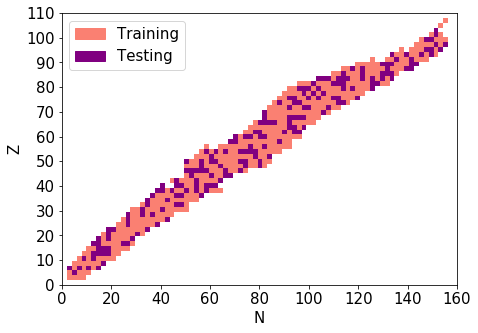

In [1035]:
cmap = ListedColormap(['white','salmon', 'purple'])
Z_range =[0, 110]
N_range = [0, 160]
Zs = np.linspace(start = Z_range[0], stop = Z_range[1], num=int((Z_range[1] - Z_range[0]) / 10) + 1, endpoint=True)
Ns = np.linspace(start = N_range[0], stop = N_range[1], num=int((N_range[1] - N_range[0]) / 20) + 1, endpoint=True)
fig = plt.figure(figsize=(10, 5)) 
plt.rcParams.update({'font.size': 15})
extent=(0,160,0,110)
plt.imshow(np.flip(residuals, axis = 0), extent=extent, cmap=cmap)
plt.xticks(Ns.astype(int))
plt.yticks(np.flip(Zs.astype(int)))
plt.ylabel('Z')
plt.xlabel('N')

# Legend Part
labels = ["Training", "Testing"]
colors = ['salmon', 'purple']
patches =[mpatches.Patch(color=colors[i],label=labels[i]) for i in range(2)]

plt.legend(handles=patches, loc = 'upper left')
plt.savefig('LDM_variants.pdf',dpi=300,bbox_inches='tight')
plt.show()

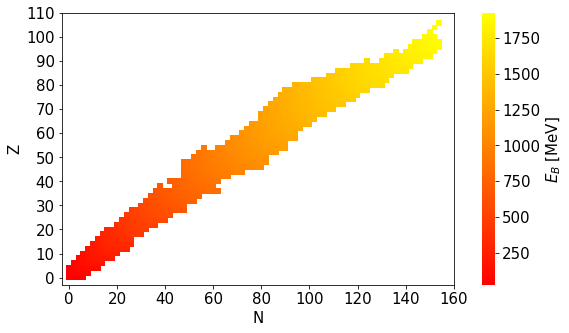

In [1069]:
Z_range =[0, 110]
N_range = [0, 160]
Zs = np.linspace(start = Z_range[0], stop = Z_range[1], num=int((Z_range[1] - Z_range[0]) / 2) + 1, endpoint=True)
Ns = np.linspace(start = N_range[0], stop = N_range[1], num=int((N_range[1] - N_range[0]) / 2) + 1, endpoint=True)
#Zs = np.linspace(start = Z_range[0], stop = Z_range[1], num=int((Z_range[1] - Z_range[0]) / 10) + 1, endpoint=True)
#Ns = np.linspace(start = N_range[0], stop = N_range[1], num=int((N_range[1] - N_range[0]) / 10) + 1, endpoint=True)
data_plot = BE_data[['Z', 'N', 'AME2003', 'BE_per_A']].pivot(index = 'Z', columns = 'N', values = 'AME2003')
fig = plt.figure(figsize=(10, 5)) 
plt.rcParams.update({'font.size': 15})
ax = sns.heatmap(data_plot, cmap = 'autumn',square=True, yticklabels= Zs.astype(float), xticklabels= Ns.astype(float), cbar_kws={'label': r'$E_B$ [MeV]'})
Z_range =[0, 110]
N_range = [0, 160]
ax.set_ylim([-1,50])
ax.set_xlim([-1,80])

Zs_new = np.linspace(start = Z_range[0], stop = Z_range[1], num=int((Z_range[1] - Z_range[0]) / 10) + 1, endpoint=True)
Ns_new = np.linspace(start = N_range[0], stop = N_range[1], num=int((N_range[1] - N_range[0]) / 20) + 1, endpoint=True)
old_ticks = ax.get_xticks()
new_ticks = np.linspace(np.min(old_ticks), np.max(old_ticks), len(Ns_new))
ax.set_xticks(new_ticks)
ax.set_xticklabels(Ns_new.astype(int))
old_ticks = ax.get_yticks()
new_ticks = np.linspace(np.min(old_ticks), np.max(old_ticks), len(Zs_new))
ax.set_yticks(new_ticks)
ax.set_yticklabels(Zs_new.astype(int))
plt.xticks(rotation=0)

for _, spine in ax.spines.items():
    spine.set_visible(True)
#plt.savefig('AME2003.pdf',dpi=300,bbox_inches='tight')
plt.show()

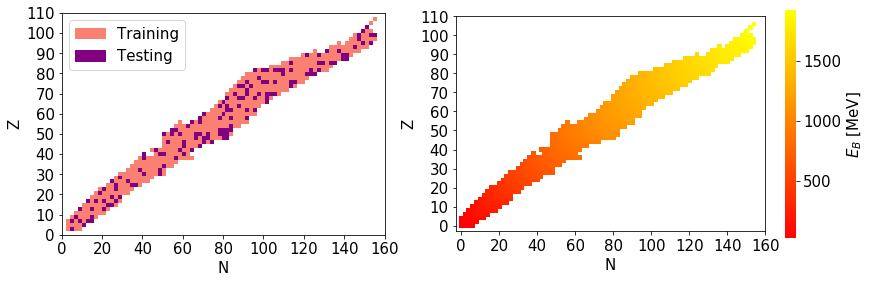

In [1313]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(14,4.2))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1.2])
gs.update(wspace=0.2, hspace=0)
lw = 4

# Test train split
ax0 = plt.subplot(gs[0])

cmap = ListedColormap(['white','salmon', 'purple'])
Z_range =[0, 110]
N_range = [0, 160]
Zs = np.linspace(start = Z_range[0], stop = Z_range[1], num=int((Z_range[1] - Z_range[0]) / 10) + 1, endpoint=True)
Ns = np.linspace(start = N_range[0], stop = N_range[1], num=int((N_range[1] - N_range[0]) / 20) + 1, endpoint=True)
extent=(0,160,0,110)
ax0.imshow(np.flip(residuals, axis = 0), extent=extent, cmap=cmap)
ax0.set_xticks(Ns.astype(int))
ax0.set_yticks(np.flip(Zs.astype(int)))
ax0.set_ylabel('Z')
ax0.set_xlabel('N')

# Legend Part
labels = ["Training", "Testing"]
colors = ['salmon', 'purple']
patches =[mpatches.Patch(color=colors[i],label=labels[i]) for i in range(2)]
ax0.legend(handles=patches, loc = 'upper left')

ax1 = plt.subplot(gs[1])

# Data plot
Z_range =[0, 110]
N_range = [0, 160]
Zs = np.linspace(start = Z_range[0], stop = Z_range[1], num=int((Z_range[1] - Z_range[0]) / 2) + 1, endpoint=True)
Ns = np.linspace(start = N_range[0], stop = N_range[1], num=int((N_range[1] - N_range[0]) / 2) + 1, endpoint=True)
#Zs = np.linspace(start = Z_range[0], stop = Z_range[1], num=int((Z_range[1] - Z_range[0]) / 10) + 1, endpoint=True)
#Ns = np.linspace(start = N_range[0], stop = N_range[1], num=int((N_range[1] - N_range[0]) / 10) + 1, endpoint=True)
data_plot = BE_data[['Z', 'N', 'AME2003', 'BE_per_A']].pivot(index = 'Z', columns = 'N', values = 'AME2003')
ax1 = sns.heatmap(data_plot, cmap = 'autumn',square=True, yticklabels= Zs.astype(float), xticklabels= Ns.astype(float), cbar_kws={'label': r'$E_B$ [MeV]'})
Z_range =[0, 110]
N_range = [0, 160]
ax1.set_ylim([-1,50])
ax1.set_xlim([-1,80])

Zs_new = np.linspace(start = Z_range[0], stop = Z_range[1], num=int((Z_range[1] - Z_range[0]) / 10) + 1, endpoint=True)
Ns_new = np.linspace(start = N_range[0], stop = N_range[1], num=int((N_range[1] - N_range[0]) / 20) + 1, endpoint=True)
old_ticks = ax1.get_xticks()
new_ticks = np.linspace(np.min(old_ticks), np.max(old_ticks), len(Ns_new))
ax1.set_xticks(new_ticks)
ax1.set_xticklabels(Ns_new.astype(int))
old_ticks = ax.get_yticks()
new_ticks = np.linspace(np.min(old_ticks), np.max(old_ticks), len(Zs_new))
ax1.set_yticks(new_ticks)
ax1.set_yticklabels(Zs_new.astype(int))
plt.xticks(rotation=0)

for _, spine in ax1.spines.items():
    spine.set_visible(True)
plt.savefig('AME2003.pdf',dpi=300,bbox_inches='tight')

## Model Fit

In [1115]:
X = LDM_input_matrix(BE_data_train[['Z', 'N', 'AME2003', 'BE_per_A']])
##### Least squares fit of LDM
X_design = np.matrix(X)
X_design[:,1:] =  - X_design[:,1:] # This is to get correct LDM parametrization
# Parameter estimates
Beta = np.dot(np.dot(np.linalg.inv(np.dot(X_design.T, X_design)), X_design.T), np.matrix(BE_data_train.AME2003.values[:,None]))
print("a_vol, a_surf, a_sym, a_C, = " + str(Beta.flatten()))
# Parameter standard error estimates
Sigma_err = np.sqrt(np.sum((np.array(X_design * Beta).flatten() - BE_data_train["AME2003"].values) ** 2) / (X.shape[0] - 4))
sigma = np.linalg.inv(np.dot(X_design.T, X_design))* Sigma_err ** 2
param_std = np.sqrt(np.diag(sigma))
print("standard error of parameters: " + str(np.sqrt(np.diag(sigma))))

a_vol, a_surf, a_sym, a_C, = [[15.13956262 15.9263961  21.99517799  0.67722669]]
standard error of parameters: [0.05801709 0.18202121 0.14933177 0.00407849]


Root MSE with an outlier present: 4.096474706043126


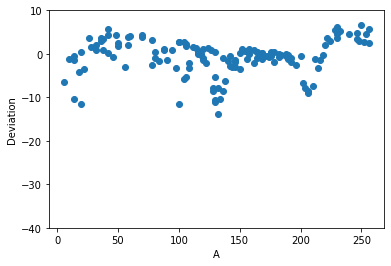

Root MSE without an outlier present: 4.096474706043126


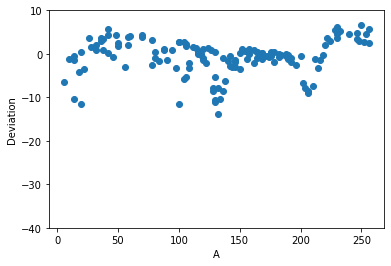

In [1116]:
##### Root MSE of the Least Squares fit
X = LDM_input_matrix(BE_data_test[['Z', 'N', 'AME2003', 'BE_per_A']])
X_design = np.matrix(X)
X_design[:,1:] =  - X_design[:,1:]
print("Root MSE with an outlier present: " + str(np.sqrt(np.mean((np.array(X_design * Beta).flatten() - BE_data_test["AME2003"].values) ** 2))))
# It turns out, there is one large outliers in the training dataset
plt.scatter(BE_data_test["Z"] + BE_data_test["N"], np.array(X_design * Beta).flatten() - BE_data_test["AME2003"].values)
plt.ylabel("Deviation")
plt.xlabel("A")
plt.ylim([-40,10])
plt.show()
# To mitigate the leverage of this nucleus, we remove it from the testing dataset
ind = np.abs(np.array(X_design * Beta).flatten() - BE_data_test["AME2003"].values) <20 # This removes the nucleus
print("Root MSE without an outlier present: " + str(np.sqrt(np.mean((np.array(X_design * Beta).flatten()[ind] - BE_data_test["AME2003"].values[ind]) ** 2))))
# It turns out, there is one large outliers in the training dataset
plt.scatter(BE_data_test["Z"][ind] + BE_data_test["N"][ind], np.array(X_design * Beta).flatten()[ind] - BE_data_test["AME2003"].values[ind])
plt.ylabel("Deviation")
plt.xlabel("A")
plt.ylim([-40,10])
plt.show()

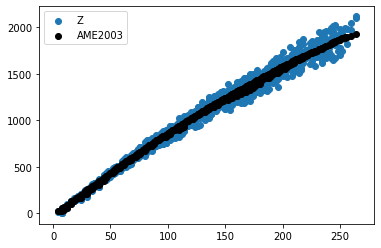

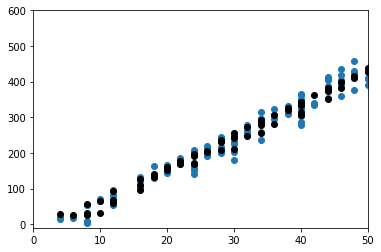

In [1117]:
# Generating model runs
np.random.seed(0)
tf.random.set_seed(0)
n_m = 900
n_obs = len(BE_data_train)
lims = np.concatenate([np.array((- param_std * 10 +  Beta.flatten()).T), np.array((param_std * 10 +  Beta.flatten()).T)], axis = 1)
input_m_theta = input_locations(4, n_m, lims=lims, criterion = "c")
input_Z_N = BE_data_train[["Z", "N"]].values.astype(float)
input_Z_N = np.repeat(input_Z_N, repeats=2, axis=0)
np.random.shuffle(input_Z_N)
input_obs = BE_data_train[["Z","N"]].values.astype(float)

#Plot of the model runs
X = LDM_input_matrix(pd.DataFrame(input_Z_N, columns=["Z", "N"]))
X[:,1:] =  - X[:,1:]
Z = np.sum(X * input_m_theta, axis = 1)
index = Z > 0 # We need to remove values that give non-physical Binding energies
Z = Z[index]
n_m = len(Z)
input_Z_N = input_Z_N[index,:]
input_m_theta = input_m_theta[index, :]
input_m = np.concatenate([input_Z_N, input_m_theta], axis = 1)
plt.scatter(np.sum(input_Z_N, axis = 1), Z, label = "Z")
plt.scatter(BE_data_train["Z"] + BE_data_train["N"], BE_data_train["AME2003"], color = 'k', label = "AME2003")
plt.legend()
plt.show()
plt.scatter(np.sum(input_Z_N, axis = 1), Z)
plt.scatter(BE_data_train["Z"] + BE_data_train["N"], BE_data_train["AME2003"], color = 'k')
plt.xlim([0,50])
plt.ylim([-10,600])
plt.show()

In [1118]:
# Data preprocessing

# This should be independent from any GP specification
# index generating
d_input = 2
theta_dim = 4
Y = BE_data_train["AME2003"].values[:,None]
Z = Z[:, None]
Y_index = np.array([i + 1 for i in range(len(Y))])[:,None]
Z_index = np.array([i + 1 + len(Y) for i in range(len(Z))])[:,None]

# Response conc index
Y_input = np.concatenate((Y_index, np.array([1] * len(Y))[:,None], Y), axis = 1)
Z_input = np.concatenate((Z_index, np.array([0] * len(Z))[:, None], Z), axis = 1)
Response_input = np.concatenate((Y_input, Z_input), axis = 0)

# Input values X
Y_X = np.concatenate((Y_index, input_obs), axis = 1)
Z_X = np.concatenate((Z_index, input_m[:,:d_input]), axis = 1)
X_input = np.concatenate((Y_X, Z_X))

#######################################
# Here is where the whole algorithm should start for optimization


########### This will be done in each stap of the sampling procedure
# Input values theta
#theta_variational = np.random.multivariate_normal(mean = mean_theta, cov = cov_theta)
theta_variational = np.array(Beta).flatten()
theta_variational = np.repeat(theta_variational, len(Y))
theta_variational = theta_variational.reshape((len(Y),theta_dim), order='F')

Y_theta = np.concatenate((Y_index, theta_variational), axis = 1)
Z_theta = np.concatenate((Z_index, input_m[:,d_input:]), axis = 1)
Theta_input = np.concatenate((Y_theta, Z_theta))

# Data input for 
data_input = {"Response": Response_input, "X": X_input, "Theta": Theta_input}

# Bijection
n = n_m + n_obs

#k = np.random.randint(1, bijection_domain)
#i, j = bijection_array(k, n, l)

with open("AME2003_" + str(n_obs) + '_' + str(n_m) + '.pickle', 'wb') as handle:
    pkl.dump(data_input, handle, protocol=pkl.HIGHEST_PROTOCOL)

In [1119]:
input_obs_sorted_index = np.lexsort(np.rot90(input_obs))
input_obs_sorted_index = np.argsort(Y.flatten())
s_hat = sigma_estimate(Y.flatten(), input_obs_sorted_index)
print(s_hat)

3.984654447541638


### MCMC Fit

In [78]:
d_input = 2
theta_input = 4
tf.random.set_seed(123)
np.random.seed(123)
#prior_type = sys.argv[1]
prior_type = "new"
# Preprocessing input
def observations_scale(x):
    return x[:, -1]

# Preprocessing all the shared data
obs_indicator = data_input["Response"][:,1][:,None]
X_obs_indicator = np.concatenate([data_input["X"][:,1:], obs_indicator], axis = 1)
X_shared = theano.shared(data_input["X"][:,1:])
theta_model_shared = theano.shared(input_m[:,d_input:])
sampler_type = "MH" # "MH" or "NUTS"
n_tune = 50 # Number of tuning samples
n_sample = 50 # Number of effective samples

# Means specification
##### Means definition
model_hyperparameters = {"Beta": float(1)}
delta_hyperparameters = {"Beta": float(1)}

f_mean_init = model_mean(model_hyperparameters)
delta_mean_init = delta_mean(delta_hyperparameters)

means = {"f": f_mean_init.zero, "delta": delta_mean_init.zero }
# Priors definition
if prior_type == "new":
    priors_dictionary ={"theta": [np.array(Beta).flatten(), np.sqrt(np.diag(sigma)) * 7.5, 4],
                       "sigma": [2, 1, 1],
                       "kernel_f_l": [10, 1, 6],
                       "kernel_f_eta": [110, 1/10, 1],
                       "kernel_delta_l": [10, 1, 2],
                       "kernel_delta_eta": [10, 1, 1]}
elif prior_type == "old":
    priors_dictionary ={"theta": [np.array([15.42, 16.91, 22.47, 0.69]), np.array([0.203, 0.645, 0.525, 0.015]), 4],
                       "sigma": [2, 1, 1],
                       "kernel_f_l": [10, 1, 6],
                       "kernel_f_eta": [110, 1/10, 1],
                       "kernel_delta_l": [10, 1, 2],
                       "kernel_delta_eta": [10, 1, 1]}


with pm.Model() as full_bayes:
    
    ## Priors definition
    # Theta prior
    theta_random = pm.Normal("theta", mu = priors_dictionary["theta"][0],
                        sd= priors_dictionary["theta"][1],
                        shape =  priors_dictionary["theta"][2])
    
    ## Noise Prior
    noise = pm.Gamma("sigma", alpha = float(priors_dictionary["sigma"][0]),
                     beta = priors_dictionary["sigma"][1])
    
    ### Kernel f hyperparameters priors
    ## length scales
    if priors_dictionary["kernel_f_l"][2]> 1:
        kernel_f_l = pm.Gamma("kernel_f_l", alpha = float(priors_dictionary["kernel_f_l"][0]),
                              beta = float(priors_dictionary["kernel_f_l"][1]),
                              shape = priors_dictionary["kernel_f_l"][2])
    else:
        kernel_f_l = pm.Gamma("kernel_f_l", alpha = float(priors_dictionary["kernel_f_l"][0]),
                          beta = float(priors_dictionary["kernel_f_l"][1]))
    ## eta
    kernel_f_eta = pm.Gamma("kernel_f_eta", alpha = float(priors_dictionary["kernel_f_eta"][0]),
                            beta = float(priors_dictionary["kernel_f_eta"][1]))
    
    ### Kernel delta hyperparameters priors
    ## length scales
    if priors_dictionary["kernel_delta_l"][2]> 1:
        kernel_delta_l = pm.Gamma("kernel_delta_l", alpha = priors_dictionary["kernel_delta_l"][0],
                                  beta = priors_dictionary["kernel_delta_l"][1],
                                  shape = priors_dictionary["kernel_delta_l"][2])
    else:
        kernel_delta_l = pm.Gamma("kernel_delta_l", alpha = np.float(priors_dictionary["kernel_delta_l"][0]),
                              beta = np.float(priors_dictionary["kernel_delta_l"][1]))
    ## eta
    kernel_delta_eta = pm.Gamma("kernel_delta_eta", alpha = float(priors_dictionary["kernel_delta_eta"][0]),
                                beta = float(priors_dictionary["kernel_delta_eta"][1]))
    
    ## Means priors
    if "mean_f" in priors_dictionary:
        if priors_dictionary["mean_f"][2]> 1:
            mean_f = pm.Normal("mean_f", mu = priors_dictionary["mean_f"][0],
                               sd = priors_dictionary["mean_f"][1],
                               shape = priors_dictionary["mean_f"][2])
        else:
            mean_f = pm.Normal("mean_f", mu = float(priors_dictionary["mean_f"][0]),
                               sd = float(priors_dictionary["mean_f"][1]))
            
        
    if "mean_delta" in priors_dictionary:
        if priors_dictionary["mean_delta"][2] > 1:
            mean_delta = pm.Normal("mean_delta", mu = priors_dictionary["mean_delta"][0],
                                   sd = priors_dictionary["mean_delta"][1],
                                   shape = priors_dictionary["mean_delta"][2])
        else:
            mean_delta = pm.Normal("mean_delta", mu = float(priors_dictionary["mean_delta"][0]),
                                   sd = float(priors_dictionary["mean_delta"][1]))
            
            
    # Noise covariance
    cov_noise_base = pm.gp.cov.WhiteNoise(noise)
    cov_noise = pm.gp.cov.ScaledCov(1, cov_func = cov_noise_base, scaling_func = observations_scale)
    
    # Systematic discrepancy covariance
    cov_delta_base = kernel_delta_eta ** 2 * pm.gp.cov.ExpQuad(d_input + 1, ls = kernel_delta_l,
                                                                active_dims = [i for i in range(d_input)])
    
    cov_delta = pm.gp.cov.ScaledCov(d_input + 1, cov_func = cov_delta_base, scaling_func = observations_scale)
    
    #Preprocessing theta
    thetas_variable = tt.concatenate([tt.tile(theta_random, (int(np.sum(obs_indicator)), 1)), theta_model_shared], axis = 0)
    X_thetas_variable = tt.concatenate([X_shared, thetas_variable], axis = 1)
    
    cov_f = kernel_f_eta ** 2 * pm.gp.cov.ExpQuad(d_input + theta_input, ls = kernel_f_l)
    
    # Complete covariance specification
    K = cov_f(X_thetas_variable) + cov_delta(X_obs_indicator) + cov_noise(obs_indicator)
    # Mean definition
    # Mean f
    if "mean_f" in priors_dictionary:
        if means["f"] == "constant":
            mu_f = mean_f * np.ones(len(data_input["Response"]))
        elif means["f"] == "dot_product":
            mu_f = mean_f * tt.diag(tt.dot(data_input["X"][:,1:], thetas_variable.T))
        elif means["f"] == "linear":
            ones_array = theano.shared(np.ones(len(data_input["Response"]))[:, None])
            ones_X_thetas_variable = tt.concatenate([ones_array, X_thetas_variable], axis = 1)
            mu_f = tt.dot(mean_f, ones_X_thetas_variable.T)          
    else:
        if means["f"].__name__ == "zero":
            mu_f = 0 * obs_indicator.flatten()
        elif means["f"].__name__ == "constant":
            mu_f = f_mean_init.hyperparameters["Beta"] * np.ones(len(data_input["Response"]))
        elif means["f"].__name__ == "dot_product":
            mu_f = f_mean_init.hyperparameters["Beta"] * tt.diag(tt.dot(np.concatenate([np.cos(data_input["X"][:,1])[:,None], np.sin(data_input["X"][:,2])[:,None]], axis = 1), thetas_variable.T))
        elif means["f"].__name__ == "linear":
            ones_array = theano.shared(np.ones(len(data_input["Response"]))[:, None])
            ones_X_thetas_variable = tt.concatenate([ones_array, X_thetas_variable], axis = 1)
            mu_f = tt.dot(np.array([f_mean_init.hyperparameters["Intercept"],f_mean_init.hyperparameters["Beta"]]).flatten(),
                          ones_X_thetas_variable.T)  
            
    # Mean delta
    if "mean_delta" in priors_dictionary:
        if means["delta"] == "constant":
            mu_delta = mean_delta * obs_indicator.flatten()
        elif means["delta"] == "linear":
            ones_array = theano.shared(obs_indicator)
            ones_X = tt.concatenate([ones_array, X_shared], axis = 1)
            mu_delta = tt.dot(mean_delta, ones_X.T)  
    else:
        if means["delta"].__name__ == "zero":
            mu_delta = 0 * obs_indicator.flatten()
        elif means["delta"].__name__ == "constant":
            mu_delta = delta_mean_init.hyperparameters["Beta"] * obs_indicator.flatten()
        elif means["delta"].__name__ == "linear":
            ones_array = theano.shared(obs_indicator)
            ones_X = tt.concatenate([ones_array, X_shared], axis = 1)
            mu_delta = tt.dot(np.array([delta_mean_init.hyperparameters["Intercept"],delta_mean_init.hyperparameters["Beta"]]).flatten(),
                              ones_X.T)
            
    mu = mu_f + mu_delta    
    obs = pm.MvNormal('obs', mu = mu, cov = K, observed = data_input["Response"][:,-1])
    if sampler_type == "MH":
        step = pm.Metropolis()
        trace = pm.sample(n_sample, tune= n_tune, chains = 1, step = step, discard_tuned_samples = False)
    #elif sampler_type == "NUTS":
    #    trace = pm.sample(n_sample, tune= n_tune, chains = 1, discard_tuned_samples = False)
    # Saves trace    
    pm.backends.ndarray.save_trace(trace, "trace_LDM_" + prior_type , overwrite=True)

C:\Users\Vojtech\Anaconda3\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
Only 50 samples in chain.
Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [kernel_delta_eta]
>Metropolis: [kernel_delta_l]
>Metropolis: [kernel_f_eta]
>Metropolis: [kernel_f_l]
>Metropolis: [sigma]
>Metropolis: [theta]
Sampling chain 0, 0 divergences: 100%|███████████████████████████████████████████████| 100/100 [03:43<00:00,  2.23s/it]
C:\Users\Vojtech\Anaconda3\lib\site-packages\pymc3\sampling.py:496: UserWarning: The number of samples is too small to check convergence reliably.
  warnings.warn("The number of samples is too small to check convergence reliably.")


In [1207]:
with full_bayes:
    trace = pm.backends.ndarray.load_trace("trace_LDM_new")

In [1219]:
with full_bayes:
    trace = pm.backends.ndarray.load_trace("trace_LDM_old")

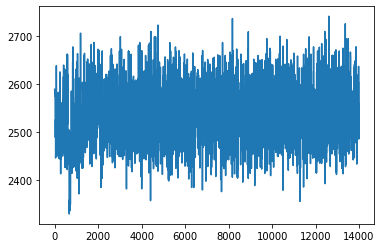

In [1220]:
plt.plot(trace['kernel_f_eta'][1000:])

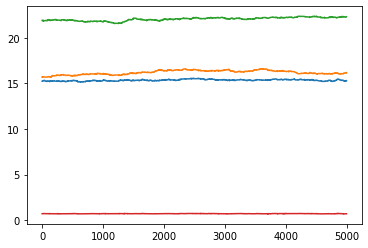

In [1221]:
plt.plot(trace['theta'][10000:])

In [1230]:
np.mean(trace['theta'][7500:], axis = 0)

array([15.320453 , 16.093817 , 22.08721  ,  0.7025908], dtype=float32)

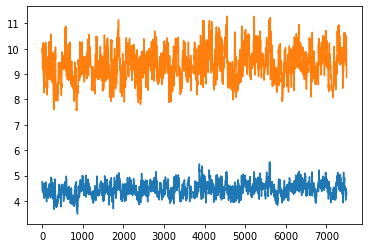

In [1223]:
plt.plot(trace['kernel_delta_l'][7500:])

In [116]:
pm.summary(trace[1000:])

C:\Users\Vojtech\Anaconda3\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils -

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
theta[0],15.380,0.080,15.239,15.540,0.024,0.018,11.0,11.0,11.0,15.0,NaN
theta[1],16.517,0.094,16.315,16.671,0.031,0.023,9.0,9.0,9.0,11.0,NaN
theta[2],22.307,0.049,22.231,22.411,0.014,0.010,12.0,12.0,11.0,42.0,NaN
theta[3],0.700,0.013,0.674,0.722,0.003,0.002,15.0,15.0,15.0,25.0,NaN
sigma,0.575,0.028,0.527,0.629,0.003,0.002,71.0,71.0,66.0,96.0,NaN
kernel_f_l[0],17.039,0.187,16.695,17.297,0.057,0.041,11.0,11.0,12.0,25.0,NaN
kernel_f_l[1],18.854,0.135,18.673,19.138,0.031,0.023,18.0,18.0,25.0,47.0,NaN
kernel_f_l[2],52.650,2.875,48.150,56.047,2.614,2.714,1.0,1.0,1.0,10.0,NaN
kernel_f_l[3],165.229,6.664,156.823,175.590,6.021,6.166,1.0,1.0,1.0,11.0,NaN
kernel_f_l[4],115.879,1.680,113.363,118.428,0.530,0.386,10.0,10.0,12.0,11.0,NaN


In [1224]:
tf.random.set_seed(123)
np.random.seed(123)
input_obs_new = BE_data_test[["Z", "N"]].values
Y_Z = data_input["Response"][:,-1]
Y_test = BE_data_test[["AME2003"]].values.flatten()
means_pred = {"f": "zero", "delta": "zero" }
posterior_samples = gp_mean_cov_Ynew_trace(trace, input_obs_new, input_obs, input_m, d_input, means = means_pred, Y_Z = Y_Z, n_sample = 7500)
print(np.sqrt(np.mean((Y_test - np.mean(posterior_samples, axis = 1))** 2)))

Sample count: 100%|████████████████████████████████████████████████████████████████| 7500/7500 [35:16<00:00,  3.54it/s]

1.161708498502998


### MLE fit

In [191]:
# Finding the hyperparameters - sigma is estimated first
tf.random.set_seed(123)
np.random.seed(123)
d_input = 2
theta_input = 4
means = {"f": "zero", "delta": "zero"}
lkl_class = calibration_likelihood(input_obs, input_m, d_input, theta_input, np.array([1,1,1,1]),
                                   data_input["Response"][:,-1], means, sigma_estimate = s_hat)

# Optimization bounds order: theta, f_l, f_eta, delta_l, delta_eta
lims = np.concatenate([np.array((- param_std * 7.5 +  Beta.flatten()).T), np.array((param_std * 7.5 +  Beta.flatten()).T)], axis = 1)
bounds_L = list(lims[:,0]) + [15] * 3 + [110] * 2 + [5] * 1  + [2200] + [1] * 2 + [10]
bounds_U = list(lims[:,1]) + [55] * 3 + [160] * 2 + [25] * 1 + [2600] + [10] * 2 + [20]
x = np.random.uniform(low = bounds_L, high = bounds_U)
#print(transform(x[theta_input:]))
x[theta_input:] = inv_transform(x[theta_input:])

#bounds_L = -4
#bounds_T = 4
print(x)
#res_hyp = minimize(lkl_class.likelihood_hyper, x, method='TNC', bounds = bounds)
#res_hyp = minimize(lkl_class.loss_MLE, x, method='Powell',tol = 1e-6, options={'disp': True, 'maxiter': 5000})
#res_hyp = minimize(lkl_class.loss_MLE, x, method='Nelder-Mead', tol = 1e-6, options={'disp': True, 'maxiter': 5000})
#res_hyp = minimize(lkl_class.loss_MLE, x, method='BFGS', tol = 1e-6, options={'disp': True, 'maxiter': 1000})
#res_hyp = so.shgo(lkl_class.loss_MLE,bounds=list(zip(lw, up)), options={'disp': True, 'maxiter': 1000})
#res_hyp = so.dual_annealing(lkl_class.loss_MLE,bounds=list(zip(lw, up)), x0 = x, maxiter = 2000, seed =123)
#res_hyp = so.differential_evolution(lkl_class.loss_MLE,bounds=list(zip(lw, up)), maxiter = 2000, seed =123, tol = 0.001)
#res_hyp = minimize(lkl_class.loss_MLE,bounds=list(zip(bounds_L, bounds_U)), x0 =x, method = 'L-BFGS-B', options = {"maxls":20, "maxiter": 2000, "ftol": 1e-9})
res_hyp =minimize(lkl_class.loss_MLE, bounds=list(zip(bounds_L, bounds_U)), x0 =x, method = 'L-BFGS-B', options = {"eps":1.79e-01, "maxiter": 2000, "ftol": 1e-6})
print(res_hyp)
x_new = np.concatenate([res_hyp.x[:4], inv_transform(np.array([s_hat])), res_hyp.x[4:]])
#print(x_new)

[1.53105412e+01 1.53424884e+01 2.13833317e+01 6.80365993e-01
 4.37787588e+01 3.19242584e+01 5.42305679e+01 1.44241487e+02
 1.34046595e+02 1.28423477e+01 2.33727121e+03 7.56092711e+00
 4.94002123e+00 1.05967540e+01]
      fun: 1109.3184635543532
 hess_inv: <14x14 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.93606056e+02,  1.94751097e+00,  4.61551061e+00,  7.95893369e+03,
        2.00043213e-01,  1.38666090e-01, -4.64641258e-02, -5.89484148e-01,
       -5.84102843e-02,  6.24379100e-02, -6.42484402e-02, -1.55481538e+00,
       -2.44236627e+00,  2.85990154e+00])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 2235
      nit: 65
   status: 0
  success: True
        x: array([1.47044344e+01, 1.45612370e+01, 2.08751897e+01, 6.46637997e-01,
       1.68985558e+01, 1.90102317e+01, 5.27218359e+01, 1.60000000e+02,
       1.60000000e+02, 8.49786571e+00, 2.36215289e+03, 1.00000000e+01,
       1.00000000e+01, 1.00000000e+01])


In [1202]:
x_mle = copy.deepcopy(x_new)
x_mle[theta_input:] = transform(x_mle[theta_input:])
x_mle[-1] = 20 
tf.random.set_seed(1)
np.random.seed(1)
d_input = 2
theta_input = 4
M_p, K_p = lkl_class.predictive_likelihood(x_mle, BE_data_test[["Z", "N"]].values)
print(r"$\sqrt{MSE}=$ " + str(np.round(np.sqrt(np.mean((BE_data_test[["AME2003"]].values.flatten() - M_p.flatten()) ** 2)),4)))
M_p_obs, K_p_obs = lkl_class.predictive_likelihood_obs(x_mle, BE_data_test[["Z", "N"]].values)
print(r"$\sqrt{MSE}=$ " + str(np.round(np.sqrt(np.mean((BE_data_test[["AME2003"]].values.flatten() - M_p_obs.flatten()) ** 2)),4)))

$\sqrt{MSE}=$ 1.5692
$\sqrt{MSE}=$ 1.5692


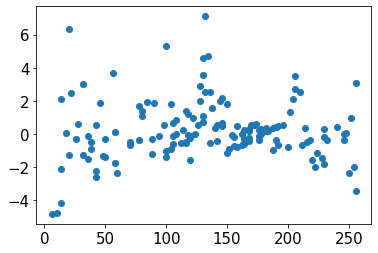

In [1522]:
plt.scatter(BE_data_test["Z"] + BE_data_test["N"] ,BE_data_test[["AME2003"]].values.flatten() - M_p.flatten())

In [1422]:
with open("MLE_fit_2_" + "AME" + '.pickle', 'wb') as handle:
    pkl.dump({"x": x_new, "M": M_p, "K":K_p, "M_o": M_p_obs, "K_o":K_p_obs}, handle, protocol=pkl.HIGHEST_PROTOCOL)

In [1358]:
input_m

array([[ 10.        ,  12.        ,  15.04737991,  15.24078288,
         20.88514519,   0.64935699],
       [ 58.        ,  70.        ,  15.26526632,  16.35717962,
         23.41051128,   0.65216662],
       [ 92.        , 136.        ,  15.11055408,  14.50460821,
         21.34309594,   0.68561026],
       ...,
       [ 22.        ,  28.        ,  14.98936282,  15.71808293,
         21.55879738,   0.66911502],
       [ 76.        , 112.        ,  15.22400972,  15.16797439,
         21.15726086,   0.68615406],
       [ 66.        ,  98.        ,  15.44963174,  15.60887021,
         22.06984387,   0.68932622]])

### CV fit

In [1165]:
tf.random.set_seed(123)
np.random.seed(123)
d_input = 2
theta_input = 4
means = {"f": "zero", "delta": "zero"}
lkl_class = calibration_likelihood(input_obs = input_obs, input_m = input_m, d_input = d_input, theta_input =theta_input, theta_truth = np.array([1,1,1,1]),
                 Y_Z = data_input["Response"][:,-1], means = means, CV_k=10, sigma_estimate = s_hat)

# Optimization bounds order: theta, f_l, f_eta, delta_l, delta_eta
#bounds_L = list(lims[:,0]) + [10] * 6 + [900] + [1] * 2 + [1]
#bounds_U = list(lims[:,1]) + [40] * 6 + [1200] + [20] * 2 + [10]
lims = np.concatenate([np.array((- param_std * 7.5 +  Beta.flatten()).T), np.array((param_std * 7.5 +  Beta.flatten()).T)], axis = 1)
bounds_L = list(lims[:,0]) + [15] * 3 + [110] * 2 + [5] * 1  + [2200] + [1] * 2 + [10]
bounds_U = list(lims[:,1]) + [55] * 3 + [160] * 2 + [25] * 1 + [2600] + [10] * 2 + [20]
x = np.random.uniform(low = bounds_L, high = bounds_U)
#print(transform(x[theta_input:]))
x[theta_input:] = inv_transform(x[theta_input:])

#bounds_L = -4
#bounds_T = 4
print(x)
#res_hyp = minimize(lkl_class.likelihood_hyper, x, method='TNC', bounds = bounds)
#res_hyp = minimize(lkl_class.loss_MLE, x, method='Powell',tol = 1e-6, options={'disp': True, 'maxiter': 5000})
#res_hyp = minimize(lkl_class.loss_MLE, x, method='Nelder-Mead', tol = 1e-6, options={'disp': True, 'maxiter': 5000})
#res_hyp = minimize(lkl_class.loss_MLE, x, method='BFGS', tol = 1e-6, options={'disp': True, 'maxiter': 1000})
#res_hyp = so.shgo(lkl_class.loss_MLE,bounds=list(zip(lw, up)), options={'disp': True, 'maxiter': 1000})
#res_hyp = so.dual_annealing(lkl_class.loss_MLE,bounds=list(zip(lw, up)), x0 = x, maxiter = 2000, seed =123)
#res_hyp = so.differential_evolution(lkl_class.loss_MLE,bounds=list(zip(lw, up)), maxiter = 2000, seed =123, tol = 0.001)
#res_hyp = minimize(lkl_class.loss_MLE,bounds=list(zip(bounds_L, bounds_U)), xsq0 =x, method = 'L-BFGS-B', options = {"maxls":20, "maxiter": 2000, "ftol": 1e-9})
res_hyp =minimize(lkl_class.loss_CV, bounds=list(zip(bounds_L, bounds_U)), x0 =x, method = 'SLSQP', options = {"eps":1.5e-01, "maxiter": 2000, "ftol": 1e-9})
print(res_hyp)
x_new = np.concatenate([res_hyp.x[:4], inv_transform(np.array([s_hat])), res_hyp.x[4:]])
#print(x_new)

[1.53105412e+01 1.53424884e+01 2.13833317e+01 6.80365993e-01
 4.37787588e+01 3.19242584e+01 5.42305679e+01 1.44241487e+02
 1.34046595e+02 1.28423477e+01 2.33727121e+03 7.56092711e+00
 4.94002123e+00 1.05967540e+01]
     fun: 1137.3369217932038
     jac: array([ 1.29202673e+05, -8.95594697e+02,  3.58434011e+03,  1.79813408e+03,
        3.86305894e+03, -1.01713717e+03, -5.03285502e+02,  1.09875058e+03,
        6.96054099e+02,  1.29807056e+06, -9.00791061e+02,  1.30159316e+04,
       -5.36292012e+02, -9.63897124e+02])
 message: 'Optimization terminated successfully.'
    nfev: 42
     nit: 6
    njev: 2
  status: 0
 success: True
       x: array([1.53104291e+01, 1.53423440e+01, 2.13832377e+01, 6.80359758e-01,
       4.37779852e+01, 3.19211295e+01, 5.42233150e+01, 1.44235156e+02,
       1.34042149e+02, 1.28408978e+01, 2.33724583e+03, 7.55971413e+00,
       4.93929280e+00, 1.05966436e+01])


In [1206]:
x_cv = copy.deepcopy(x_new)
x_cv[theta_input:] = transform(x_cv[theta_input:])
#x_cv[-1] = 20
print(x_cv)
tf.random.set_seed(1)
np.random.seed(1)
d_input = 2
theta_input = 4
M_p, K_p = lkl_class.predictive_likelihood(x_cv, BE_data_test[["Z", "N"]].values)
print(np.sum(M_p.flatten()))
print(r"$\sqrt{MSE}=$ " + str(np.round(np.sqrt(np.mean((BE_data_test[["AME2003"]].values.flatten() - M_p.flatten()) ** 2)),4)))
M_p_obs, K_p_obs = lkl_class.predictive_likelihood_obs(x_cv, BE_data_test[["Z", "N"]].values)
print(r"$\sqrt{MSE}=$ " + str(np.round(np.sqrt(np.mean((BE_data_test[["AME2003"]].values.flatten() - M_p_obs.flatten()) ** 2)),4)))

[1.53104291e+01 1.53423440e+01 2.13832377e+01 6.80359758e-01
 3.98465445e+00 4.37779852e+01 3.19211295e+01 5.42233150e+01
 1.44235156e+02 1.34042149e+02 1.28409005e+01 2.33724583e+03
 7.56023502e+00 4.94642695e+00 1.05966686e+01]
156269.6171875
$\sqrt{MSE}=$ 1.895
$\sqrt{MSE}=$ 1.895


In [1151]:
x_cv[-1]

20.596778966095684

In [ ]:
plt.scatter(BE_data_test["Z"] + BE_data_test["N"] ,BE_data_test[["AME2003"]].values.flatten() - M_p.flatten())

In [ ]:
with open("MLE_fit_" + "AME" + '.pickle', 'wb') as handle:
    pkl.dump({"x": x_new, "M": M_p, "K":K_p, "M_o": M_p_obs, "K_o":K_p_obs}, handle, protocol=pkl.HIGHEST_PROTOCOL)

### Results

In [1530]:
for optim in ["BF", "SL"]:
    for eps in ["1e-5", "1e-4", "1e-3", "1e-2" "1e-1", "1.5e-1", "1.56e-1", "1.57e-1", "1.58e-1", "1.59e-1", "1.60e-1", "1.65e-1", "1.675e-1", "1.70e-1",
                "1.71e-1", "1.72e-1", "1.73e-1", "1.74e-1","1.75e-1", "1.76e-1", "1.77e-1", "1.78e-1", "1.79e-1",
                "1.8e-1", "1.85e-1", "1.9e-1", "1.95e-1", "2e-1", "2.25e-1", "2.5e-1", "2.75e-1", "3e-1", ]:
        for tol in ["1e-9", "1e-12", "1e-16"]:        
            print("CV_fit_eps_" + eps + "_tol_" + tol + "AME_" + optim)
            #with open("AME_application/CV_fit_eps_" + eps + "_tol_" + tol + "AME_" + optim+ '.pickle', 'rb') as handle:
                #cv = pkl.load(handle)
                
            #print(r"$\sqrt{MSE}=$ " + str(np.round(np.sqrt(np.mean((BE_data_test[["AME2003"]].values.flatten() - cv["M_o"].flatten()) ** 2)),4)))
                
            try:
                with open("AME_application/CV_fit_eps_" + eps + "_tol_" + tol + "AME_" + optim+ '.pickle', 'rb') as handle:
                    cv = pkl.load(handle)
                #print("load succesfull")
                print("theta: " + str(cv["x"][:4]))
                print(r"$\sqrt{MSE}=$ " + str(np.round(np.sqrt(np.mean((BE_data_test[["AME2003"]].values.flatten() - cv["M_o"].flatten()) ** 2)),4)))
            except:
                print("not found")
                
            

CV_fit_eps_1e-5_tol_1e-9AME_BF
theta: [15.36753851 15.14782966 21.17942907  0.68141195]
$\sqrt{MSE}=$ 8.3087
CV_fit_eps_1e-5_tol_1e-12AME_BF
theta: [15.36753851 15.14782966 21.17942907  0.68141195]
$\sqrt{MSE}=$ 8.3087
CV_fit_eps_1e-5_tol_1e-16AME_BF
theta: [15.36753851 15.14782966 21.17942907  0.68141195]
$\sqrt{MSE}=$ 8.3087
CV_fit_eps_1e-4_tol_1e-9AME_BF
theta: [15.36762195 15.14743349 21.17972092  0.68144236]
$\sqrt{MSE}=$ 8.2981
CV_fit_eps_1e-4_tol_1e-12AME_BF
theta: [15.36762195 15.14743349 21.17972092  0.68144236]
$\sqrt{MSE}=$ 8.2981
CV_fit_eps_1e-4_tol_1e-16AME_BF
theta: [15.36762195 15.14743349 21.17972092  0.68144236]
$\sqrt{MSE}=$ 8.2981
CV_fit_eps_1e-3_tol_1e-9AME_BF
theta: [15.11188929 14.81681165 21.91212371  0.69305818]
$\sqrt{MSE}=$ 2.2312
CV_fit_eps_1e-3_tol_1e-12AME_BF
theta: [15.11188929 14.81681165 21.91212371  0.69305818]
$\sqrt{MSE}=$ 2.2312
CV_fit_eps_1e-3_tol_1e-16AME_BF
theta: [15.11188929 14.81681165 21.91212371  0.69305818]
$\sqrt{MSE}=$ 2.2312
CV_fit_eps_1e

$\sqrt{MSE}=$ 1.4883
CV_fit_eps_1.5e-1_tol_1e-16AME_SL
theta: [14.58972133 14.5199196  20.63266339  0.63644509]
$\sqrt{MSE}=$ 1.4883
CV_fit_eps_1.56e-1_tol_1e-9AME_SL
theta: [14.55939263 14.10618402 20.50190717  0.63644177]
$\sqrt{MSE}=$ 1.7287
CV_fit_eps_1.56e-1_tol_1e-12AME_SL
theta: [14.55949806 14.34151581 20.50272817  0.63644316]
$\sqrt{MSE}=$ 1.7303
CV_fit_eps_1.56e-1_tol_1e-16AME_SL
theta: [14.55939727 14.2235144  20.50822567  0.63664477]
$\sqrt{MSE}=$ 1.5664
CV_fit_eps_1.57e-1_tol_1e-9AME_SL
theta: [14.7202716  14.9525846  20.99227006  0.6462675 ]
$\sqrt{MSE}=$ 1.7949
CV_fit_eps_1.57e-1_tol_1e-12AME_SL
theta: [14.59759598 14.65195732 21.00148349  0.63644178]
$\sqrt{MSE}=$ 1.7994
CV_fit_eps_1.57e-1_tol_1e-16AME_SL
theta: [14.55939171 14.1818461  20.50186057  0.63644222]
$\sqrt{MSE}=$ 1.5611
CV_fit_eps_1.58e-1_tol_1e-9AME_SL
theta: [14.67589702 15.01701871 20.57548773  0.63644185]
$\sqrt{MSE}=$ 1.6552
CV_fit_eps_1.58e-1_tol_1e-12AME_SL
theta: [14.65726237 15.01642094 20.56417782 

In [1532]:
for optim in ["BF", "SL"]:
    for eps in ["1e-5", "1e-4", "1e-3", "1e-2" "1e-1", "1.5e-1", "1.56e-1", "1.57e-1", "1.58e-1", "1.59e-1", "1.60e-1", "1.65e-1", "1.675e-1", "1.70e-1",
                "1.71e-1", "1.72e-1", "1.73e-1", "1.74e-1","1.75e-1", "1.76e-1", "1.77e-1", "1.78e-1", "1.79e-1",
                "1.8e-1", "1.85e-1", "1.9e-1", "1.95e-1", "2e-1", "2.25e-1", "2.5e-1", "2.75e-1", "3e-1", ]:
        for tol in ["1e-9", "1e-12", "1e-16"]:        
            print("CV_fit_eps_" + eps + "_tol_" + tol + "AME_" + optim)
            #with open("AME_application/CV_fit_eps_" + eps + "_tol_" + tol + "AME_" + optim+ '.pickle', 'rb') as handle:
                #cv = pkl.load(handle)
                
            #print(r"$\sqrt{MSE}=$ " + str(np.round(np.sqrt(np.mean((BE_data_test[["AME2003"]].values.flatten() - cv["M_o"].flatten()) ** 2)),4)))
                
            try:
                with open("AME_application/MLE_fit_eps_" + eps + "_tol_" + tol + "AME_" + optim+ '.pickle', 'rb') as handle:
                    cv = pkl.load(handle)
                #print("load succesfull")
                print("theta: " + str(cv["x"][:4]))
                print(r"$\sqrt{MSE}=$ " + str(np.round(np.sqrt(np.mean((BE_data_test[["AME2003"]].values.flatten() - cv["M_o"].flatten()) ** 2)),4)))
            except:
                print("not found")
                
            

CV_fit_eps_1e-5_tol_1e-9AME_BF
theta: [14.73756516 14.72243651 20.68016802  0.65060216]
$\sqrt{MSE}=$ 1.677
CV_fit_eps_1e-5_tol_1e-12AME_BF
theta: [14.73756516 14.72243651 20.68016802  0.65060216]
$\sqrt{MSE}=$ 1.677
CV_fit_eps_1e-5_tol_1e-16AME_BF
theta: [14.73756516 14.72243651 20.68016802  0.65060216]
$\sqrt{MSE}=$ 1.677
CV_fit_eps_1e-4_tol_1e-9AME_BF
theta: [14.55939171 14.10618401 20.50186033  0.64119973]
$\sqrt{MSE}=$ 2.1613
CV_fit_eps_1e-4_tol_1e-12AME_BF
theta: [14.55939171 14.10618401 20.50186033  0.64119973]
$\sqrt{MSE}=$ 2.1613
CV_fit_eps_1e-4_tol_1e-16AME_BF
theta: [14.55939171 14.10618401 20.50186033  0.64119973]
$\sqrt{MSE}=$ 2.1613
CV_fit_eps_1e-3_tol_1e-9AME_BF
theta: [14.58459013 14.2309752  20.50186033  0.63950941]
$\sqrt{MSE}=$ 1.9847
CV_fit_eps_1e-3_tol_1e-12AME_BF
theta: [14.55939171 14.18412482 20.50186033  0.63662941]
$\sqrt{MSE}=$ 1.9743
CV_fit_eps_1e-3_tol_1e-16AME_BF
theta: [14.55939171 14.18412482 20.50186033  0.63662941]
$\sqrt{MSE}=$ 1.9743
CV_fit_eps_1e-21

theta: [14.55939171 14.1854246  20.50186033  0.63644177]
$\sqrt{MSE}=$ 1.7977
CV_fit_eps_1e-3_tol_1e-16AME_SL
theta: [14.55939171 14.18543529 20.50186033  0.63644177]
$\sqrt{MSE}=$ 1.7977
CV_fit_eps_1e-21e-1_tol_1e-9AME_SL
not found
CV_fit_eps_1e-21e-1_tol_1e-12AME_SL
not found
CV_fit_eps_1e-21e-1_tol_1e-16AME_SL
not found
CV_fit_eps_1.5e-1_tol_1e-9AME_SL
theta: [14.55939171 14.13532606 20.50237765  0.63644177]
$\sqrt{MSE}=$ 2.0422
CV_fit_eps_1.5e-1_tol_1e-12AME_SL
theta: [14.55939171 14.13532606 20.50237765  0.63644177]
$\sqrt{MSE}=$ 2.0422
CV_fit_eps_1.5e-1_tol_1e-16AME_SL
theta: [14.55939171 14.13532606 20.50237765  0.63644177]
$\sqrt{MSE}=$ 2.0422
CV_fit_eps_1.56e-1_tol_1e-9AME_SL
theta: [14.55941493 14.11898428 20.50336023  0.63644177]
$\sqrt{MSE}=$ 1.9917
CV_fit_eps_1.56e-1_tol_1e-12AME_SL
theta: [14.55941493 14.11898428 20.50336023  0.63644177]
$\sqrt{MSE}=$ 1.9917
CV_fit_eps_1.56e-1_tol_1e-16AME_SL
theta: [14.55941493 14.11898428 20.50336023  0.63644177]
$\sqrt{MSE}=$ 1.9917
CV

In [1187]:
for optim in ["BF", "SL"]:
    for eps in ["1e-5", "1.5e-5", "1e-4", "1.4e-4", "1e-3", "1e-2" "1e-1", "1.48e-1", "1.5e-1", "1.52e-1", "1.56e-1", "1.57e-1", "1.58e-1", "1.59e-1", "1.60e-1", "1.65e-1", "1.675e-1", "1.70e-1",
                "1.71e-1", "1.72e-1", "1.73e-1", "1.74e-1","1.75e-1", "1.76e-1", "1.77e-1", "1.78e-1", "1.79e-1",
                "1.8e-1", "1.85e-1", "1.9e-1", "1.95e-1", "2e-1", "2.25e-1", "2.5e-1", "2.75e-1", "3e-1"]:
        for tol in ["1e-6", "1e-9", "1e-12"]:        
            print("CV_fit_eps_" + eps + "_tol_" + tol + "AME_" + optim)
            #with open("AME_application/CV_fit_eps_" + eps + "_tol_" + tol + "AME_" + optim+ '.pickle', 'rb') as handle:
                #cv = pkl.load(handle)
                
            #print(r"$\sqrt{MSE}=$ " + str(np.round(np.sqrt(np.mean((BE_data_test[["AME2003"]].values.flatten() - cv["M_o"].flatten()) ** 2)),4)))
                
            try:
                with open("AME_application/2200_final/MLE_fit_eps_" + eps + "_tol_" + tol + "AME_" + optim+ '.pickle', 'rb') as handle:
                    cv = pkl.load(handle)
                #print("load succesfull")
                print("theta: " + str(cv["x"][:4]))
                print(r"$\sqrt{MSE}=$ " + str(np.round(np.sqrt(np.mean((BE_data_test[["AME2003"]].values.flatten() - cv["M_o"].flatten()) ** 2)),4)))
            except:
                print("not found")
                
           

CV_fit_eps_1e-5_tol_1e-6AME_BF
theta: [14.88163524 15.37128594 21.62937622  0.66116771]
$\sqrt{MSE}=$ 1.5217
CV_fit_eps_1e-5_tol_1e-9AME_BF
theta: [14.88163524 15.37128594 21.62937622  0.66116771]
$\sqrt{MSE}=$ 1.5215
CV_fit_eps_1e-5_tol_1e-12AME_BF
theta: [14.88163524 15.37128594 21.62937622  0.66116771]
$\sqrt{MSE}=$ 1.5215
CV_fit_eps_1.5e-5_tol_1e-6AME_BF
theta: [14.74038331 14.56164407 20.89892677  0.65381689]
$\sqrt{MSE}=$ 1.0083
CV_fit_eps_1.5e-5_tol_1e-9AME_BF
theta: [14.70443444 14.56123705 20.88437674  0.64913446]
$\sqrt{MSE}=$ 1.0281
CV_fit_eps_1.5e-5_tol_1e-12AME_BF
theta: [14.70443444 14.56123705 20.88437674  0.64913446]
$\sqrt{MSE}=$ 1.0281
CV_fit_eps_1e-4_tol_1e-6AME_BF
theta: [15.22996847 16.43924321 22.96171533  0.673869  ]
$\sqrt{MSE}=$ 1.1909
CV_fit_eps_1e-4_tol_1e-9AME_BF
theta: [15.06978576 15.5841001  22.00444894  0.67570479]
$\sqrt{MSE}=$ 1.1594
CV_fit_eps_1e-4_tol_1e-12AME_BF
theta: [15.06978576 15.5841001  22.00444894  0.67570479]
$\sqrt{MSE}=$ 1.1594
CV_fit_eps

$\sqrt{MSE}=$ 1.4597
CV_fit_eps_3e-1_tol_1e-12AME_BF
theta: [14.70443444 14.56123703 20.87518974  0.646638  ]
$\sqrt{MSE}=$ 1.4597
CV_fit_eps_1e-5_tol_1e-6AME_SL
theta: [15.30818532 15.33993658 21.38797771  0.68019428]
$\sqrt{MSE}=$ 1.9245
CV_fit_eps_1e-5_tol_1e-9AME_SL
theta: [15.30818532 15.33993658 21.38797771  0.68019428]
$\sqrt{MSE}=$ 1.9245
CV_fit_eps_1e-5_tol_1e-12AME_SL
theta: [15.30818532 15.33993658 21.38797771  0.68019428]
$\sqrt{MSE}=$ 1.9245
CV_fit_eps_1.5e-5_tol_1e-6AME_SL
theta: [15.30649084 15.34837735 21.38995639  0.68008798]
$\sqrt{MSE}=$ 2.9495
CV_fit_eps_1.5e-5_tol_1e-9AME_SL
theta: [15.30649084 15.34837735 21.38995639  0.68008798]
$\sqrt{MSE}=$ 2.9495
CV_fit_eps_1.5e-5_tol_1e-12AME_SL
theta: [15.30649084 15.34837735 21.38995639  0.68008798]
$\sqrt{MSE}=$ 2.9495
CV_fit_eps_1e-4_tol_1e-6AME_SL
theta: [14.969286   15.58674408 22.19454043  0.65746706]
$\sqrt{MSE}=$ 1.5152
CV_fit_eps_1e-4_tol_1e-9AME_SL
theta: [14.96959739 15.58696055 22.19418764  0.65732703]
$\sqrt{MSE

In [1225]:
for optim in ["BF", "SL"]:
    for eps in ["1e-5", "1.5e-5", "1e-4", "1.4e-4", "1e-3", "1e-2" "1e-1", "1.48e-1", "1.5e-1", "1.52e-1", "1.56e-1", "1.57e-1", "1.58e-1", "1.59e-1", "1.60e-1", "1.65e-1", "1.675e-1", "1.70e-1",
                "1.71e-1", "1.72e-1", "1.73e-1", "1.74e-1","1.75e-1", "1.76e-1", "1.77e-1", "1.78e-1", "1.79e-1",
                "1.8e-1", "1.85e-1", "1.9e-1", "1.95e-1", "2e-1", "2.25e-1", "2.5e-1", "2.75e-1", "3e-1"]:
        for tol in ["1e-6", "1e-9", "1e-12"]:        
            print("CV_fit_eps_" + eps + "_tol_" + tol + "AME_" + optim)
            #with open("AME_application/CV_fit_eps_" + eps + "_tol_" + tol + "AME_" + optim+ '.pickle', 'rb') as handle:
                #cv = pkl.load(handle)
                
            #print(r"$\sqrt{MSE}=$ " + str(np.round(np.sqrt(np.mean((BE_data_test[["AME2003"]].values.flatten() - cv["M_o"].flatten()) ** 2)),4)))
                
            try:
                with open("AME_application/2200_final/CV_fit_eps_" + eps + "_tol_" + tol + "AME_" + optim+ '.pickle', 'rb') as handle:
                    cv = pkl.load(handle)
                #print("load succesfull")
                print("theta: " + str(cv["x"][:4]))
                print(r"$\sqrt{MSE}=$ " + str(np.round(np.sqrt(np.mean((BE_data_test[["AME2003"]].values.flatten() - cv["M_o"].flatten()) ** 2)),4)))
            except:
                print("not found")
                
           

CV_fit_eps_1e-5_tol_1e-6AME_BF
theta: [15.31054146 15.34249048 21.38333347  0.68036602]
$\sqrt{MSE}=$ 1.9253
CV_fit_eps_1e-5_tol_1e-9AME_BF
theta: [15.3105412  15.34248844 21.38333178  0.68036598]
$\sqrt{MSE}=$ 1.8503
CV_fit_eps_1e-5_tol_1e-12AME_BF
theta: [15.31054146 15.34249048 21.38333347  0.68036602]
$\sqrt{MSE}=$ 1.9253
CV_fit_eps_1.5e-5_tol_1e-6AME_BF
theta: [15.31054118 15.34248844 21.38333167  0.68036599]
$\sqrt{MSE}=$ 2.1207
CV_fit_eps_1.5e-5_tol_1e-9AME_BF
theta: [15.31054118 15.34248844 21.38333167  0.68036599]
$\sqrt{MSE}=$ 2.1207
CV_fit_eps_1.5e-5_tol_1e-12AME_BF
theta: [15.31054118 15.34248844 21.38333167  0.68036599]
$\sqrt{MSE}=$ 2.1207
CV_fit_eps_1e-4_tol_1e-6AME_BF
theta: [15.31054135 15.34248982 21.38333288  0.68036597]
$\sqrt{MSE}=$ 2.0009
CV_fit_eps_1e-4_tol_1e-9AME_BF
theta: [15.31054175 15.34248231 21.38333483  0.68035778]
$\sqrt{MSE}=$ 2.6896
CV_fit_eps_1e-4_tol_1e-12AME_BF
theta: [15.31054135 15.34248982 21.38333288  0.68036597]
$\sqrt{MSE}=$ 2.0009
CV_fit_eps

theta: [15.31054118 15.34248844 21.38333166  0.68036599]
$\sqrt{MSE}=$ 1.9675
CV_fit_eps_1e-4_tol_1e-6AME_SL
theta: [15.31054118 15.34248844 21.38333166  0.68036599]
$\sqrt{MSE}=$ 1.9675
CV_fit_eps_1e-4_tol_1e-9AME_SL
theta: [15.31054118 15.34248844 21.38333166  0.68036599]
$\sqrt{MSE}=$ 1.9675
CV_fit_eps_1e-4_tol_1e-12AME_SL
theta: [15.31054118 15.34248844 21.38333166  0.68036599]
$\sqrt{MSE}=$ 1.9675
CV_fit_eps_1.4e-4_tol_1e-6AME_SL
not found
CV_fit_eps_1.4e-4_tol_1e-9AME_SL
not found
CV_fit_eps_1.4e-4_tol_1e-12AME_SL
not found
CV_fit_eps_1e-3_tol_1e-6AME_SL
theta: [15.31054118 15.34248844 21.38333166  0.68036599]
$\sqrt{MSE}=$ 1.9675
CV_fit_eps_1e-3_tol_1e-9AME_SL
theta: [15.31054118 15.34248844 21.38333166  0.68036599]
$\sqrt{MSE}=$ 1.9675
CV_fit_eps_1e-3_tol_1e-12AME_SL
theta: [15.31054118 15.34248844 21.38333166  0.68036599]
$\sqrt{MSE}=$ 1.9675
CV_fit_eps_1e-21e-1_tol_1e-6AME_SL
not found
CV_fit_eps_1e-21e-1_tol_1e-9AME_SL
not found
CV_fit_eps_1e-21e-1_tol_1e-12AME_SL
not found


# Simulation - Wave propagation

In [37]:
# Simulation setup

#n = int(sys.argv[1])
#n = 100
A = 1.2# theta 1
k = 5
omega = 1.8# theta 2
phi = 1
# Noise level
noise = 1 / 5
# Offset as a constant
beta = 1

theta = np.array([A, omega])

# Observation generation
tf.random.set_seed(123)
np.random.seed(123)

d_input = 2
theta_input = 2
n_obs = 125
# first dimesion is location second is time
lims = np.array([[0, 1], [0, 1]])
input_obs = input_locations(d_input, n_obs, lims=lims, criterion = "c")
X_obs = input_obs[:,0]
T_obs = input_obs[:,1]
Y = traveling_wave(X_obs, T_obs, A, k, phi, omega) + beta +np.random.normal(loc = 0, scale = noise, size = n_obs)


# Model runs generation
n_m = 125
lims = np.array([[0, 1], [0,1], [0, 2], [0, 2]])
input_m = input_locations(theta_input + d_input, n_m, lims=lims, criterion = "c")
X_m = input_m[:,0]
T_m = input_m[:,1]
A_m = input_m[:,2]
omega_m = input_m[:,3]
Z = traveling_wave(X_m, T_m, A_m, k, phi, omega_m)
Y_Z = np.concatenate([Y,Z])

# Testing data generation
# Observatio generation testing dataset
lims = np.array([[0, 1], [0,1]])
n_test = 225
input_test = input_locations(d_input, n_test, lims=lims, criterion = "uniform")
X_test = input_test[:,0]
T_test = input_test[:,1]
Y_test = traveling_wave(X_test, T_test, A, k, phi, omega) + beta

# L2 loss minimizer / Validation set
n_L2 = 225
# first dimesion is location second is time
lims = np.array([[0, 5], [0, 5]])
input_omega = input_locations(d_input, n_L2, lims=lims, criterion = "uniform")

X_m = input_omega[:,0]
T_m = input_omega[:,1]
Z_valid = traveling_wave(X_m, T_m, A, k, phi, omega)

In [33]:
input_obs_sorted_index = np.lexsort(np.rot90(input_obs))
sigma_estimate(Y_Z[:n_obs], input_obs_sorted_index)

0.4463517507873623

In [34]:
visited_array, y_ordered = path_algorithm_sigma(input_obs, Y_Z[:n_obs])
input_obs_sorted_index = np.linspace(0, len(y_ordered) - 1, len(y_ordered)).astype(int)
sigma_estimate(y_ordered, input_obs_sorted_index)

0.2280039334158819

## MCMC Fit

In [39]:
#### Formating data into a data_input dictionary format 
# This is independent from any GP specification or the type of variance reduction used

# index generating
Y_index = np.array([i + 1 for i in range(len(Y))])[:,None]
Z_index = np.array([i + 1 + len(Y) for i in range(len(Z))])[:,None]

# Response conc. index
Y_input = np.concatenate((Y_index, np.array([1] * len(Y))[:,None], Y[:,None]), axis = 1)
Z_input = np.concatenate((Z_index, np.array([0] * len(Z))[:, None], Z[:,None]), axis = 1)
Response_input = np.concatenate((Y_input, Z_input), axis = 0)

# Input values X
Y_X = np.concatenate((Y_index, input_obs), axis = 1)
Z_X = np.concatenate((Z_index, input_m[:,:d_input]), axis = 1)
X_input = np.concatenate((Y_X, Z_X))

# Input values theta
theta_variational = theta
theta_variational = np.repeat(theta_variational, len(Y))
theta_variational = theta_variational.reshape((len(Y),theta_input), order='F')

Y_theta = np.concatenate((Y_index, theta_variational), axis = 1)
Z_theta = np.concatenate((Z_index, input_m[:,d_input:]), axis = 1)
Theta_input = np.concatenate((Y_theta, Z_theta))

# Data input for 
data_input = {"Response": Response_input, "X": X_input, "Theta": Theta_input}

# Bijection
n = n_m + n_obs

### Save the data_input dictionary as .pickle file
#with open(str(n_obs) + '_' + str(n_m) + '.pickle', 'wb') as handle:
#    pkl.dump(data_input, handle, protocol=pkl.HIGHEST_PROTOCOL)
###

### Load the data_input dictionary from .pickle file
#with open(str(n_obs) + '_' + str(n_m) + "_" + str(lims[0][1]) + '.pickle', 'rb') as handle:
#    data_input = pkl.load(handle)
###

tf.random.set_seed(123)
np.random.seed(123)

# Preprocessing input
def observations_scale(x):
    return x[:, -1]

# Preprocessing all the shared data
obs_indicator = data_input["Response"][:,1][:,None]
X_obs_indicator = np.concatenate([data_input["X"][:,1:], obs_indicator], axis = 1)
X_shared = theano.shared(data_input["X"][:,1:])
theta_model_shared = theano.shared(input_m[:,d_input:])
sampler_type = "MH" # "MH" or "NUTS"
n_tune = 5000 # Number of tuning samples
n_sample = 10000 # Number of effective samples

# Means specification
##### Means definition
model_hyperparameters = {"Beta": float(1)}
delta_hyperparameters = {"Beta": float(1)}

f_mean_init = model_mean(model_hyperparameters)
delta_mean_init = delta_mean(delta_hyperparameters)

means = {"f": f_mean_init.zero, "delta": delta_mean_init.zero }
# Priors definition
priors_dictionary ={"theta": [0, 2, 2],
                   "sigma": [3, 1, 1],
                   "kernel_f_l": [1, 3, 4],
                   "kernel_f_eta": [3, 1, 1],
                   "kernel_delta_l": [1, 3, 2],
                   "kernel_delta_eta": [3, 1, 1]}

#n_mu = float(sys.argv[2])
#n_s = float(sys.argv[3])
#g_a = float(sys.argv[4])
#g_b = float(sys.argv[5])
#ig_a = float(sys.argv[6])
#ig_b = float(sys.argv[7])

#priors_dictionary ={"theta": [n_mu, n_s, 2],
#                   "sigma": [ig_a, ig_b, 1],
#                   "kernel_f_l": [g_a, g_b, 4],
#                   "kernel_f_eta": [ig_a, ig_b, 1],
#                   "kernel_delta_l": [g_a, g_b, 2],
#                   "kernel_delta_eta": [ig_a, ig_b, 1]}

with pm.Model() as full_bayes:
    
    ## Priors definition
    # Theta prior
    theta_random = pm.Normal("theta", mu = priors_dictionary["theta"][0],
                        sd= priors_dictionary["theta"][1],
                        shape =  priors_dictionary["theta"][2])
    
    ## Noise Prior
    noise = pm.InverseGamma("sigma", alpha = float(priors_dictionary["sigma"][0]),
                     beta = priors_dictionary["sigma"][1])
    
    ### Kernel f hyperparameters priors
    ## length scales
    if priors_dictionary["kernel_f_l"][2]> 1:
        kernel_f_l = pm.Gamma("kernel_f_l", alpha = float(priors_dictionary["kernel_f_l"][0]),
                              beta = float(priors_dictionary["kernel_f_l"][1]),
                              shape = priors_dictionary["kernel_f_l"][2])
    else:
        kernel_f_l = pm.Gamma("kernel_f_l", alpha = float(priors_dictionary["kernel_f_l"][0]),
                          beta = float(priors_dictionary["kernel_f_l"][1]))
    ## eta
    kernel_f_eta = pm.InverseGamma("kernel_f_eta", alpha = float(priors_dictionary["kernel_f_eta"][0]),
                            beta = float(priors_dictionary["kernel_f_eta"][1]))
    
    ### Kernel delta hyperparameters priors
    ## length scales
    if priors_dictionary["kernel_delta_l"][2]> 1:
        kernel_delta_l = pm.Gamma("kernel_delta_l", alpha = priors_dictionary["kernel_delta_l"][0],
                                  beta = priors_dictionary["kernel_delta_l"][1],
                                  shape = priors_dictionary["kernel_delta_l"][2])
    else:
        kernel_delta_l = pm.Gamma("kernel_delta_l", alpha = np.float(priors_dictionary["kernel_delta_l"][0]),
                              beta = np.float(priors_dictionary["kernel_delta_l"][1]))
    ## eta
    kernel_delta_eta = pm.InverseGamma("kernel_delta_eta", alpha = float(priors_dictionary["kernel_delta_eta"][0]),
                                beta = float(priors_dictionary["kernel_delta_eta"][1]))
    
    ## Means priors
    if "mean_f" in priors_dictionary:
        if priors_dictionary["mean_f"][2]> 1:
            mean_f = pm.Normal("mean_f", mu = priors_dictionary["mean_f"][0],
                               sd = priors_dictionary["mean_f"][1],
                               shape = priors_dictionary["mean_f"][2])
        else:
            mean_f = pm.Normal("mean_f", mu = float(priors_dictionary["mean_f"][0]),
                               sd = float(priors_dictionary["mean_f"][1]))
            
        
    if "mean_delta" in priors_dictionary:
        if priors_dictionary["mean_delta"][2] > 1:
            mean_delta = pm.Normal("mean_delta", mu = priors_dictionary["mean_delta"][0],
                                   sd = priors_dictionary["mean_delta"][1],
                                   shape = priors_dictionary["mean_delta"][2])
        else:
            mean_delta = pm.Normal("mean_delta", mu = float(priors_dictionary["mean_delta"][0]),
                                   sd = float(priors_dictionary["mean_delta"][1]))
            
            
    # Noise covariance
    cov_noise_base = pm.gp.cov.WhiteNoise(noise)
    cov_noise = pm.gp.cov.ScaledCov(1, cov_func = cov_noise_base, scaling_func = observations_scale)
    
    # Systematic discrepancy covariance
    cov_delta_base = kernel_delta_eta ** 2 * pm.gp.cov.ExpQuad(d_input + 1, ls = kernel_delta_l,
                                                                active_dims = [i for i in range(d_input)])
    
    cov_delta = pm.gp.cov.ScaledCov(d_input + 1, cov_func = cov_delta_base, scaling_func = observations_scale)
    
    #Preprocessing theta
    thetas_variable = tt.concatenate([tt.tile(theta_random, (int(np.sum(obs_indicator)), 1)), theta_model_shared], axis = 0)
    X_thetas_variable = tt.concatenate([X_shared, thetas_variable], axis = 1)
    
    cov_f = kernel_f_eta ** 2 * pm.gp.cov.ExpQuad(d_input + theta_input, ls = kernel_f_l)
    
    # Complete covariance specification
    K = cov_f(X_thetas_variable) + cov_delta(X_obs_indicator) + cov_noise(obs_indicator)
    # Mean definition
    # Mean f
    if "mean_f" in priors_dictionary:
        if means["f"] == "constant":
            mu_f = mean_f * np.ones(len(data_input["Response"]))
        elif means["f"] == "dot_product":
            mu_f = mean_f * tt.diag(tt.dot(data_input["X"][:,1:], thetas_variable.T))
        elif means["f"] == "linear":
            ones_array = theano.shared(np.ones(len(data_input["Response"]))[:, None])
            ones_X_thetas_variable = tt.concatenate([ones_array, X_thetas_variable], axis = 1)
            mu_f = tt.dot(mean_f, ones_X_thetas_variable.T)          
    else:
        if means["f"].__name__ == "zero":
            mu_f = 0 * obs_indicator.flatten()
        elif means["f"].__name__ == "constant":
            mu_f = f_mean_init.hyperparameters["Beta"] * np.ones(len(data_input["Response"]))
        elif means["f"].__name__ == "dot_product":
            mu_f = f_mean_init.hyperparameters["Beta"] * tt.diag(tt.dot(np.concatenate([np.cos(data_input["X"][:,1])[:,None], np.sin(data_input["X"][:,2])[:,None]], axis = 1), thetas_variable.T))
        elif means["f"].__name__ == "linear":
            ones_array = theano.shared(np.ones(len(data_input["Response"]))[:, None])
            ones_X_thetas_variable = tt.concatenate([ones_array, X_thetas_variable], axis = 1)
            mu_f = tt.dot(np.array([f_mean_init.hyperparameters["Intercept"],f_mean_init.hyperparameters["Beta"]]).flatten(),
                          ones_X_thetas_variable.T)  
            
    # Mean delta
    if "mean_delta" in priors_dictionary:
        if means["delta"] == "constant":
            mu_delta = mean_delta * obs_indicator.flatten()
        elif means["delta"] == "linear":
            ones_array = theano.shared(obs_indicator)
            ones_X = tt.concatenate([ones_array, X_shared], axis = 1)
            mu_delta = tt.dot(mean_delta, ones_X.T)  
    else:
        if means["delta"].__name__ == "zero":
            mu_delta = 0 * obs_indicator.flatten()
        elif means["delta"].__name__ == "constant":
            mu_delta = delta_mean_init.hyperparameters["Beta"] * obs_indicator.flatten()
        elif means["delta"].__name__ == "linear":
            ones_array = theano.shared(obs_indicator)
            ones_X = tt.concatenate([ones_array, X_shared], axis = 1)
            mu_delta = tt.dot(np.array([delta_mean_init.hyperparameters["Intercept"],delta_mean_init.hyperparameters["Beta"]]).flatten(),
                              ones_X.T)
            
    mu = mu_f + mu_delta    
    obs = pm.MvNormal('obs', mu = mu, cov = K, observed = data_input["Response"][:,-1])
    #if sampler_type == "MH":
    #    step = pm.Metropolis()
    #    trace = pm.sample(n_sample, tune= n_tune, chains = 1, step = step, discard_tuned_samples = False)
    #elif sampler_type == "NUTS":
    #    trace = pm.sample(n_sample, tune= n_tune, chains = 1, discard_tuned_samples = False)
    # Saves trace    
    #pm.backends.ndarray.save_trace(trace, "trace_normal_" + str(n_mu) + "_" + str(n_s) + "_gamma_" + str(g_a) + "_" + str(g_b) + "_invgamma_" + str(ig_a) + "_" + str(ig_b) + "_" + str(n_obs) + "_" + str(n_m) + "_nsample_" 
    #                               + str(n_sample) + "_sampler_" + sampler_type, overwrite=True)

C:\Users\Vojtech\Anaconda3\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


In [13]:
alpha = 20
beta = 3
mu = alpha / beta
sd = np.sqrt(alpha / (beta ** 2))
print(mu)
print(sd)

6.666666666666667
1.4907119849998598


In [592]:
alpha = 3
beta = 0.5
mu = beta / (alpha - 1)
sd = np.sqrt((beta ** 2) / ((alpha - 2) *(alpha - 1) ** 2))
print(mu)
print(sd)

0.25
0.25


In [817]:
for RV in full_bayes.basic_RVs:
    print(RV.name, RV.logp(full_bayes.test_point))
print(full_bayes.logp(full_bayes.test_point))

theta -3.224171427529236
sigma_log__ -0.5342640972002737
kernel_f_l_log__ -4.0
kernel_f_eta_log__ -0.5342640972002737
kernel_delta_l_log__ -2.0
kernel_delta_eta_log__ -0.8027754226637807
obs -1447.1738436400606
-1458.269318684654


In [151]:
pm.summary(trace[10000:])

C:\Users\Vojtech\Anaconda3\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 15000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 15000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 15000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 15000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 15000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_ut

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
theta[0],1.165,0.033,1.108,1.232,0.001,0.001,1534.0,1534.0,1537.0,2115.0,NaN
theta[1],1.782,0.043,1.701,1.862,0.001,0.001,1161.0,1161.0,1156.0,1481.0,NaN
sigma,0.207,0.009,0.190,0.225,0.000,0.000,2948.0,2943.0,2955.0,2973.0,NaN
kernel_f_l[0],0.392,0.015,0.365,0.420,0.001,0.000,442.0,442.0,443.0,915.0,NaN
kernel_f_l[1],0.877,0.044,0.799,0.962,0.002,0.002,427.0,425.0,429.0,758.0,NaN
kernel_f_l[2],3.492,0.350,2.821,4.117,0.036,0.026,94.0,94.0,94.0,232.0,NaN
kernel_f_l[3],1.535,0.076,1.401,1.686,0.004,0.003,465.0,465.0,467.0,708.0,NaN
kernel_f_eta,2.923,0.405,2.207,3.687,0.036,0.026,125.0,125.0,126.0,255.0,NaN
kernel_delta_l[0],4.112,1.844,1.168,7.538,0.048,0.034,1473.0,1473.0,1477.0,2278.0,NaN
kernel_delta_l[1],4.349,1.966,1.113,8.476,0.046,0.033,1822.0,1822.0,1618.0,1631.0,NaN


In [144]:
with full_bayes:
    trace = pm.backends.ndarray.load_trace("Sim1/trace_500_500_nsample_10000_sampler_MH")

In [150]:
with full_bayes:
    trace = pm.backends.ndarray.load_trace("Sim1/trace_2_250_250_nsample_20000_sampler_MH")

In [553]:
# loading sensitivity analysis

#with full_bayes:
#    trace = pm.backends.ndarray.load_trace("Sim1/trace_2_250_250_nsample_20000_sampler_MH")


#n_mu = 1.0
#n_s = 0.5
#g_a = 1.0
g_b = 3.0
ig_a = 3.0
#ig_b = 1.0
#n_m = 125
#n_obs = 125

names = ["RMSE", "n", "n_mu", "n_s", "g_a", "g_b", "ig_a", "ig_b", "theta_1", "theta_2", "sigma"]
results_data = pd.DataFrame(columns= names)
false_count = 0

for n_mu in [0.0, 1.0, 1.5]:
    for n_s in [0.25, 0.5, 1.0, 2.0]:
        for g_a in [1.0, 5.0, 10.0, 15.0, 20.0]:
            for ig_b in [0.5, 1.0, 2.0, 4.0, 8.0]: 
                entry = np.zeros((3,11))
                for n_obs in [125, 250, 500]:
                    try:
                        n_m = n_obs
                        with open("Sensitivity_analysis/test_samples_normal_" + str(n_mu) + "_" + str(n_s) + "_gamma_" + str(g_a) + "_" + str(g_b) + "_invgamma_" + str(ig_a) + "_" + str(ig_b) + "_" + str(n_obs) + '_' + str(n_m) + '.pickle', 'rb') as handle:
                                pred_sample = pkl.load(handle)
                        results_data.append(pd.DataFrame(entry, columns = names))
                        rmse = np.sqrt(np.mean((Y_test - np.mean(pred_sample, axis = 1))** 2))

                        with full_bayes:
                            trace = pm.backends.ndarray.load_trace("Sensitivity_analysis/trace_normal_" + str(n_mu) + "_" + str(n_s) + "_gamma_" + str(g_a) + "_" + str(g_b) + "_invgamma_" + str(ig_a) + "_" + str(ig_b) + "_" + str(n_obs) + '_' + str(n_m) + "_nsample_10000_sampler_MH")

                        theta_1 = np.mean(trace["theta"][5000:], axis = 0)[0]
                        theta_2 = np.mean(trace["theta"][5000:], axis = 0)[1]
                        sigma_pos = np.mean(trace["sigma"][5000:])
                        if n_obs == 125:
                            entry[0,0] = rmse
                            entry[0,1] = int(n_m)
                            entry[0,2] = n_mu
                            entry[0,3] = n_s
                            entry[0,4] = g_a
                            entry[0,5] = g_b
                            entry[0,6] = ig_a
                            entry[0,7] = ig_b
                            entry[0,8] = theta_1
                            entry[0,9] = theta_2
                            entry[0,10] = sigma_pos
                        elif n_obs == 250:
                            entry[1,0] = rmse
                            entry[1,1] = int(n_m)
                            entry[1,2] = n_mu
                            entry[1,3] = n_s
                            entry[1,4] = g_a
                            entry[1,5] = g_b
                            entry[1,6] = ig_a
                            entry[1,7] = ig_b
                            entry[1,8] = theta_1
                            entry[1,9] = theta_2
                            entry[1,10] = sigma_pos
                        elif n_obs == 500:
                            entry[2,0] = rmse
                            entry[2,1] = int(n_m)
                            entry[2,2] = n_mu
                            entry[2,3] = n_s
                            entry[2,4] = g_a
                            entry[2,5] = g_b
                            entry[2,6] = ig_a
                            entry[2,7] = ig_b
                            entry[2,8] = theta_1
                            entry[2,9] = theta_2
                            entry[2,10] = sigma_pos

                        if (n_obs == 500):
                            if np.all(entry[:,0] <= 0.15) and np.all(np.sort(entry[:,0])[::-1] == entry[:,0]):
                                results_data =  results_data.append(pd.DataFrame(entry, columns = names))
                            #if np.all(entry[:,0] <= 0.1):
                            #    results_data =  results_data.append(pd.DataFrame(entry, columns = names))
                            else:
                                false_count = false_count + 1
                                #print("false_conv")
                    except:
                        print("not found")

not found
not found
not found


In [601]:
results_data[results_data["n"] ==500]["ig_b"].values

array([2. , 4. , 8. , 0.5, 1. , 2. , 4. , 8. , 0.5, 1. , 2. , 4. , 8. ,
       0.5, 1. , 2. , 4. , 8. , 0.5, 1. , 2. , 4. , 8. , 0.5, 1. , 2. ,
       4. , 8. , 0.5, 1. , 2. , 4. , 8. , 0.5, 1. , 2. , 4. , 8. , 0.5,
       1. , 2. , 4. , 8. , 0.5, 1. , 2. , 4. , 8. , 0.5, 1. , 2. , 4. ,
       8. , 0.5, 1. , 2. , 4. , 8. , 0.5, 1. , 2. , 4. , 8. , 0.5, 1. ,
       2. , 4. , 8. , 0.5, 1. , 2. , 4. , 8. , 0.5, 1. , 2. , 4. , 8. ,
       0.5, 1. , 2. , 4. , 8. , 0.5, 1. , 2. , 4. , 8. , 0.5, 1. , 2. ,
       4. , 8. , 0.5, 1. , 2. , 4. , 8. , 0.5, 1. , 2. , 4. , 8. , 0.5,
       1. , 2. , 4. , 8. , 0.5, 1. , 2. ])

In [554]:
# Ranges RMSE
print("500 min: " + str(np.min(results_data[results_data["n"] == 500.0]["RMSE"].values)))
print("500 max: " + str(np.max(results_data[results_data["n"] == 500.0]["RMSE"].values)))

print("250 min: " + str(np.min(results_data[results_data["n"] == 250.0]["RMSE"].values)))
print("250 max: " + str(np.max(results_data[results_data["n"] == 250.0]["RMSE"].values)))

print("125 min: " + str(np.min(results_data[results_data["n"] == 125.0]["RMSE"].values)))
print("125 max: " + str(np.max(results_data[results_data["n"] == 125.0]["RMSE"].values)))

500 min: 0.016074174562554115
500 max: 0.04248873070403019
250 min: 0.019931623814221488
250 max: 0.06737188309143491
125 min: 0.041689404246102055
125 max: 0.07200748638936565


In [456]:
# Ranges theta
filter_results = results_data[np.logical_not(np.logical_and(results_data["n_mu"] == 0, results_data["n_s"] == 0.25))]
print("500 theta1 min: " + str(np.min(filter_results[filter_results["n"] == 500.0]["theta_1"].values)))
print("500 theta1 max: " + str(np.max(filter_results[filter_results["n"] == 500.0]["theta_1"].values)))

print("250 theta1 min: " + str(np.min(filter_results[filter_results["n"] == 250.0]["theta_1"].values)))
print("250 theta1 max: " + str(np.max(filter_results[filter_results["n"] == 250.0]["theta_1"].values)))

print("125 theta1 min: " + str(np.min(filter_results[filter_results["n"] == 125.0]["theta_1"].values)))
print("125 theta1 max: " + str(np.max(filter_results[filter_results["n"] == 125.0]["theta_1"].values)))

print("500 theta2 min: " + str(np.min(filter_results[filter_results["n"] == 500.0]["theta_2"].values)))
print("500 theta2 max: " + str(np.max(filter_results[filter_results["n"] == 500.0]["theta_2"].values)))

print("250 theta2 min: " + str(np.min(filter_results[filter_results["n"] == 250.0]["theta_2"].values)))
print("250 theta2 max: " + str(np.max(filter_results[filter_results["n"] == 250.0]["theta_2"].values)))

print("125 theta2 min: " + str(np.min(filter_results[filter_results["n"] == 125.0]["theta_2"].values)))
print("125 theta2 max: " + str(np.max(filter_results[filter_results["n"] == 125.0]["theta_2"].values)))

print("500 sigma min: " + str(np.min(filter_results[filter_results["n"] == 500.0]["sigma"].values)))
print("500 sigma max: " + str(np.max(filter_results[filter_results["n"] == 500.0]["sigma"].values)))

print("250 sigma min: " + str(np.min(filter_results[filter_results["n"] == 250.0]["sigma"].values)))
print("250 sigma max: " + str(np.max(filter_results[filter_results["n"] == 250.0]["sigma"].values)))

print("125 sigma min: " + str(np.min(filter_results[filter_results["n"] == 125.0]["sigma"].values)))
print("125 sigma max: " + str(np.max(filter_results[filter_results["n"] == 125.0]["sigma"].values)))




500 theta1 min: 1.0544458627700806
500 theta1 max: 1.2285271883010864
250 theta1 min: 1.1526033878326416
250 theta1 max: 1.2002239227294922
125 theta1 min: 1.0995646715164185
125 theta1 max: 1.3092821836471558
500 theta2 min: 1.4869489669799805
500 theta2 max: 1.7787419557571411
250 theta2 min: 1.700606107711792
250 theta2 max: 1.7865045070648193
125 theta2 min: 1.4897655248641968
125 theta2 max: 1.792312741279602
500 sigma min: 0.19600485265254974
500 sigma max: 0.2044501155614853
250 sigma min: 0.2031661570072174
250 sigma max: 0.22157703340053558
125 sigma min: 0.2047625184059143
125 sigma max: 0.24151882529258728


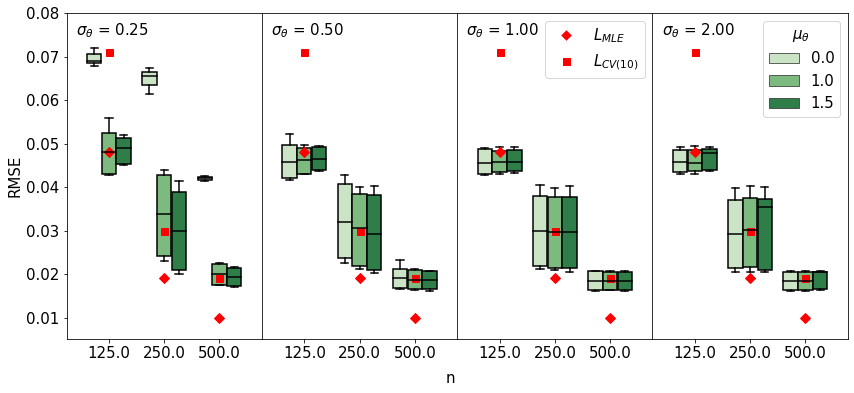

In [603]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(14,6))
#gs = gridspec.GridSpec(4, 1, width_ratios=[1, 1])
gs = gridspec.GridSpec(1, 4)
gs.update(wspace=0, hspace=0)

ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
ax2 = plt.subplot(gs[2])
ax3 = plt.subplot(gs[3])

pall = "Greens"
lw = 3
box_width = 0.8
lcol = "red"
markersize= 7


sns.boxplot(x = "n" , y = "RMSE", data = results_data[results_data["n_s"] == 0.25], hue = "n_mu", palette=pall, ax = ax0, width = box_width)
sns.boxplot(x = "n" , y = "RMSE", data = results_data[results_data["n_s"] == 0.5], hue = "n_mu", palette=pall, ax = ax1, width = box_width)
sns.boxplot(x = "n" , y = "RMSE", data = results_data[results_data["n_s"] == 1.0], hue = "n_mu", palette=pall, ax = ax2, width = box_width)
sns.boxplot(x = "n" , y = "RMSE", data = results_data[results_data["n_s"] == 2.0], hue = "n_mu", palette=pall, ax = ax3, width = box_width)

# Axes edition
ax1.set_yticks([])
ax2.set_yticks([])
ax3.set_yticks([])
ax1.set_ylabel("")
ax2.set_ylabel("")
ax3.set_ylabel("")



ax0.legend().remove()
ax1.legend().remove()
ax2.legend().remove()
ax3.legend(title=r"$\mu_{\theta}$")

for i in range(4):
    
    if i == 0:
        axes = ax0
        axes.text(-0.6, 0.075, r"$\sigma_{\theta}$ = 0.25")
    elif i == 1:
        axes = ax1
        axes.text(-0.6, 0.075, r"$\sigma_{\theta}$ = 0.50")
    elif i == 2:
        axes = ax2
        axes.text(-0.6, 0.075, r"$\sigma_{\theta}$ = 1.00")
        
        colors = ['red']
        lines = [Line2D([0], [0], color="w", marker = "D", markerfacecolor=lcol, markersize=markersize +2),
                 Line2D([0], [0], color="w", marker = "s", markerfacecolor=lcol, markersize=markersize +2)]
        labels = [r'$L_{MLE}$', r"$L_{CV(10)}$"]
        axes.legend(lines, labels)
    elif i == 3:
        axes = ax3
        axes.text(-0.6, 0.075, r"$\sigma_{\theta}$ = 2.00")
        
    axes.set_ylim([0.005,0.08])
    axes.set_xlabel("")
        
    plt.setp(axes.artists, edgecolor = 'k')
    plt.setp(axes.lines, color = 'k')

        

    axes.plot(0,0.048,marker="D",lw= lw, markersize=markersize, color = lcol, label = r"$L_{MLE}$")
    axes.plot(0,0.071,marker="s",lw= lw, markersize=markersize, color = lcol, label = r"$L_{CV(10)}$")
    #if i == 2:
    #    axes.legend([axes],[r"$L_{MLE}$", r"$L_{CV(10)}$"])
    axes.plot(1,0.019, marker="D",lw= lw,markersize=markersize, color = lcol)
    axes.plot(1,0.03,marker="s",lw= lw,markersize=markersize, color = lcol)
    axes.plot(2,0.01, marker="D",lw= lw,markersize=markersize, color = lcol)
    axes.plot(2,0.019,marker="s",lw= lw,markersize=markersize, color = lcol)


plt.text(-4.5, -0.005, "n")
plt.savefig("SensitivityRMSE" + '.pdf', dpi=300, bbox_inches='tight')
plt.show()

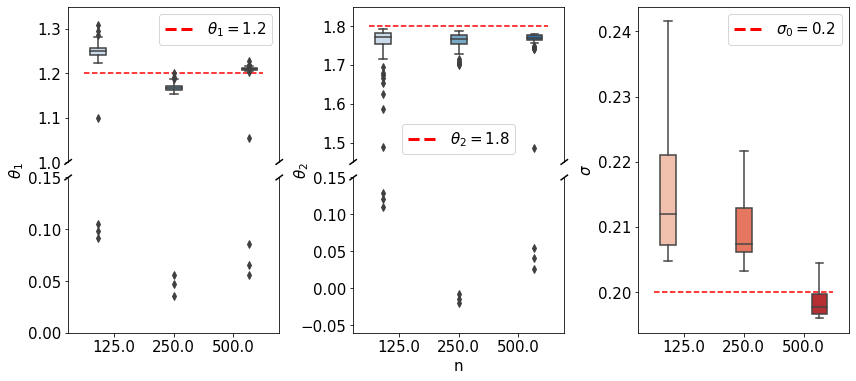

In [588]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(14,6))
#gs = gridspec.GridSpec(4, 1, width_ratios=[1, 1])
gs = gridspec.GridSpec(2, 3)
gs.update(wspace=0.35, hspace=0.1)
ls = "--"

ax = plt.subplot(gs[0])
ax2 = plt.subplot(gs[3])

#plt.rcParams.update({'font.size': 15})
#f, (ax, ax2) = plt.subplots(2, 1, sharex=True,figsize=(5,6))
sns.boxplot(x = "n" , y = "theta_1", data = results_data, hue = "n", ax = ax, palette="Blues",  width = box_width)
sns.boxplot(x = "n" , y = "theta_1", data = results_data, hue = "n", ax = ax2, palette="Blues",  width = box_width)

ax.set_ylim(1.0, 1.35)  # outliers only
ax2.set_ylim(0, .15)  # most of the data

ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
#ax.xaxis.tick_top()
ax.xaxis.set_visible(False)
ax.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

ax.legend().remove()
ax.set_xlabel("")
ax.set_ylabel("")
ax.hlines(1.2, -0.5,2.5, linestyles = ls, color = "red")
ax2.set_xlabel("")
ax2.legend().remove()
ax2.set_ylabel(r"$\theta_1$")
ax2.yaxis.set_label_coords(-0.2, 1.05)

colors = ['red']
lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='--') for c in colors]
labels = [r'$\theta_1 = 1.2$']
ax.legend(lines, labels)

ax = plt.subplot(gs[1])
ax2 = plt.subplot(gs[4])

#plt.rcParams.update({'font.size': 15})
#f, (ax, ax2) = plt.subplots(2, 1, sharex=True,figsize=(5,6))
sns.boxplot(x = "n" , y = "theta_2", data = results_data, hue = "n", ax = ax, palette="Blues", width = box_width)
sns.boxplot(x = "n" , y = "theta_2", data = results_data, hue = "n", ax = ax2, palette="Blues", width = box_width)

ax.set_ylim(1.45, 1.85)  # outliers only
ax2.set_ylim(-0.06, .15)  # most of the data

ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
#ax.xaxis.tick_top()
ax.xaxis.set_visible(False)
ax.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal
ax.legend().remove()
ax.hlines(1.8, -0.5,2.5, linestyles = ls, color = "red")
ax.set_xlabel("")
ax.set_ylabel("")
ax2.legend().remove()
ax2.set_ylabel(r"$\theta_2$")
ax2.yaxis.set_label_coords(-0.2, 1.05)

colors = ['red']
lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='--') for c in colors]
labels = [r'$\theta_2 = 1.8$']
ax.legend(lines, labels)

ax = plt.subplot(gs[:,2])
sns.boxplot(x = "n" , y = "sigma", data = results_data, hue = "n", ax = ax, palette="Reds", width = box_width)
ax.legend().remove()
ax.set_xlabel("")
ax.set_ylabel(r"$\sigma$")

ax.hlines(0.2, -0.5,2.5, linestyles = ls, color = "red", label = r"$\sigma_0 = 0.2$")

colors = ['red']
lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='--') for c in colors]
labels = [r'$\sigma_0 = 0.2$']
ax.legend(lines, labels)
plt.savefig("SensitivityParams" + '.pdf', dpi=300, bbox_inches='tight')
plt.show()

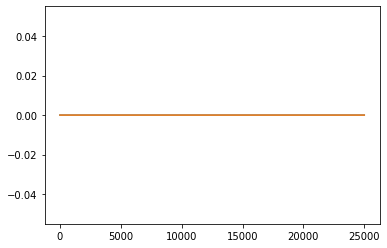

In [141]:
plt.plot(trace["theta"])

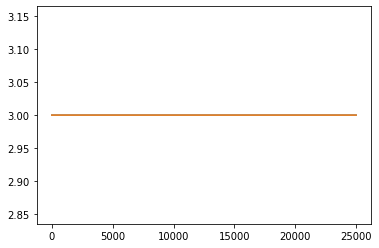

In [142]:
plt.plot(trace["kernel_delta_l"])

In [92]:
np.mean(trace["theta"][10000:], axis = 0)

array([1.25843719, 1.76156625])

In [91]:
np.mean(trace["sigma"][10000:])

0.2081358844804472

In [93]:
tf.random.set_seed(123)
np.random.seed(123)
input_obs_new = input_test
means_pred = {"f": "zero", "delta": "zero" }
posterior_samples = gp_mean_cov_Zeta_trace(trace, input_obs_new, input_obs, input_m, d_input, means = means_pred, Y_Z = Y_Z, n_sample = 10000)
print(np.sqrt(np.mean((Y_test - np.mean(posterior_samples, axis = 1))** 2)))

Sample count: 100%|██████████████████████████████████████████████████████████████| 10000/10000 [05:32<00:00, 30.05it/s]

0.049424714162309154


In [94]:
print(np.sqrt(np.mean((Y_test - np.mean(posterior_samples[:,5000:], axis = 1))** 2)))

0.04926160003589292


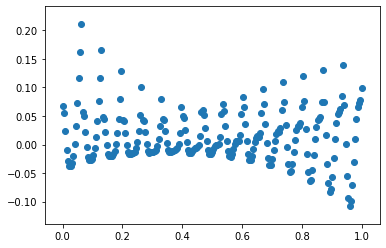

In [137]:
plt.scatter(np.linspace(0,1,len(Y_test)),Y_test - np.mean(posterior_samples, axis = 1))

(array([  4.,   7.,  55., 158., 265., 268., 153.,  60.,  21.,   9.]),
 array([2.00239646, 2.03123007, 2.06006369, 2.08889731, 2.11773092,
        2.14656454, 2.17539815, 2.20423177, 2.23306538, 2.261899  ,
        2.29073262]),
 <a list of 10 Patch objects>)

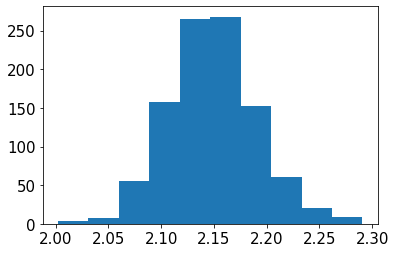

In [889]:
plt.hist(posterior_samples[1,:])

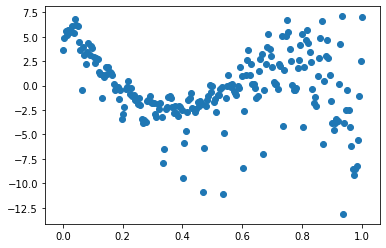

In [138]:
plt.scatter(np.linspace(0,1,len(Y_test)),Y_test - np.mean(pred_sample, axis = 1))

In [132]:
with open("test_samples_2_" + str(500) + '_' + str(500) + '.pickle', 'rb') as handle:
        pred_sample = pkl.load(handle)

In [102]:
pred_sample.shape

(225, 20000)

(array([  30.,  289., 1528., 4132., 6108., 5035., 2247.,  540.,   84.,
           7.]),
 array([-2.7968166 , -2.77332521, -2.74983381, -2.72634242, -2.70285102,
        -2.67935963, -2.65586824, -2.63237684, -2.60888545, -2.58539405,
        -2.56190266]),
 <a list of 10 Patch objects>)

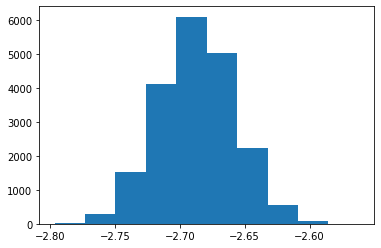

In [133]:
plt.hist(pred_sample[1,:])

In [136]:
print(np.sqrt(np.mean((Y_test - np.mean(pred_sample[:,5000:], axis = 1))** 2)))

3.6262476326713595


In [894]:
with open("test_samples_normal_" + str(n_mu) + "_" + str(n_s) + "_gamma_" + str(g_a) + "_" + str(g_b) + "_invgamma_" + str(ig_a) + "_" + str(ig_b) + "_" + str(n_obs) + '_' + str(n_m) + '.pickle', 'wb') as handle:
    pkl.dump(posterior_samples, handle, protocol=pkl.HIGHEST_PROTOCOL)

## Plots for data

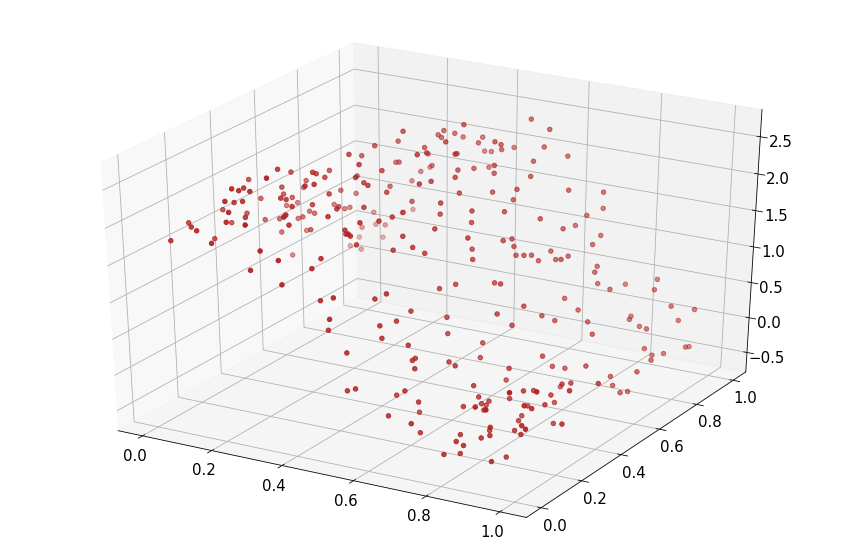

In [16]:
#plot obs
plt.rcParams.update({'font.size': 15})
fig = plt.figure(figsize=(15, 10)) 
gs = gridspec.GridSpec(1, 1)
ax1 = plt.subplot(gs[0], projection='3d')
#ax1 = fig.add_subplot(111, projection='3d')
ax1.scatter(X_obs,T_obs, Y, c = 'firebrick')

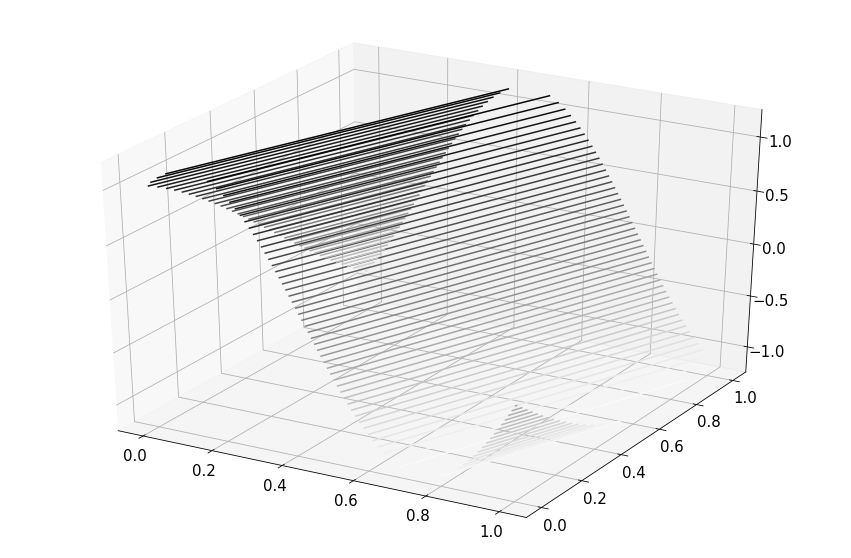

In [17]:
# plot function
#A = 1.5
t = np.linspace(0, 1, 100)
x = np.linspace(0,1,100)
#k = 1.2
#omega = 1
#phi = 1
T, X = np.meshgrid(t, x)
Y = traveling_wave(X, T, A, k, phi, omega)
fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection='3d')
ax.contour3D(X, T, Y, 50, cmap='binary')

## L_MLE

In [709]:
# Finding the hyperparameters - sigma is estimated first
tf.random.set_seed(123)
np.random.seed(123)
visited_array, y_ordered = path_algorithm_sigma(input_obs, Y_Z[:n_obs])
input_obs_sorted_index = np.linspace(0, len(y_ordered) - 1, len(y_ordered)).astype(int)
s_hat = sigma_estimate(y_ordered, input_obs_sorted_index)
d_input = 2
theta_input = 2
means = {"f": "zero", "delta": "zero"}
lkl_class = calibration_likelihood(input_obs, input_m, d_input, theta_input, theta, Y_Z, means, sigma_estimate = s_hat)
x = np.random.uniform(high= 3, size = 2 + 2*theta_input + d_input + d_input)
#print(transform(x[2:]))
x[2:] = inv_transform(x[2:])
#bounds = ((0.0,10.0), (0.0,10.0), (0.0,10.0), (0.0,10.0), (0.0,10.0), (0.0,10.0), (0.0,10.0), (0.0,10.0), (0.0,10.0))
print(x)
#res_hyp = minimize(lkl_class.likelihood_hyper, x, method='TNC', bounds = bounds)
#res_hyp = minimize(lkl_class.loss_MLE, x, method='Powell',tol = 1e-6, options={'disp': True, 'maxiter': 5000})
#res_hyp = minimize(lkl_class.loss_MLE, x, method='Nelder-Mead', tol = 1e-6, options={'disp': True, 'maxiter': 5000})
res_hyp = minimize(lkl_class.loss_MLE, x, method='BFGS', tol = 1e-6, options={'disp': True, 'maxiter': 5000})
#res_hyp = brute(lkl_class.likelihood_hyper, bounds)
print(res_hyp.x)
x = np.concatenate([res_hyp.x[:2], inv_transform(np.array([s_hat])), res_hyp.x[2:]])

[ 2.08940756  0.858418   -0.02534624  1.4416246   2.03566398  0.93939371
  2.888106    1.91734183  1.17325959  0.80760276]


KeyboardInterrupt: 

In [904]:
# Finding the hyperparameters - sigma is estimated first
tf.random.set_seed(123)
np.random.seed(123)
visited_array, y_ordered = path_algorithm_sigma(input_obs, Y_Z[:n_obs])
input_obs_sorted_index = np.linspace(0, len(y_ordered) - 1, len(y_ordered)).astype(int)
s_hat = sigma_estimate(y_ordered, input_obs_sorted_index)
d_input = 2
theta_input = 2
means = {"f": "zero", "delta": "zero"}
lkl_class = calibration_likelihood(input_obs, input_m, d_input, theta_input, theta, Y_Z, means, sigma_estimate = s_hat)
x = np.random.uniform(high= 2, size = 2 + 2*theta_input + d_input + d_input)
#print(transform(x[2:]))
x[2:] = inv_transform(x[2:])

bounds_L = -4
bounds_T = 4

lw = [0] * 2 + [bounds_L] * 8
up = [2] * 2 + [bounds_T] * 8
print(x)
#res_hyp = minimize(lkl_class.likelihood_hyper, x, method='TNC', bounds = bounds)
#res_hyp = minimize(lkl_class.loss_MLE, x, method='Powell',tol = 1e-6, options={'disp': True, 'maxiter': 5000})
#res_hyp = minimize(lkl_class.loss_MLE, x, method='Nelder-Mead', tol = 1e-6, options={'disp': True, 'maxiter': 5000})
#res_hyp = minimize(lkl_class.loss_MLE, x, method='BFGS', tol = 1e-6, options={'disp': True, 'maxiter': 1000})
#res_hyp = so.shgo(lkl_class.loss_MLE,bounds=list(zip(lw, up)), options={'disp': True, 'maxiter': 1000})
#res_hyp = so.dual_annealing(lkl_class.loss_MLE,bounds=list(zip(lw, up)), x0 = x, maxiter = 2000, seed =123)
#res_hyp = so.differential_evolution(lkl_class.loss_MLE,bounds=list(zip(lw, up)), maxiter = 2000, seed =123, tol = 0.001)
res_hyp = minimize(lkl_class.loss_MLE,bounds=list(zip(lw, up)), x0 =x, method = 'L-BFGS-B', options = {"maxls":100, "maxiter": 2000, "ftol": 1e-24})
print(res_hyp)
x = np.concatenate([res_hyp.x[:2], inv_transform(np.array([s_hat])), res_hyp.x[2:]])
print(x)

[ 1.39293837  0.57227867 -0.55489897  0.69916702  1.16820538  0.28578265
  1.80995721  1.07637038  0.48030582  0.17456696]
      fun: -135.76038760692472
 hess_inv: <10x10 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00836167,  0.01148237,  0.00496811,  0.00466684,  0.0083503 ,
        0.00242153,  0.00499654, -0.13839667, -0.15869546,  0.00524665])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 2068
      nit: 63
   status: 0
  success: True
        x: array([ 1.19743034,  1.78127289, -0.8553264 ,  0.50031057,  2.20268135,
        1.75999837,  1.54120516,  4.        ,  4.        , -0.07467158])
[ 1.19743034  1.78127289 -0.94542548 -0.8553264   0.50031057  2.20268135
  1.75999837  1.54120516  4.          4.         -0.07467158]


In [ ]:
# Finding the hyperparameters - sigma is estimated first
tf.random.set_seed(123)
np.random.seed(123)
visited_array, y_ordered = path_algorithm_sigma(input_obs, Y_Z[:n_obs])
input_obs_sorted_index = np.linspace(0, len(y_ordered) - 1, len(y_ordered)).astype(int)
s_hat = sigma_estimate(y_ordered, input_obs_sorted_index)
d_input = 2
theta_input = 2
means = {"f": "zero", "delta": "zero"}
lkl_class = calibration_likelihood(input_obs, input_m, d_input, theta_input, theta, Y_Z, means, sigma_estimate = s_hat)
x = np.random.uniform(high= 2, size = 2 + 2*theta_input + d_input + d_input)
#print(transform(x[2:]))
x[2:] = inv_transform(x[2:])

bounds_L = -4
bounds_T = 4

lw = [0] * 2 + [bounds_L] * 8
up = [2] * 2 + [bounds_T] * 8
print(x)
#res_hyp = minimize(lkl_class.likelihood_hyper, x, method='TNC', bounds = bounds)
#res_hyp = minimize(lkl_class.loss_MLE, x, method='Powell',tol = 1e-6, options={'disp': True, 'maxiter': 5000})
#res_hyp = minimize(lkl_class.loss_MLE, x, method='Nelder-Mead', tol = 1e-6, options={'disp': True, 'maxiter': 5000})
#res_hyp = minimize(lkl_class.loss_MLE, x, method='BFGS', tol = 1e-6, options={'disp': True, 'maxiter': 1000})
#res_hyp = so.shgo(lkl_class.loss_MLE,bounds=list(zip(lw, up)), options={'disp': True, 'maxiter': 1000})
#res_hyp = so.dual_annealing(lkl_class.loss_MLE,bounds=list(zip(lw, up)), x0 = x, maxiter = 2000, seed =123)
res_hyp = so.differential_evolution(lkl_class.loss_MLE,bounds=list(zip(lw, up)), maxiter = 2000, seed =123, tol = 0.001)
print(res_hyp)
x = np.concatenate([res_hyp.x[:2], inv_transform(np.array([s_hat])), res_hyp.x[2:]])
print(x)

In [905]:
x_mle = x
x_mle[2:] = transform(x_mle[2:])
tf.random.set_seed(1)
np.random.seed(1)
d_input = 2
theta_input = 2
M_p, K_p = lkl_class.predictive_likelihood(x_mle, input_test)
print(r"$\sqrt{MSE}=$ " + str(np.round(np.sqrt(np.mean((Y_test - M_p.flatten()) ** 2)),4)))

$\sqrt{MSE}=$ 0.0484


In [906]:
with open("MLE_fit_" + str(n_obs) + '_' + str(n_m) + '.pickle', 'wb') as handle:
    pkl.dump({"x": x, "M": M_p, "K":K_p}, handle, protocol=pkl.HIGHEST_PROTOCOL)

## L_CV

In [294]:
# Finding the hyperparameters
tf.random.set_seed(123)
np.random.seed(123)
d_input = 2
theta_input = 2
visited_array, y_ordered = path_algorithm_sigma(input_obs, Y_Z[:n_obs])
input_obs_sorted_index = np.linspace(0, len(y_ordered) - 1, len(y_ordered)).astype(int)
s_hat = sigma_estimate(y_ordered, input_obs_sorted_index)
means = {"f": "zero", "delta": "zero"}
lkl_class = calibration_likelihood(input_obs, input_m, d_input, theta_input, theta, Y_Z, means, CV_k = 5)
x = np.random.uniform(high= 3, size = 2 + 2*theta_input + d_input + d_input + 1)
#print(transform(x[2:]))
x[2:] = inv_transform(x[2:])
#bounds = ((0.0,10.0), (0.0,10.0), (0.0,10.0), (0.0,10.0), (0.0,10.0), (0.0,10.0), (0.0,10.0), (0.0,10.0), (0.0,10.0))
print(x)
#res_hyp = minimize(lkl_class.likelihood_hyper, x, method='TNC', bounds = bounds)
#res_hyp = minimize(lkl_class.loss_MLE, x, method='BFGS', options={'xatol': 1e-9, 'disp': True, 'maxiter': 5000})
res_hyp = minimize(lkl_class.loss_CV, x, method='Powell', tol = 1e-9, options={'disp': True, 'maxiter': 4000})
#res_hyp = brute(lkl_class.likelihood_hyper, bounds)
print(res_hyp.x)
x = res_hyp.x

[ 2.08940756  0.858418   -0.02534624  1.4416246   2.03566398  0.93939371
  2.888106    1.91734183  1.17325959  0.80760276  0.58765387]


KeyboardInterrupt: 

In [83]:
# Finding the hyperparameters
tf.random.set_seed(123)
np.random.seed(123)
d_input = 2
theta_input = 2
visited_array, y_ordered = path_algorithm_sigma(input_obs, Y_Z[:n_obs])
input_obs_sorted_index = np.linspace(0, len(y_ordered) - 1, len(y_ordered)).astype(int)
s_hat = sigma_estimate(y_ordered, input_obs_sorted_index)
means = {"f": "zero", "delta": "zero"}
lkl_class = calibration_likelihood(input_obs, input_m, d_input, theta_input, theta, Y_Z, means, CV_k = 3, sigma_estimate= s_hat)
x = np.random.uniform(high= 3, size = 2 + 2*theta_input + d_input + d_input)
#print(transform(x[2:]))
x[2:] = inv_transform(x[2:])
#bounds = ((0.0,10.0), (0.0,10.0), (0.0,10.0), (0.0,10.0), (0.0,10.0), (0.0,10.0), (0.0,10.0), (0.0,10.0), (0.0,10.0))
print(x)
#res_hyp = minimize(lkl_class.likelihood_hyper, x, method='TNC', bounds = bounds)
#res_hyp = minimize(lkl_class.loss_MLE, x, method='BFGS', tol = 1e-6, options={ 'disp': True, 'maxiter': 5000})
res_hyp = minimize(lkl_class.loss_CV, x, method='Powell', tol = 1e-9, options={'disp': True, 'maxiter': 5000})
#res_hyp = brute(lkl_class.likelihood_hyper, bounds)
print(res_hyp.x)
#x = res_hyp.x
x = np.concatenate([res_hyp.x[:2], inv_transform(np.array([s_hat])), res_hyp.x[2:]])

[ 2.08940756  0.858418   -0.02534624  1.4416246   2.03566398  0.93939371
  2.888106    1.91734183  1.17325959  0.80760276]


KeyboardInterrupt: 

In [774]:
# Finding the hyperparameters - sigma is estimated first
tf.random.set_seed(123)
np.random.seed(123)
visited_array, y_ordered = path_algorithm_sigma(input_obs, Y_Z[:n_obs])
input_obs_sorted_index = np.linspace(0, len(y_ordered) - 1, len(y_ordered)).astype(int)
s_hat = sigma_estimate(y_ordered, input_obs_sorted_index)
d_input = 2
theta_input = 2
means = {"f": "zero", "delta": "zero"}
lkl_class = calibration_likelihood(input_obs, input_m, d_input, theta_input, theta, Y_Z, means, CV_k=10, sigma_estimate = s_hat)
x = np.random.uniform(high= 2, size = 2 + 2*theta_input + d_input + d_input)
#print(transform(x[2:]))
x[2:] = inv_transform(x[2:])

bounds_L = -4
bounds_T = 4

lw = [0] * 2 + [bounds_L] * 8
up = [2] * 2 + [bounds_T] * 8
print(x)
#res_hyp = minimize(lkl_class.likelihood_hyper, x, method='TNC', bounds = bounds)
#res_hyp = minimize(lkl_class.loss_MLE, x, method='Powell',tol = 1e-6, options={'disp': True, 'maxiter': 5000})
#res_hyp = minimize(lkl_class.loss_MLE, x, method='Nelder-Mead', tol = 1e-6, options={'disp': True, 'maxiter': 5000})
#res_hyp = minimize(lkl_class.loss_MLE, x, method='BFGS', tol = 1e-6, options={'disp': True, 'maxiter': 1000})
#res_hyp = so.shgo(lkl_class.loss_MLE,bounds=list(zip(lw, up)), options={'disp': True, 'maxiter': 1000})
#res_hyp = so.dual_annealing(lkl_class.loss_CV,bounds=list(zip(lw, up)), x0 = x, maxiter = 4000, seed =123)
#res_hyp =minimize(lkl_class.loss_CV, bounds=list(zip(lw, up)), x0 =x, method = 'L-BFGS-B', options = {"eps":1e-010, "maxiter": 2000, "gtol": 1e-16})
#res_hyp =minimize(lkl_class.loss_CV, bounds=list(zip(lw, up)), x0 =x, method = 'SLSQP', options = {"eps":2e-01, "maxiter": 2000, "ftol": 1e-24})
res_hyp =minimize(lkl_class.loss_CV, bounds=list(zip(lw, up)), x0 =x, method = 'L-BFGS-B', options = {"eps":1e-01,"maxls":100, "maxiter": 2000, "ftol": 1e-24})
print(res_hyp)
x = np.concatenate([res_hyp.x[:2], inv_transform(np.array([s_hat])), res_hyp.x[2:]])
print(x)

[ 1.39293837  0.57227867 -0.55489897  0.69916702  1.16820538  0.28578265
  1.80995721  1.07637038  0.48030582  0.17456696]
      fun: 20.462373060602815
 hess_inv: <10x10 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -2.95501873,  -1.67471829, -12.76031854,  -0.31035367,
         0.65315132,  -1.29063221,   1.0090998 ,  -1.88766414,
        -0.88490309,   1.36525185])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 154
      nit: 5
   status: 0
  success: True
        x: array([ 1.15462785,  0.93870261, -1.50957618,  1.61520713, -0.28192183,
        1.09423257,  2.46355947, -0.54384774,  1.33272259,  1.39840252])
[ 1.15462785  0.93870261 -0.94542548 -1.50957618  1.61520713 -0.28192183
  1.09423257  2.46355947 -0.54384774  1.33272259  1.39840252]


In [721]:
float("2e-1")

0.2

In [339]:
x = np.random.uniform(high= 2, size = 2 + 2*theta_input + d_input + d_input)
x = np.concatenate([res_hyp.x[:2], inv_transform(np.array([s_hat])), res_hyp.x[2:]])
print(x)

[ 1.34159136  0.62491044 -0.94542548 -0.68191932  0.52596917  0.97763916
  0.12779178  1.59577887  0.88922887  0.31513535  0.02067573]


In [772]:
x = np.random.uniform(high= 2, size = 2 + 2*theta_input + d_input + d_input)
x = np.concatenate([x[:2], inv_transform(np.array([s_hat])), x[2:]])
print(x)
print(lkl_class.loss_CV(x))

[ 1.94794729  0.8639541  -0.94542548  0.23339593  0.43978286  0.43291023
  0.76919131  1.86380496  0.5793455   0.57035585  0.98472242]
31.83922228599145


In [96]:
# Finding the hyperparameters
tf.random.set_seed(123)
np.random.seed(123)
d_input = 2
theta_input = 2
visited_array, y_ordered = path_algorithm_sigma(input_obs, Y_Z[:n_obs])
input_obs_sorted_index = np.linspace(0, len(y_ordered) - 1, len(y_ordered)).astype(int)
s_hat = sigma_estimate(y_ordered, input_obs_sorted_index)
means = {"f": "zero", "delta": "zero"}
lkl_class = calibration_likelihood(input_obs, input_m, d_input, theta_input, theta, Y_Z, means, CV_k = 3, sigma_estimate= s_hat)
x = np.random.uniform(high= 2, size = 2 + 2*theta_input + d_input + d_input)
#print(transform(x[2:]))
x[2:] = inv_transform(x[2:])
bounds_L = -4
bounds_T = 4

lw = [0] * 2 + [bounds_L] * 8
up = [2] * 2 + [bounds_T] * 8
print(x)
#res_hyp = minimize(lkl_class.likelihood_hyper, x, method='TNC', bounds = bounds)
#res_hyp = minimize(lkl_class.loss_MLE, x, method='Powell',tol = 1e-6, options={'disp': True, 'maxiter': 5000})
#res_hyp = minimize(lkl_class.loss_MLE, x, method='Nelder-Mead', tol = 1e-6, options={'disp': True, 'maxiter': 5000})
#res_hyp = minimize(lkl_class.loss_MLE, x, method='BFGS', tol = 1e-6, options={'disp': True, 'maxiter': 1000})
#res_hyp = so.shgo(lkl_class.loss_MLE,bounds=list(zip(lw, up)), options={'disp': True, 'maxiter': 1000})
#res_hyp = so.dual_annealing(lkl_class.loss_CV,bounds=list(zip(lw, up)), x0 = x, maxiter = 4000, seed =123)
res_hyp = so.differential_evolution(lkl_class.loss_CV, bounds=list(zip(lw, up)), tol = 0.00001, maxiter = 2000, seed =123)
print(res_hyp)
x = np.concatenate([res_hyp.x[:2], inv_transform(np.array([s_hat])), res_hyp.x[2:]])
print(x)

[ 1.39293837  0.57227867 -0.55489897  0.69916702  1.16820538  0.28578265
  1.80995721  1.07637038  0.48030582  0.17456696]


KeyboardInterrupt: 

In [775]:
x_cv = x
x_cv[2:] = transform(x_cv[2:])
tf.random.set_seed(1)
np.random.seed(1)
d_input = 2
theta_input = 2
M_p, K_p = lkl_class.predictive_likelihood(x_cv, input_test)
#stds = np.sqrt(np.abs(np.diag(K_p)))
stds = np.sqrt(np.diag(K_p))
lw = 4
print(r"$\sqrt{MSE}=$ " + str(np.round(np.sqrt(np.mean((Y_test - M_p.flatten()) ** 2)),4)))

$\sqrt{MSE}=$ 0.1069


In [717]:
with open("CV_" + str(3) + "_fit_" + str(n_obs) + '_' + str(n_m) + '.pickle', 'wb') as handle:
    pkl.dump({"x": x, "M": M_p, "K":K_p}, handle, protocol=pkl.HIGHEST_PROTOCOL)

# Results calc

In [909]:
for optim in ["BF", "SL"]:
    for ck in ["3", "5", "8", "10", "124", "249", "499"]:
        for eps in ["3e-1", "2e-1", "1.5e-1", "1.25e-1", "1e-1", "1.75e-2", "1.5e-2", "1e-2", "1.75e-3", "1.5e-3", "1e-3","1e-5"]:
            for n_obs_t in ["125", "250", "500"]:
                
                print("CV_" + optim + "_" + ck + "eps_" + eps + "_fit_" + str(n_obs_t))
                
                try:
                    with open("CV/CV_" + optim + "_" + ck + "eps_" + eps + "_fit_" + n_obs_t + '_' + n_obs_t + '.pickle', 'rb') as handle:
                        cv = pkl.load(handle)
                    print(r"$\sqrt{MSE}=$ " + str(np.round(np.sqrt(np.mean((Y_test - cv["M"].flatten()) ** 2)),5)))
                except:
                    print("not found")
                
            

CV_BF_3eps_3e-1_fit_125
$\sqrt{MSE}=$ 0.10071
CV_BF_3eps_3e-1_fit_250
$\sqrt{MSE}=$ 0.09117
CV_BF_3eps_3e-1_fit_500
$\sqrt{MSE}=$ 0.07675
CV_BF_3eps_2e-1_fit_125
$\sqrt{MSE}=$ 0.10064
CV_BF_3eps_2e-1_fit_250
$\sqrt{MSE}=$ 0.06992
CV_BF_3eps_2e-1_fit_500
$\sqrt{MSE}=$ 0.0509
CV_BF_3eps_1.5e-1_fit_125
not found
CV_BF_3eps_1.5e-1_fit_250
not found
CV_BF_3eps_1.5e-1_fit_500
not found
CV_BF_3eps_1.25e-1_fit_125
not found
CV_BF_3eps_1.25e-1_fit_250
not found
CV_BF_3eps_1.25e-1_fit_500
not found
CV_BF_3eps_1e-1_fit_125
$\sqrt{MSE}=$ 0.10829
CV_BF_3eps_1e-1_fit_250
$\sqrt{MSE}=$ 0.1003
CV_BF_3eps_1e-1_fit_500
$\sqrt{MSE}=$ 0.07253
CV_BF_3eps_1.75e-2_fit_125
not found
CV_BF_3eps_1.75e-2_fit_250
not found
CV_BF_3eps_1.75e-2_fit_500
not found
CV_BF_3eps_1.5e-2_fit_125
not found
CV_BF_3eps_1.5e-2_fit_250
not found
CV_BF_3eps_1.5e-2_fit_500
not found
CV_BF_3eps_1e-2_fit_125
$\sqrt{MSE}=$ 0.12606
CV_BF_3eps_1e-2_fit_250
$\sqrt{MSE}=$ 0.04379
CV_BF_3eps_1e-2_fit_500
$\sqrt{MSE}=$ 0.19134
CV_BF_3eps_1

$\sqrt{MSE}=$ 0.08338
CV_SL_10eps_1.5e-3_fit_500
$\sqrt{MSE}=$ 0.06645
CV_SL_10eps_1e-3_fit_125
$\sqrt{MSE}=$ 0.39247
CV_SL_10eps_1e-3_fit_250
$\sqrt{MSE}=$ 0.09325
CV_SL_10eps_1e-3_fit_500
$\sqrt{MSE}=$ 0.04124
CV_SL_10eps_1e-5_fit_125
$\sqrt{MSE}=$ 0.41058
CV_SL_10eps_1e-5_fit_250
$\sqrt{MSE}=$ 0.37927
CV_SL_10eps_1e-5_fit_500
$\sqrt{MSE}=$ 0.35581
CV_SL_124eps_3e-1_fit_125
not found
CV_SL_124eps_3e-1_fit_250
not found
CV_SL_124eps_3e-1_fit_500
not found
CV_SL_124eps_2e-1_fit_125
not found
CV_SL_124eps_2e-1_fit_250
not found
CV_SL_124eps_2e-1_fit_500
not found
CV_SL_124eps_1.5e-1_fit_125
$\sqrt{MSE}=$ 0.08173
CV_SL_124eps_1.5e-1_fit_250
not found
CV_SL_124eps_1.5e-1_fit_500
not found
CV_SL_124eps_1.25e-1_fit_125
$\sqrt{MSE}=$ 0.06913
CV_SL_124eps_1.25e-1_fit_250
not found
CV_SL_124eps_1.25e-1_fit_500
not found
CV_SL_124eps_1e-1_fit_125
not found
CV_SL_124eps_1e-1_fit_250
not found
CV_SL_124eps_1e-1_fit_500
not found
CV_SL_124eps_1.75e-2_fit_125
$\sqrt{MSE}=$ 0.10118
CV_SL_124eps_1.75

n: 125
$\sqrt{MSE}=$ 0.04905
theta: [1.19743034 1.78127289]
$\sqrt{MSE}=$ 0.04845
theta: [1.21736373 1.78780818]
$\sqrt{MSE}=$ 0.07144
n: 250
$\sqrt{MSE}=$ 0.0365
theta: [1.16027262 1.80461945]
$\sqrt{MSE}=$ 0.01934
theta: [1.25099082 1.79925144]
$\sqrt{MSE}=$ 0.03021
n: 500
$\sqrt{MSE}=$ 0.02081
theta: [1.20679129 1.79226253]
$\sqrt{MSE}=$ 0.00985
theta: [1.20597664 1.81756787]
$\sqrt{MSE}=$ 0.01904


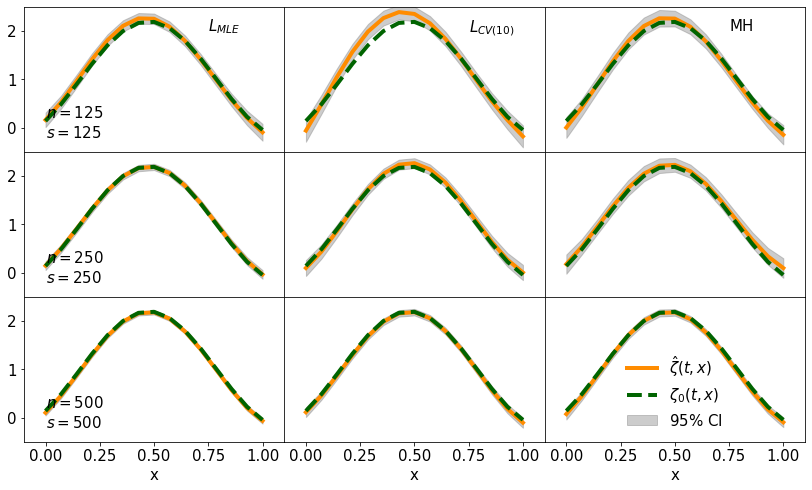

In [23]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(14,8))
gs = gridspec.GridSpec(3, 3, width_ratios=[1, 1,1])
gs.update(wspace=0, hspace=0)
lw = 4
#T_test_val = 0
T_test_val = T_test[224]
i = 0
for n_obs in [125, 250, 500]:
    n_m = n_obs
    print("n: " + str(n_obs) )
    with open("Sim1/test_samples_" + str(n_obs) + '_' + str(n_m) + '.pickle', 'rb') as handle:
        pred_sample = pkl.load(handle)
        
    print(r"$\sqrt{MSE}=$ " + str(np.round(np.sqrt(np.mean((Y_test - np.mean(pred_sample, axis = 1)) ** 2)),5)))
        
    with open("Sim1/MLE_fit_" + str(n_obs) + '_' + str(n_m) + '.pickle', 'rb') as handle:
        mle = pkl.load(handle)
        
    print("theta: " + str(mle["x"][:2]))
    print(r"$\sqrt{MSE}=$ " + str(np.round(np.sqrt(np.mean((Y_test - mle["M"].flatten()) ** 2)),5)))
    
    if n_obs == 125:
        name =  "BF_10eps_1.5e-1"
    else:
        name = "BF_10eps_1.75e-2"
        
    with open("Sim1/CV_" + name + "_fit_" + str(n_obs) + '_' + str(n_m) + '.pickle', 'rb') as handle:
        cv = pkl.load(handle)
        
    print("theta: " + str(cv["x"][:2]))
    print(r"$\sqrt{MSE}=$ " + str(np.round(np.sqrt(np.mean((Y_test - cv["M"].flatten()) ** 2)),5)))
    
    ax0 = plt.subplot(gs[0 + 3*i])
    ax1 = plt.subplot(gs[1 + 3*i])
    ax2 = plt.subplot(gs[2 + 3*i])
    
    mle_std = np.sqrt(np.diag(mle["K"]))
    ax0.plot(X_test[T_test == T_test_val], mle["M"][T_test == T_test_val], lw= lw, label = r"$\hat{\zeta}(x)$ ", color = "darkorange")
    ax0.plot(X_test[T_test == T_test_val], Y_test[T_test == T_test_val], label = r"$\zeta(x)$", ls = "--", lw=lw, color = "darkgreen")
    ax0.fill_between(X_test[T_test == T_test_val], mle["M"][T_test == T_test_val].flatten() - 1.96*mle_std[T_test == T_test_val],
                     mle["M"][T_test == T_test_val].flatten() + 1.96*mle_std[T_test == T_test_val], color='gray', alpha=0.4, label = r"$95\%$")
    
    
    cv_std = np.sqrt(np.diag(cv["K"]))
    ax1.plot(X_test[T_test == T_test_val], cv["M"][T_test == T_test_val], lw= lw, label = r"$\hat{\zeta}(x)$ ", color = "darkorange")
    ax1.plot(X_test[T_test == T_test_val], Y_test[T_test == T_test_val], label = r"$\zeta(x)$", ls = "--", lw=lw, color = "darkgreen")
    ax1.fill_between(X_test[T_test == T_test_val], cv["M"][T_test == T_test_val].flatten() - 1.96*cv_std[T_test == T_test_val],
                     cv["M"][T_test == T_test_val].flatten() + 1.96*cv_std[T_test == T_test_val], color='gray', alpha=0.4, label = r"$95\%$")
    
    mcmc_std = np.std(pred_sample, axis = 1)
    mcmc_m = np.mean(pred_sample, axis = 1)
    ax2.plot(X_test[T_test == T_test_val], mcmc_m[T_test == T_test_val], lw= lw, label = r"$\hat{\zeta}(t,x)$ ", color = "darkorange")
    ax2.plot(X_test[T_test == T_test_val], Y_test[T_test == T_test_val], label = r"$\zeta_0(t,x)$", ls = "--", lw=lw, color = "darkgreen")
    ax2.fill_between(X_test[T_test == T_test_val], mcmc_m[T_test == T_test_val].flatten() - 1.96*mcmc_std[T_test == T_test_val],
                     mcmc_m[T_test == T_test_val].flatten() + 1.96*mcmc_std[T_test == T_test_val], color='gray', alpha=0.4, label = r"$95\%$ CI")
    
    # Axis settings
    ax1.set_yticks([])
    ax2.set_yticks([])
    
    ax0.set_ylim([-0.5,2.5])
    ax1.set_ylim([-0.5,2.5])
    ax2.set_ylim([-0.5,2.5])
    
    ax0.set_xlim([-0.1,1.1])
    ax1.set_xlim([-0.1,1.1])
    ax2.set_xlim([-0.1,1.1])
    
    # Text
    ax0.text(0, 0.2, r"$n=$" + str(n_obs))
    ax0.text(0, -0.2, r"$s=$" + str(n_m))
    
    if n_obs == 125:
        ax0.text(0.75, 2, r"$L_{MLE}$")
        ax1.text(0.75, 2, r"$L_{CV(10)}$")
        ax2.text(0.75, 2, r"MH")
        
    if n_obs == 500:
        ax0.set_xlabel("x")
        ax1.set_xlabel("x")
        ax2.set_xlabel("x")
        
        ax2.legend(frameon=False)
    
    
    i = i + 1
    
plt.savefig("Sim1" + 't224' + '.pdf', dpi=300, bbox_inches='tight')
plt.show()

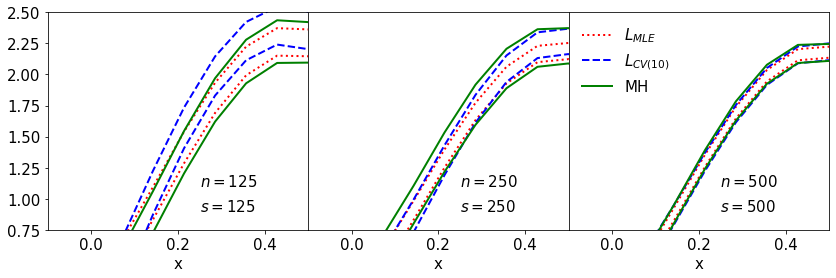

In [37]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(14,4))
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1,1])
gs.update(wspace=0, hspace=0)
lw = 2
#T_test_val = 0
T_test_val = T_test[224]
i = 0
for n_obs in [125, 250, 500]:
    n_m = n_obs
    #print("n: " + str(n_obs) )
    with open("Sim1/test_samples_" + str(n_obs) + '_' + str(n_m) + '.pickle', 'rb') as handle:
        pred_sample = pkl.load(handle)
        
        
    with open("Sim1/MLE_fit_" + str(n_obs) + '_' + str(n_m) + '.pickle', 'rb') as handle:
        mle = pkl.load(handle)
        
    
    if n_obs == 125:
        name =  "BF_10eps_1.5e-1"
    else:
        name = "BF_10eps_1.75e-2"
        
    with open("Sim1/CV_" + name + "_fit_" + str(n_obs) + '_' + str(n_m) + '.pickle', 'rb') as handle:
        cv = pkl.load(handle)
        
    
    ax0 = plt.subplot(gs[i])
    
    mle_std = np.sqrt(np.diag(mle["K"]))
    ax0.plot(X_test[T_test == T_test_val], mle["M"][T_test == T_test_val].flatten() + 1.96*mle_std[T_test == T_test_val],ls = ":",
             lw= lw, color = "red")
    ax0.plot(X_test[T_test == T_test_val], mle["M"][T_test == T_test_val].flatten() - 1.96*mle_std[T_test == T_test_val], label = r"$L_{MLE}$", ls = ":",
             lw=lw, color = "red")
    #ax0.fill_between(X_test[T_test == T_test_val], mle["M"][T_test == T_test_val].flatten() - 1.96*mle_std[T_test == T_test_val],
    #                 mle["M"][T_test == T_test_val].flatten() + 1.96*mle_std[T_test == T_test_val], color='gray', alpha=0.4, label = r"$95\%$")
    
    
    cv_std = np.sqrt(np.diag(cv["K"]))
    ax0.plot(X_test[T_test == T_test_val], cv["M"][T_test == T_test_val].flatten() + 1.96*cv_std[T_test == T_test_val], ls = "--",
             lw= lw, color = "blue")
    ax0.plot(X_test[T_test == T_test_val], cv["M"][T_test == T_test_val].flatten() - 1.96*cv_std[T_test == T_test_val],
             label = r"$L_{CV(10)}$", ls = "--", lw=lw, color = "blue")
    #ax0.fill_between(X_test[T_test == T_test_val], cv["M"][T_test == T_test_val].flatten() - 1.96*cv_std[T_test == T_test_val],
    #                 cv["M"][T_test == T_test_val].flatten() + 1.96*cv_std[T_test == T_test_val], color='gray', alpha=0.4, label = r"$95\%$")
    
    mcmc_std = np.std(pred_sample, axis = 1)
    mcmc_m = np.mean(pred_sample, axis = 1)
    ax0.plot(X_test[T_test == T_test_val], mcmc_m[T_test == T_test_val].flatten() + 1.96*mcmc_std[T_test == T_test_val],
             lw= lw, color = "green")
    ax0.plot(X_test[T_test == T_test_val], mcmc_m[T_test == T_test_val].flatten() - 1.96*mcmc_std[T_test == T_test_val],
             label = r"MH", lw=lw, color = "green")
    #ax0.fill_between(X_test[T_test == T_test_val], mcmc_m[T_test == T_test_val].flatten() - 1.96*mcmc_std[T_test == T_test_val],
    #                 mcmc_m[T_test == T_test_val].flatten() + 1.96*mcmc_std[T_test == T_test_val], color='gray', alpha=0.4, label = r"$95\%$ CI")
    
    # Axis settings
    if n_obs != 125:
        ax0.set_yticks([])
    
    ax0.set_ylim([0.75,2.5])
    #ax1.set_ylim([-0.5,2.5])
    #ax2.set_ylim([-0.5,2.5])
    
    ax0.set_xlim([-0.1,0.5])
    #ax1.set_xlim([-0.1,1.1])
    #ax2.set_xlim([-0.1,1.1])
    
    # Text
    ax0.text(0.25, 1.1, r"$n=$" + str(n_obs))
    ax0.text(0.25, 0.9, r"$s=$" + str(n_m))
    
    if n_obs == 125:
        #ax0.text(0.75, 2, r"$L_{MLE}$")
        ax1.text(0.75, 2, r"$L_{CV(10)}$")
        ax2.text(0.75, 2, r"MH")
        
    ax0.set_xlabel("x")
    
    if n_obs ==500:
        ax0.legend(frameon=False)
    
    
    i = i + 1
    
plt.savefig("Sim1CB" + 't224' + '.pdf', dpi=300, bbox_inches='tight')
plt.show()

### MLE

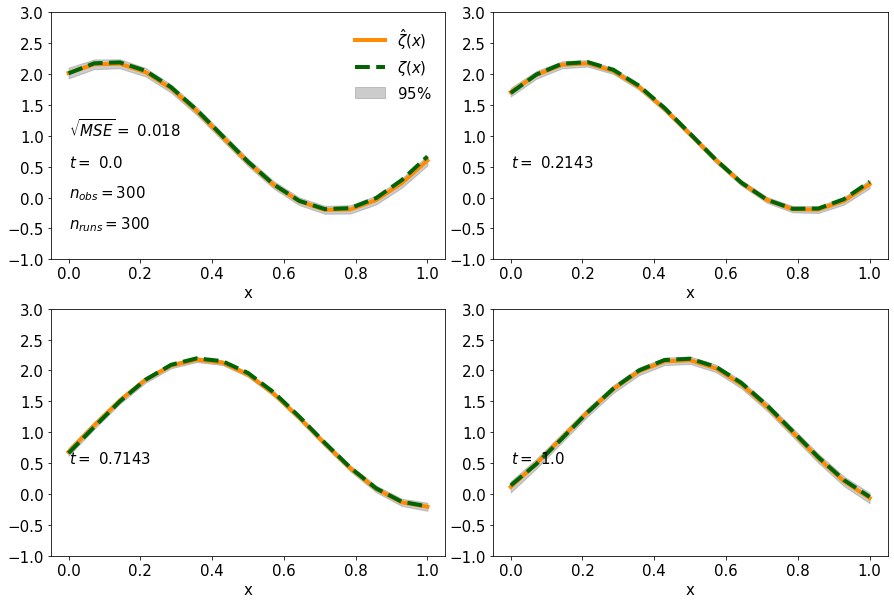

In [235]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(15,10))
gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1])
gs.update(wspace=0.12, hspace=0.2)

ax0 = plt.subplot(gs[0])
ax0.plot(X_test[T_test == 0], M_p[T_test == 0], lw= lw, label = r"$\hat{\zeta}(x)$ ", color = "darkorange")
ax0.fill_between(X_test[T_test == 0], M_p[T_test == 0].flatten() - 1.96*stds[T_test == 0], M_p[T_test == 0].flatten() + 1.96*stds[T_test == 0], color='gray', alpha=0.4, label = r"$95\%$")
ax0.plot(X_test[T_test == 0], Y_test[T_test == 0], label = r"$\zeta(x)$", ls = "--", lw=lw, color = "darkgreen")
ax0.text(0, 0.5, r"$t=$ " + str(np.round(T_test[0],4)))
#ax0.text(2.5, 1, r"$\hat{\theta}_{MLE}=$ " + str(np.round(res,4)))
#plt.text(0.8, 0.2, r"$\sqrt{MSE}=$ " + str(np.round(np.sqrt(np.mean((Y_test - M_p.flatten()) ** 2)),4)))
ax0.text(0, 0, r"$n_{obs}=$" + str(n_obs))
ax0.text(0, -0.5, r"$n_{runs}=$" + str(n_m))
ax0.text(0, 1, r"$\sqrt{MSE}=$ " + str(np.round(np.sqrt(np.mean((Y_test - M_p.flatten()) ** 2)),4)))
ax0.set_xlabel("x")
ax0.set_ylim([-1,3])
ax0.legend(frameon=False)

ax1 = plt.subplot(gs[1])
ax1.plot(X_test[T_test == T_test[50]], M_p[T_test == T_test[50]], lw= lw, label = r"$\hat{\zeta}(x)$ ", color = "darkorange")
ax1.fill_between(X_test[T_test == T_test[50]], M_p[T_test == T_test[50]].flatten() - 1.96*stds[T_test == T_test[50]], M_p[T_test == T_test[50]].flatten() + 1.96*stds[T_test == T_test[50]], color='gray', alpha=0.4, label = r"$95\%$")
ax1.plot(X_test[T_test == T_test[50]], Y_test[T_test == T_test[50]], label = r"$\zeta(x)$", ls = "--", lw=lw, color = "darkgreen")
ax1.text(0, 0.5, r"$t=$ " + str(np.round(T_test[50],4)))
ax1.set_xlabel("x")
ax1.set_ylim([-1,3])

ax2 = plt.subplot(gs[2])
ax2.plot(X_test[T_test == T_test[150]], M_p[T_test == T_test[150]], lw= lw, label = r"$\hat{\zeta}(x)$ ", color = "darkorange")
ax2.fill_between(X_test[T_test == T_test[150]], M_p[T_test == T_test[150]].flatten() - 1.96*stds[T_test == T_test[150]], M_p[T_test == T_test[150]].flatten() + 1.96*stds[T_test == T_test[150]], color='gray', alpha=0.4, label = r"$95\%$")
ax2.plot(X_test[T_test == T_test[150]], Y_test[T_test == T_test[150]], label = r"$\zeta(x)$", ls = "--", lw=lw, color = "darkgreen")
ax2.text(0, 0.5, r"$t=$ " + str(np.round(T_test[150],4)))
ax2.set_xlabel("x")
ax2.set_ylim([-1,3])


ax3 = plt.subplot(gs[3])
ax3.plot(X_test[T_test == T_test[224]], M_p[T_test == T_test[224]], lw= lw, label = r"$\hat{\zeta}(x)$ ", color = "darkorange")
ax3.fill_between(X_test[T_test == T_test[224]], M_p[T_test == T_test[224]].flatten() - 1.96*stds[T_test == T_test[224]], M_p[T_test == T_test[224]].flatten() + 1.96*stds[T_test == T_test[224]], color='gray', alpha=0.4, label = r"$95\%$")
ax3.plot(X_test[T_test == T_test[224]], Y_test[T_test == T_test[224]], label = r"$\zeta(x)$", ls = "--", lw=lw, color = "darkgreen")
ax3.text(0, 0.5, r"$t=$ " + str(np.round(T_test[224],4)))
ax3.set_xlabel("x")
ax3.set_ylim([-1,3])


plt.savefig("Wave_ml_fit_" + str(n_obs) + '.pdf', dpi=300, bbox_inches='tight')
plt.show()

# Simulation - Simple mathematical pendulum

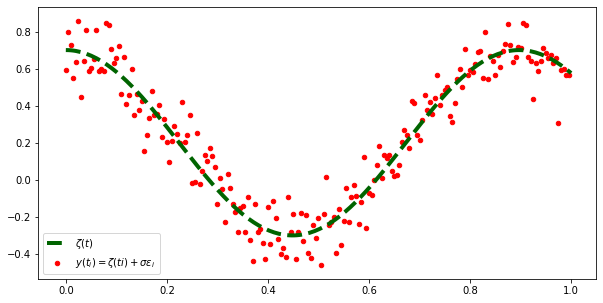

In [4]:
# Generating data for pendulum - simulation with one calibration parameter - length of pendulum
tf.random.set_seed(123)
np.random.seed(123)

# Presets for the simulation
n_obs = 200
noise = 1 / 10
# Offset as a constant
beta = 0.2

theta = [0.5, 0.2]
t_max = 1
g = 9.81

# Observations generation - training dataset
theta_grid = np.repeat(theta[0], n_obs)
g_grid = np.repeat(g, n_obs)
l_grid = np.repeat(theta[1], n_obs)
pdl = pendulum()

input_obs = np.linspace(0, t_max, n_obs, endpoint=False)
Y = pdl.evaluate_grid_observations(input_obs, theta_grid, g_grid, l_grid, beta, noise)
input_obs = input_obs[:, None]

# Observatio generation testing dataset
n_test = 200
input_test = np.linspace(0, t_max, n_test)
theta_grid_test = np.repeat(theta[0], n_test)
g_grid_test = np.repeat(g, n_test)
l_grid_test = np.repeat(theta[1], n_test)
Y_test = pdl.evaluate_grid(input_test, theta_grid_test, g_grid_test, l_grid_test) + beta


# Model eval generation
np.random.seed(0)
n_m = 200
criterion = "c"

input_m = input_locations(2, n_input = n_m, lims = np.array([[0, 1], [0, 1]]), criterion= criterion)
g_grid = np.repeat(g, n_m)

# We are interested in situation with unknown length of the pendulum - that is our calibration parameter
theta_grid = np.repeat(theta[0], n_m)
Z = pdl.evaluate_grid(input_m[:,0], theta_grid, g_grid, input_m[:,1])

Y_Z = np.concatenate([Y,Z])

# Plotting the data
dot_size = 20
lw = 4
plt.figure(figsize=(10,5))
#plt.scatter(x_obs, true_process_mod , c = 'b', s = dot_size, label = r'$f_m(x_i, \theta)$')
plt.scatter(input_obs, Y, c = 'r', s = dot_size, label = r'$y(t_i) = \zeta(ti) + \sigma \epsilon_i$')

#sns.scatterplot(x=input_m[:,0], y=Z)
plt.plot(input_test, Y_test, label = r"$\zeta(t)$", ls = "--", lw=lw, color = "darkgreen")
plt.legend()
plt.savefig("Pendulum_obs" + '.pdf', dpi=300)
plt.show()

## Calibration

In [5]:
# Finding the hyperparameters
tf.random.set_seed(2)
np.random.seed(2)
d_input = 1
theta_input = 1
lkl_class = calibration_likelihood(input_obs, input_m, d_input, theta_input, theta[0], Y_Z)
x = np.random.uniform(high= 1, size = 2 + theta_input + d_input + d_input + 1)
bounds = ((0.0,1.0), (0.0,1.0), (0.0,1.0), (0.0,1.0), (0.0,1.0), (0.0,1.0))
print(x)
res_hyp = minimize(lkl_class.likelihood_hyper, x, method='nelder-mead', options={'xatol': 1e-12, 'disp': True, 'maxiter': 5000})
print(res_hyp.x)

[0.4359949  0.02592623 0.54966248 0.43532239 0.4203678  0.33033482]
Optimization terminated successfully.
         Current function value: -296.009675
         Iterations: 923
         Function evaluations: 1553
[0.10588978 0.15234173 0.03577618 0.3570244  0.27280826 0.59656549]


### Theta estimate MLE

[0.4359949]
Optimization terminated successfully.
         Current function value: -296.718246
         Iterations: 37
         Function evaluations: 84
[0.45527618]


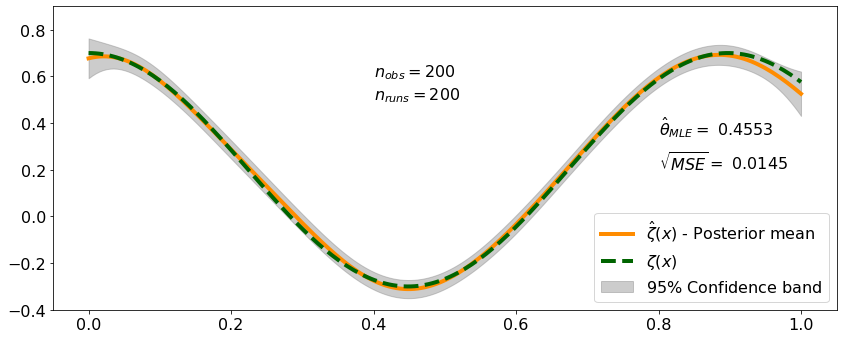

In [6]:
# Estimating the calibraiton parameter
tf.random.set_seed(2)
np.random.seed(2)
d_input = 1
theta_input = 1
lkl_class = calibration_likelihood(input_obs, input_m, d_input, theta_input, theta[0], Y_Z)
lkl_class.likelihood_update_hyper(res_hyp.x)
x = np.random.uniform(high= 1, size = 1)
print(x)
res = minimize(lkl_class.likelihood_theta, x, method='nelder-mead', options={'xatol': 1e-12, 'disp': True, 'maxiter': 5000})
print(res.x)

# Printing Results
x = np.concatenate([res.x, res_hyp.x])
tf.random.set_seed(1)
np.random.seed(1)
d_input = 1
theta_input = 1
#lkl_class = calibration_likelihood(input_obs, input_m, d_input, theta_input, Y_Z)
M_p, K_p = lkl_class.predictive_likelihood(x, input_test[:,None])
stds = np.sqrt(np.diag(K_p))
lw = 4
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(12,5))
plt.plot(input_test, M_p, lw= lw, label = r"$\hat{\zeta}(x)$ - Posterior mean", color = "darkorange")
plt.fill_between(input_test, M_p.flatten() - 1.96*stds, M_p.flatten() + 1.96*stds, color='gray', alpha=0.4, label = r"$95\%$ Confidence band")
plt.plot(input_test, Y_test, label = r"$\zeta(x)$", ls = "--", lw=lw, color = "darkgreen")
plt.text(0.8, 0.35, r"$\hat{\theta}_{MLE}=$ " + str(float(np.round(res.x,4))))
plt.text(0.8, 0.2, r"$\sqrt{MSE}=$ " + str(np.round(np.sqrt(np.mean((Y_test - M_p.flatten()) ** 2)),4)))
plt.text(0.4, 0.6, r"$n_{obs}=$" + str(n_obs))
plt.text(0.4, 0.5, r"$n_{runs}=$" + str(n_m))
plt.legend()
plt.ylim([-0.4,0.9])
plt.xlim([-0.05,1.05])
plt.tight_layout(rect=[0, 0.00, 1, 1])
plt.savefig("Pendulum_fit_" + str(n_obs) + '.pdf', dpi=300)
plt.show()

### Tuo, Wu estimate (Least squares)

[0.4359949]
Optimization terminated successfully.
         Current function value: 0.037836
         Iterations: 42
         Function evaluations: 95
[0.19160103]


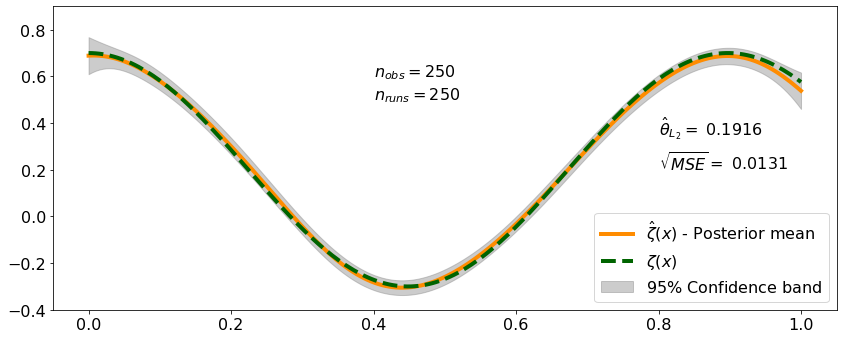

In [868]:
# Estimating the calibration parameter
tf.random.set_seed(2)
np.random.seed(2)
d_input = 1
theta_input = 1
lkl_class = calibration_likelihood(input_obs, input_m, d_input, theta_input, theta[0], Y_Z)
lkl_class.likelihood_update_hyper(res_hyp.x)
x = np.random.uniform(high= 1, size = 1)
print(x)
res = minimize(lkl_class.MSE, x, method='Nelder-Mead', options={'xatol': 1e-12, 'disp': True, 'maxiter': 5000})
print(res.x)


# Printing Results
x = np.concatenate([res.x, res_hyp.x])
tf.random.set_seed(1)
np.random.seed(1)
d_input = 1
theta_input = 1
#lkl_class = calibration_likelihood(input_obs, input_m, d_input, theta_input, Y_Z)
M_p, K_p = lkl_class.predictive_likelihood(x, input_test[:,None])
stds = np.sqrt(np.diag(K_p))
lw = 4
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(12,5))
plt.plot(input_test, M_p, lw= lw, label = r"$\hat{\zeta}(x)$ - Posterior mean", color = "darkorange")
plt.fill_between(input_test, M_p.flatten() - 1.96*stds, M_p.flatten() + 1.96*stds, color='gray', alpha=0.4, label = r"$95\%$ Confidence band")
plt.plot(input_test, Y_test, label = r"$\zeta(x)$", ls = "--", lw=lw, color = "darkgreen")
plt.text(0.8, 0.35, r"$\hat{\theta}_{L_2}=$ " + str(float(np.round(res.x,4))))
plt.text(0.8, 0.2, r"$\sqrt{MSE}=$ " + str(np.round(np.sqrt(np.mean((Y_test - M_p.flatten()) ** 2)),4)))
plt.text(0.4, 0.6, r"$n_{obs}=$" + str(n_obs))
plt.text(0.4, 0.5, r"$n_{runs}=$" + str(n_m))
plt.legend()
plt.ylim([-0.4,0.9])
plt.xlim([-0.05,1.05])
plt.tight_layout(rect=[0, 0.00, 1, 1])
plt.savefig("Pendulum_fit_ls" + str(n_obs) + '.pdf', dpi=300)
plt.show()

## Predictive likelihood

(200, 200)
(200, 200)
(200, 400)


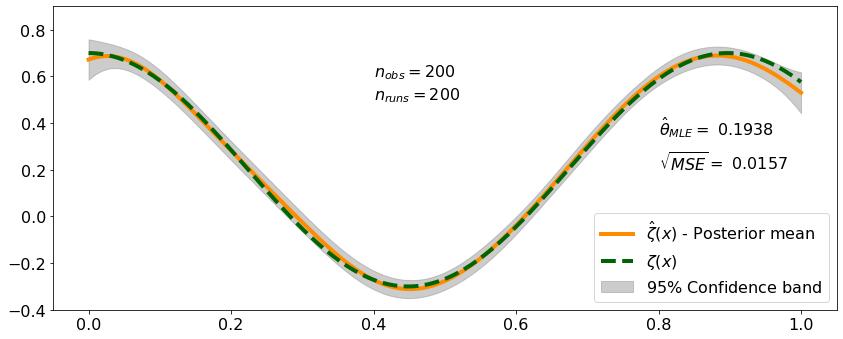

In [820]:
x = np.concatenate([res.x, res_hyp.x])
tf.random.set_seed(1)
np.random.seed(1)
d_input = 1
theta_input = 1
#lkl_class = calibration_likelihood(input_obs, input_m, d_input, theta_input, Y_Z)
M_p, K_p = lkl_class.predictive_likelihood(x, input_test[:,None])
stds = np.sqrt(np.diag(K_p))
lw = 4
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(12,5))
plt.plot(input_test, M_p, lw= lw, label = r"$\hat{\zeta}(x)$ - Posterior mean", color = "darkorange")
plt.fill_between(input_test, M_p.flatten() - 1.96*stds, M_p.flatten() + 1.96*stds, color='gray', alpha=0.4, label = r"$95\%$ Confidence band")
plt.plot(input_test, Y_test, label = r"$\zeta(x)$", ls = "--", lw=lw, color = "darkgreen")
plt.text(0.8, 0.35, r"$\hat{\theta}_{MLE}=$ " + str(float(np.round(res.x,4))))
plt.text(0.8, 0.2, r"$\sqrt{MSE}=$ " + str(np.round(np.sqrt(np.mean((Y_test - M_p.flatten()) ** 2)),4)))
plt.text(0.4, 0.6, r"$n_{obs}=$" + str(n_obs))
plt.text(0.4, 0.5, r"$n_{runs}=$" + str(n_m))
plt.legend()
plt.ylim([-0.4,0.9])
plt.xlim([-0.05,1.05])
plt.tight_layout(rect=[0, 0.00, 1, 1])
plt.savefig("Pendulum_fit_" + str(n_obs) + '.pdf', dpi=300)
plt.show()